# TODO: 
- Tutte le task: fare train con 30 seeds (?) e 20 epoche (?) e poi fare commenti risultati
- ~~Tutte le task: gestire val loss?~~
- ~~Tutte le task: impostare salvataggio dei risultati (array numpy -> pd DataFrame -> file excel) e grafici ~~
- ~~Task 3: rapporti alpha e beta per mixed da capire anche in base al punto precedente -> facciamo 1 e 1~~
- Task 4: gamma partire con 1.0 ma eventualmente da fare un po' di esperimenti / tuning 
- Task 4: fare solo con dati migliori (alpha e beta di conseguenza)
- Task 4: provare a implementare anche strada con log e exp anzichè aggiungere nuova loss 
- Task 5: aggiungere lagrangiano a modello migliore 
- Task 5: peso dinamico a beta (eventualmente gamma se usiamo modello task 4), alpha statico a 1
- Task 5: fare solo con dati migliori

- PW da impostare dopo aver discusso progetto

In [1]:
# ============================================================
# Notebook setup
# ============================================================

%reload_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)


import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from tabulate import tabulate
import random

from util import cst

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras import backend as k
from keras.callbacks import CSVLogger

#from tensorflow_probability import distributions
from sklearn.metrics import r2_score, mean_squared_error

# Parameters
stop = 1400
epochs = 15
batch_size = 32
num_seeds = 30
excel_file_path = 'results.xlsx'



## Data Loading and Preparation

### Data loading

In [2]:
# Load data
data_folder = '/app/data'
data = cst.load_cmapss_data(data_folder)
# Identify input columns
dt_in = list(data.columns[3:-1])

### Data inspection


- *src* is the train surce 
- *machine* is the number associated to a single machine
- *p* are the controlled parameters
- *s* are the sensors
- *rul* is the remaining useful life, namely the label 

In [3]:
data.head()

src  machine  cycle      p1      p2     p3      s1      s2  \
0  train_FD001        1      1 -0.0007 -0.0004  100.0  518.67  641.82   
1  train_FD001        1      2  0.0019 -0.0003  100.0  518.67  642.15   
2  train_FD001        1      3 -0.0043  0.0003  100.0  518.67  642.35   
3  train_FD001        1      4  0.0007  0.0000  100.0  518.67  642.35   
4  train_FD001        1      5 -0.0019 -0.0002  100.0  518.67  642.37   

        s3       s4  ...      s13      s14     s15   s16  s17   s18    s19  \
0  1589.70  1400.60  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  1591.82  1403.14  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2  1587.99  1404.20  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3  1582.79  1401.87  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4  1582.85  1406.22  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0   

     s20      s21  rul  
0  39.06  23.4190  191  
1  39.00  23.4236  190  
2  38.95  23.3442  189  
3  38.88  23.3739  188  
4  38.90  23.4044  187  

[5 rows x 28 columns]

Example of machine 1: the rul value goes from 191 to 0 decreasing monotonically

In [4]:
data[data['machine'] == 1].head(len(data[data['machine'] == 1]))

src  machine  cycle      p1      p2     p3      s1      s2  \
0    train_FD001        1      1 -0.0007 -0.0004  100.0  518.67  641.82   
1    train_FD001        1      2  0.0019 -0.0003  100.0  518.67  642.15   
2    train_FD001        1      3 -0.0043  0.0003  100.0  518.67  642.35   
3    train_FD001        1      4  0.0007  0.0000  100.0  518.67  642.35   
4    train_FD001        1      5 -0.0019 -0.0002  100.0  518.67  642.37   
..           ...      ...    ...     ...     ...    ...     ...     ...   
187  train_FD001        1    188 -0.0067  0.0003  100.0  518.67  643.75   
188  train_FD001        1    189 -0.0006  0.0002  100.0  518.67  644.18   
189  train_FD001        1    190 -0.0027  0.0001  100.0  518.67  643.64   
190  train_FD001        1    191 -0.0000 -0.0004  100.0  518.67  643.34   
191  train_FD001        1    192  0.0009 -0.0000  100.0  518.67  643.54   

          s3       s4  ...      s13      s14     s15   s16  s17   s18    s19  \
0    1589.70  1400.60  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1    1591.82  1403.14  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2    1587.99  1404.20  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3    1582.79  1401.87  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4    1582.85  1406.22  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0   
..       ...      ...  ...      ...      ...     ...   ...  ...   ...    ...   
187  1602.38  1422.78  ...  2388.23  8117.69  8.5207  0.03  396  2388  100.0   
188  1596.17  1428.01  ...  2388.33  8117.51  8.5183  0.03  395  2388  100.0   
189  1599.22  1425.95  ...  2388.35  8112.58  8.5223  0.03  398  2388  100.0   
190  1602.36  1425.77  ...  2388.30  8114.61  8.5174  0.03  394  2388  100.0   
191  1601.41  1427.20  ...  2388.32  8110.93  8.5113  0.03  396  2388  100.0   

       s20      s21  rul  
0    39.06  23.4190  191  
1    39.00  23.4236  190  
2    38.95  23.3442  189  
3    38.88  23.3739  188  
4    38.90  23.4044  187  
..     ...      ...  ...  
187  38.51  22.9588    4  
188  38.48  23.1127    3  
189  38.49  23.0675    2  
190  38.45  23.1295    1  
191  38.48  22.9649    0  

[192 rows x 28 columns]

We will plot a histogram showing the distribution of max rul values for each machine

<Axes: >

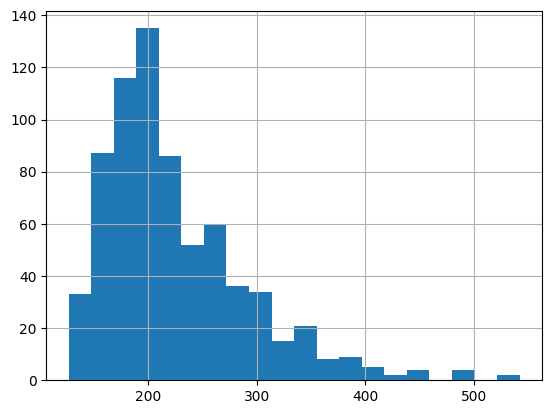

In [5]:
data[data['cycle'] == 1].groupby(['machine']).max()['rul'].hist(bins=20)

In [6]:
#standardize data
data_sv = data.copy()
data_sv[dt_in] = (data_sv[dt_in] - data_sv[dt_in].mean()) / data_sv[dt_in].std()

In [7]:
data_by_src = cst.split_by_field(data_sv, field='src')

We inspect data by plotting heatmaps. We consider only data conatined in train_FD004, which has 6 operating conditions and 2 fault modes

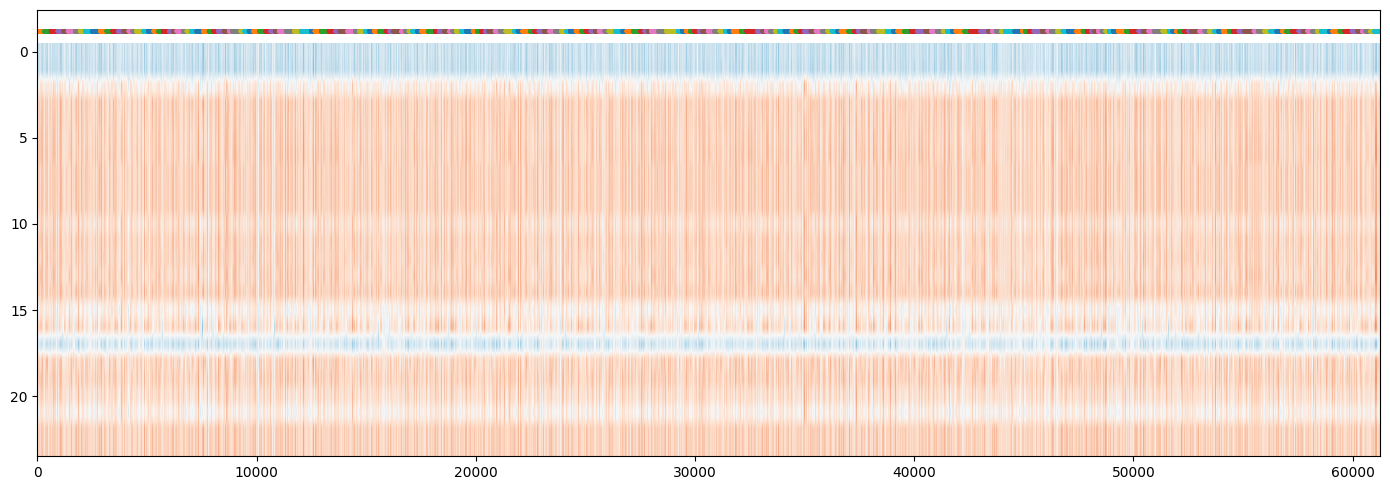

In [8]:
data_sv = data_by_src["train_FD004"]
cst.plot_dataframe(data_sv[dt_in], labels=data_sv['machine'], figsize=figsize)

There is a high varibaility in the plotted series, which is the result of multiple operating conditions

We will then inspect in detail a column providing information on a given sensor, to see if there is any claer trend in the data.

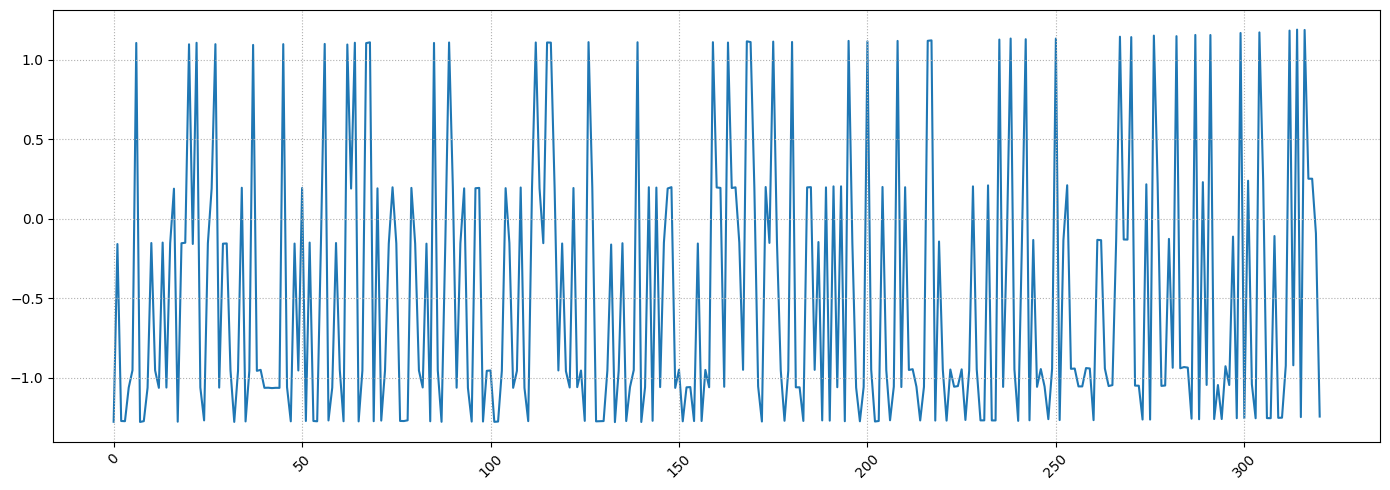

In [9]:
tmp = data_sv[data_sv['machine'] == data_sv['machine'].iloc[0]]
cst.plot_series(tmp['s7'], figsize=figsize)

There is a weak trend tied to component wear, and it is mainly covered by wide oscillations. 

In [10]:
#we use just dataset 4
dt = data_by_src["train_FD004"]

In [11]:
dt.head()

src  machine  cycle        p1        p2        p3        s1  \
0  train_FD004      461      1  1.500057  1.168664  0.345954 -1.342550   
1  train_FD004      461      2  0.168806  0.788709  0.345954  0.175840   
2  train_FD004      461      3  1.499991  1.171110  0.345954 -1.342550   
3  train_FD004      461      4  1.499761  1.168664  0.345954 -1.342550   
4  train_FD004      461      5  0.471584  0.572641 -2.890543 -0.765963   

         s2        s3        s4  ...       s13       s14       s15       s16  \
0 -1.122474 -1.045952 -1.086033  ...  0.344929 -0.175148  0.370889 -1.037783   
1  0.205021  0.089480 -0.172094  ...  0.342590 -0.531124  0.181688 -1.037783   
2 -1.139659 -1.048575 -1.055806  ...  0.344749 -0.276979  0.460301 -1.037783   
3 -1.145544 -1.064484 -1.048616  ...  0.345198 -0.160016  0.375413 -1.037783   
4 -1.442165 -1.792301 -1.668131  ... -2.892626 -2.767824  2.370806 -1.037783   

        s17       s18       s19       s20       s21  rul  
0 -0.989600 -0.433322  0.345954 -1.310594 -1.311278  320  
1  0.009709  0.352571  0.345954 -0.134518 -0.129792  319  
2 -1.021836 -0.433322  0.345954 -1.322569 -1.303537  318  
3 -1.054071 -0.433322  0.345954 -1.317437 -1.304065  317  
4 -1.795494 -2.517341 -2.890543 -1.018927 -0.982214  316  

[5 rows x 28 columns]

## **Project**

**We will run multiple experiments on our data to analyse the effect of domain knowledge injection via multiple approaches.**

- In the first 3 tasks we will experiment with different ratios and combinations of supervised and unsupervised data.
- In task 4 we will use a static regularizer to inject domain knowledge (RUL>0). 
- In task 5 we will use a lagrangian approach to dynamically maximize the weight of the regularizer.

For the first 3 tasks we use the following training configuration, where we will change parameters according to the task addressed.

In [12]:
def train_model(train_data, val_data, test_data, columns, maxrul, alpha, beta, logger_file, seeds=num_seeds, epochs=epochs):
    pred = []
    history = []
    if os.path.exists('./history/'+logger_file):
        os.remove('./history/'+logger_file)
    for i in range(seeds):
        np.random.seed(i)
        tf.random.set_seed(i)
        random.seed(i)
        nn = cst.CstRULRegressor(input_shape=len(columns), alpha=alpha, beta=beta, maxrul=maxrul, hidden=[32, 32])
        batch_gen = cst.CstBatchGenerator(train_data, columns, batch_size=32, seed=i)
        batch_gen_val = cst.CstBatchGenerator(val_data, columns, batch_size=32, seed=i)
        cb = callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        csv_logger = CSVLogger('./history/'+logger_file, separator=',', append=True)
        nn.compile(optimizer='Adam', run_eagerly=False)
        history.append(nn.fit(batch_gen, validation_data=batch_gen_val, epochs=epochs, verbose=1, callbacks=[cb, csv_logger]))
        pred.append(np.round(nn.predict(test_data[columns]).ravel()*maxrul))
    return history, pred

The following function is used to train the model for task 4.

In [13]:
def train_task4(train_data, val_data, test_data, columns, maxrul, alpha, beta, gamma, logger_file, seeds=num_seeds, epochs=epochs):
    pred = []
    history = []
    if os.path.exists('./history/'+logger_file):
        os.remove('./history/'+logger_file)
    for i in range(seeds):
        np.random.seed(i)
        tf.random.set_seed(i)
        random.seed(i)
        nn = cst.CstPosRULRegressor(len(columns), alpha=alpha, beta=beta, gamma=gamma, maxrul=maxrul, hidden=[32, 32])
        batch_gen = cst.CstBatchGenerator(train_data, columns, batch_size=32, seed=i)
        batch_gen_val = cst.CstBatchGenerator(val_data, columns, batch_size=32, seed=i)
        cb = callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        csv_logger = CSVLogger('./history/'+logger_file, separator=',', append=True)
        nn.compile(optimizer='Adam', run_eagerly=False)
        history.append(nn.fit(batch_gen, validation_data=batch_gen_val, epochs=epochs, verbose=1, callbacks=[cb, csv_logger]))
        pred.append(np.round(nn.predict(test_data[columns]).ravel()*maxrul))
    return history, pred
    

The following function is used to train the model for task 5.

In [14]:
def train_task5(train_data, val_data, test_data, columns, maxrul, alpha, beta, gamma, logger_file, seeds=num_seeds, epochs=epochs):
    pred = []
    history = []
    if os.path.exists('./history/'+logger_file):
        os.remove('./history/'+logger_file)
    for i in range(seeds):
        np.random.seed(i)
        tf.random.set_seed(i)
        random.seed(i)
        if gamma == 0:
            nn = cst.CstRULRegressorWithLagrangian(input_shape=len(columns), alpha=alpha, beta=beta, maxrul=maxrul, hidden=[32, 32]) 
        else:
            nn = cst.CstPosRULRegressorWithLagrangian(input_shape=len(columns), alpha=alpha, beta=beta, gamma=gamma, maxrul=maxrul, hidden=[32, 32])
        batch_gen = cst.CstBatchGenerator(train_data, columns, batch_size=32, seed=i)
        batch_gen_val = cst.CstBatchGenerator(val_data, columns, batch_size=32, seed=i)
        cb = callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        csv_logger = CSVLogger('./history/'+logger_file, separator=',', append=True)
        nn.compile(optimizer='Adam', run_eagerly=False)
        history.append(nn.fit(batch_gen, validation_data=batch_gen_val, epochs=epochs, verbose=1, callbacks=[cb, csv_logger]))
        pred.append(np.round(nn.predict(test_data[columns]).ravel()*maxrul))
    return history, pred

### **Task 1**: train the model with only supervised data. We will experiment with different ratios of supervised data. 


In general, we expect that using higher ratios of supervised data will ensure better performances. However, if the model is too simple, it may incur in overfitting. 
- We expect that all the models trained with supervised data are the ones performing better with respect to the unsupervised counterparts. 
- Moreover, we expect that they learn the decreasing trend and also to predict the failure in an accurate way.
- We foresee that using 100% of supervised data will ensure the best results, however we do not expect that the differences in performances will be as significant as those in the models with both supervised and unsupervised data. 

For Task 1 we train the model only with supervised data. In this setting we use *mse* loss which computes the Mean Squared Error between the predicted RUL values and the true labels. For this reason we set *alpha* paarameter to 1 and *beta* to 0.

#### 1.1 100% of supervised data used for training

In [27]:
trs, vs, ts = cst.split_machines(dt, 0.75, 0)

Num. machines: 149 (supervised), 37 (validation), 63 (test)


In [28]:
trs_s, vs_s, ts_s, trmaxrul = cst.standardize(trs, vs, ts, dt_in)

We train the model with different seeds

In [29]:
history, predictions = train_model(train_data=trs_s, val_data=vs_s, test_data=ts_s, columns=dt_in, 
                             maxrul=trmaxrul, alpha=1, beta=0, logger_file = 'training-1-1.log')

Epoch 1/15
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0214 - mse: 0.0214 - cst: 0.0075 - val_loss: 0.0170 - val_mse: 0.0170 - val_cst: 0.0042
Epoch 2/15
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0149 - mse: 0.0149 - cst: 0.0041 - val_loss: 0.0174 - val_mse: 0.0174 - val_cst: 0.0035
Epoch 3/15
1232/1232 [==============================] - 3s 3ms/step - loss: 0.0145 - mse: 0.0145 - cst: 0.0040 - val_loss: 0.0156 - val_mse: 0.0156 - val_cst: 0.0054
Epoch 4/15
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0144 - mse: 0.0144 - cst: 0.0037 - val_loss: 0.0156 - val_mse: 0.0156 - val_cst: 0.0045
Epoch 5/15
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0139 - mse: 0.0139 - cst: 0.0037 - val_loss: 0.0144 - val_mse: 0.0144 - val_cst: 0.0031
Epoch 6/15
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0138 - mse: 0.0138 - cst: 0.0035 - val_loss: 0.0135 - val_mse: 0.0135 - val_cst: 0.0023
Epoc

Train history visualization for the first seed

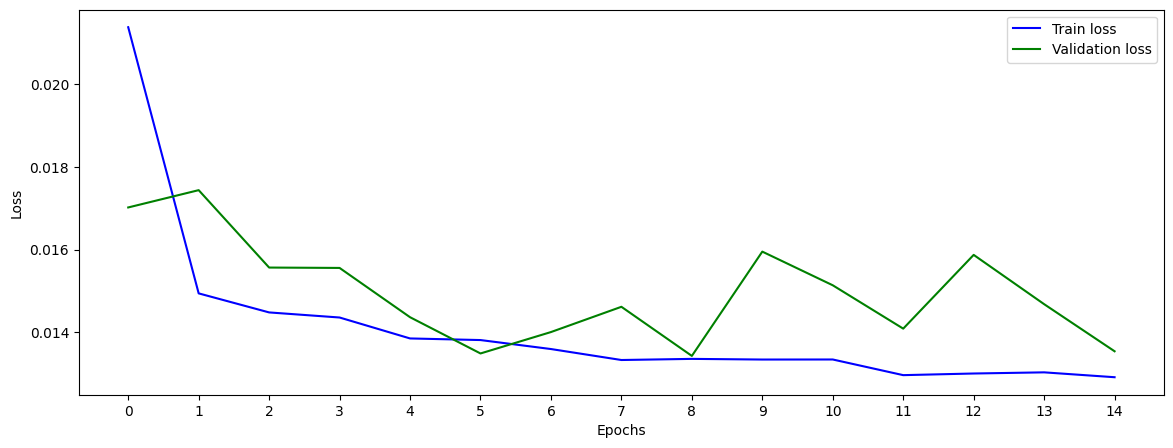

In [30]:
history = pd.read_csv('history/training-1-1.log')
cst.plot_losses(history, epochs)


From the plot above, we can observe that the train loss decreases monotonically while the validation loss does not show the same trend. For the first 5 epochs validation loss decreases, while it shows more fluctuations and a less stable trend from epoch 6, which seems to suggest that the model slightly overfits.

Evaluation on the test set

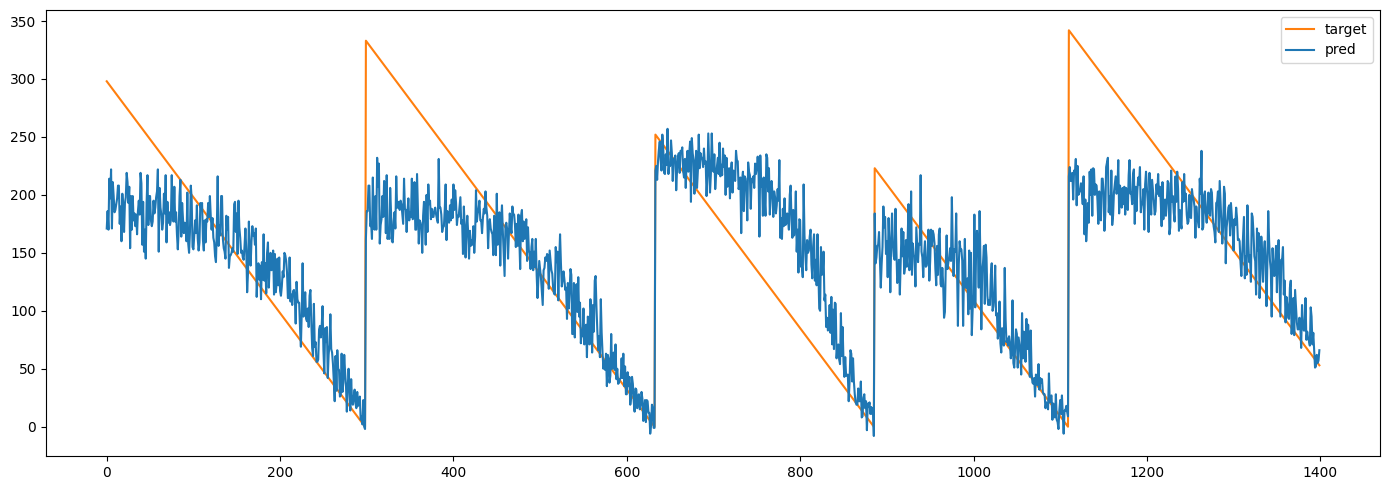

In [32]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

The plot suggests that the model succeeds in learning the final values of the RUL, while it struggles in predicting the starting values of the target RUL. Indeed, in this plot we can see that only in the case of the third machine, the model is able to guess quite precisely the initial values of RUL, but it shows in general a pattern which decreases slower than the target.

In [33]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0123
Standard Deviation of MSE: 0.0010


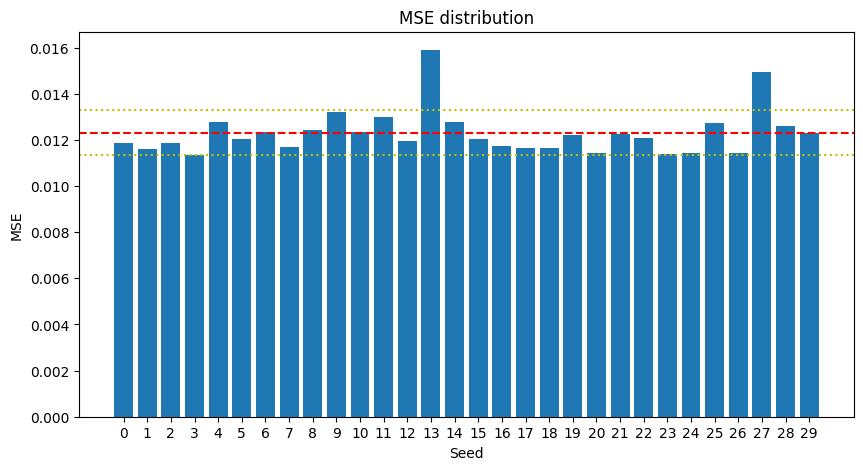

In [34]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [35]:
cst.save_results_to_excel("Task 1.1", mse_mean, mse_std, mse_seeds, excel_file_path)

In [36]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-1-1.xlsx')

In [41]:
pd.read_excel('./predictions/predictions-1-1.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0         171     197     192     185     178     190     183     169     188   
1         186     190     202     203     172     200     169     203     199   
2         170     190     185     188     177     188     183     177     188   
3         214     227     215     222     204     215     213     200     215   
4         197     217     226     204     203     217     195     188     223   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
15859       3       7       0       6       2      20      -5       4       9   
15860      18      16       4       5      12      22       0       6      23   
15861       9      11      -3       1       7      21      -9      -7      14   
15862       8       7      23      11      22      21      14      11      25   
15863      -4       9      22       3      -1      24       2      10      22   

       Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0         174  ...      194      174      183      187      183      195   
1         160  ...      189      176      201      198      170      219   
2         173  ...      189      166      181      180      178      187   
3         201  ...      211      191      215      212      211      216   
4         196  ...      222      191      206      199      215      211   
...       ...  ...      ...      ...      ...      ...      ...      ...   
15859      -4  ...       14       13        6        9        4       17   
15860      18  ...       20       14        4        9      -17        9   
15861       9  ...       12        5       -5        2      -25       -1   
15862       7  ...       26       22       12       20       23       16   
15863       8  ...       12        0        6        3        5        4   

       Seed_27  Seed_28  Seed_29  rul  
0          164      168      179  298  
1          151      177      166  297  
2          165      155      171  296  
3          193      188      204  295  
4          141      215      196  294  
...        ...      ...      ...  ...  
15859        2       21       19    4  
15860      -22       24       15    3  
15861      -42       20        9    2  
15862       16        7       20    1  
15863       -8        5        6    0  

[15864 rows x 31 columns]

#### 1.2 75% of supervised data used for training

In [38]:
trs_2 = cst.split_data(ts, trs=trs, trs_ratio=0.75)

Num. samples: 27559 (supervised), 15864 (test)


In [39]:
trs_s, vs_s, ts_s, trmaxrul = cst.standardize(trs_2, vs, ts, dt_in)

In [40]:
history, predictions = train_model(train_data=trs_s, val_data=vs_s, test_data=ts_s, columns=dt_in, 
                             maxrul=trmaxrul, alpha=1, beta=0, logger_file = 'training-1-2.log')

Epoch 1/15
921/921 [==============================] - 3s 3ms/step - loss: 0.0230 - mse: 0.0230 - cst: 0.0086 - val_loss: 0.0149 - val_mse: 0.0149 - val_cst: 0.0041
Epoch 2/15
921/921 [==============================] - 3s 4ms/step - loss: 0.0165 - mse: 0.0165 - cst: 0.0045 - val_loss: 0.0142 - val_mse: 0.0142 - val_cst: 0.0022
Epoch 3/15
921/921 [==============================] - 3s 3ms/step - loss: 0.0160 - mse: 0.0160 - cst: 0.0041 - val_loss: 0.0157 - val_mse: 0.0157 - val_cst: 0.0066
Epoch 4/15
921/921 [==============================] - 3s 3ms/step - loss: 0.0157 - mse: 0.0157 - cst: 0.0041 - val_loss: 0.0142 - val_mse: 0.0142 - val_cst: 0.0022
Epoch 5/15
921/921 [==============================] - 3s 3ms/step - loss: 0.0151 - mse: 0.0151 - cst: 0.0038 - val_loss: 0.0143 - val_mse: 0.0143 - val_cst: 0.0029
Epoch 6/15
921/921 [==============================] - 3s 3ms/step - loss: 0.0147 - mse: 0.0147 - cst: 0.0036 - val_loss: 0.0134 - val_mse: 0.0134 - val_cst: 0.0032
Epoch 7/15
921/9

Train history visualization for the first seed

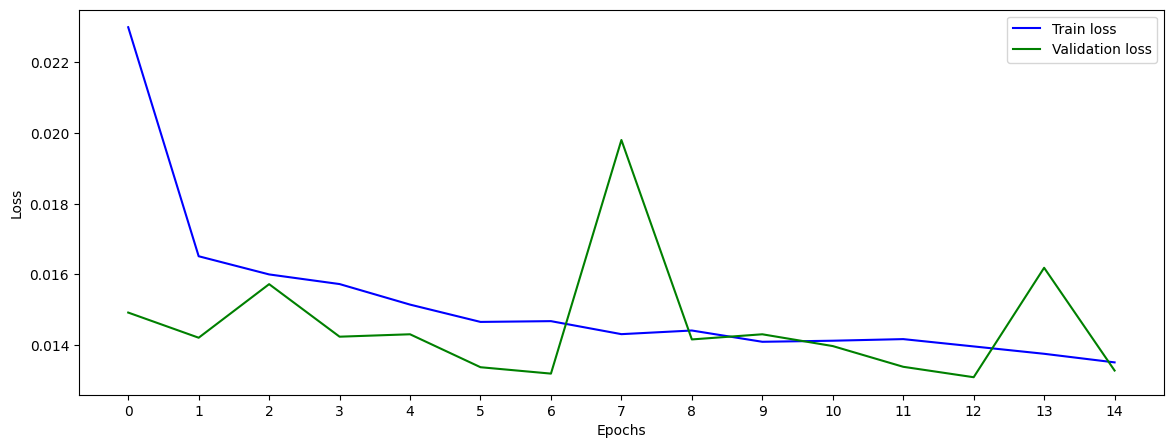

In [41]:
history = pd.read_csv('history/training-1-2.log')
cst.plot_losses(history, epochs)


The trend shown in this plot follows the previous one described in Task 1.1

Evaluation on the test set 

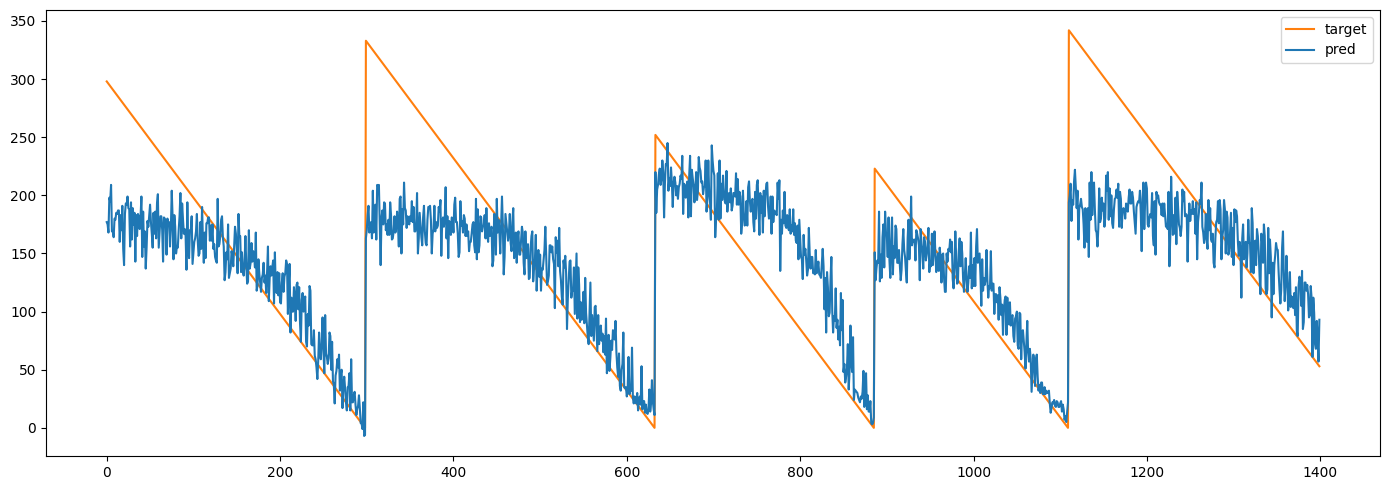

In [42]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

We can observe from this plot that the general trend is compliant with the one in Task 1.1, but initial RUL values seem to be slightly lower, and final ones are instead less accurate.

In [43]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0125
Standard Deviation of MSE: 0.0009


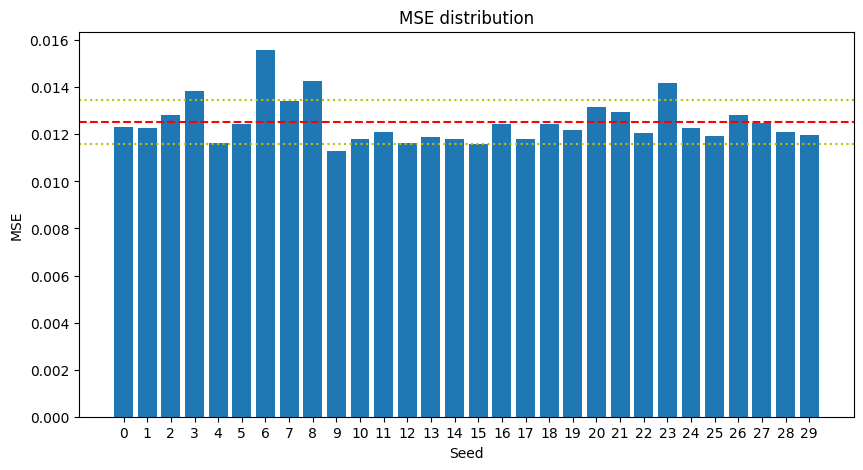

In [44]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [45]:
cst.save_results_to_excel("Task 1.2", mse_mean, mse_std, mse_seeds, excel_file_path)

In [46]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-1-2.xlsx')

In [42]:
pd.read_excel('./predictions/predictions-1-2.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0         177     172     216     154     196     166     151     169     172   
1         175     194     208     184     202     196     171     184     183   
2         168     164     209     153     184     169     147     175     179   
3         198     203     234     184     221     194     176     197     210   
4         195     177     181     183     180     164     148     139     121   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
15859      24       9      13      -1       5      22     -11      -1      -6   
15860       8      12      21       5       1      25       7      -2       0   
15861       4       4      13       3     -15      23      -4     -15      -8   
15862      22      12      26      10      10       9      -9       0       9   
15863       8       8      27      -8       3       9      -9      -5       1   

       Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0         198  ...      158      182      203      168      185      171   
1         208  ...      188      190      168      203      185      173   
2         186  ...      155      164      201      161      174      161   
3         223  ...      183      202      229      195      208      191   
4         221  ...      178      217      252      187      203      178   
...       ...  ...      ...      ...      ...      ...      ...      ...   
15859       3  ...       -1       -1       -1       14        6       23   
15860       6  ...       -5       -6       -6       12        0      -17   
15861      -4  ...      -22      -13      -23        0       -9      -33   
15862      14  ...        7       -1       15       23       20       23   
15863       5  ...       -9       -9       17        4       30       29   

       Seed_27  Seed_28  Seed_29  rul  
0          177      183      196  298  
1          180      190      176  297  
2          175      182      179  296  
3          206      204      214  295  
4          178      216      202  294  
...        ...      ...      ...  ...  
15859      -19       14       -2    4  
15860      -12       16        9    3  
15861      -30        9        6    2  
15862        9       -4        6    1  
15863        2       -1        3    0  

[15864 rows x 31 columns]

#### 1.3 50% of supervised data used for training

In [48]:
trs_3 = cst.split_data(ts, trs=trs, trs_ratio=0.50)

Num. samples: 18373 (supervised), 15864 (test)


In [49]:
trs_s, vs_s, ts_s, trmaxrul = cst.standardize(trs_3, vs, ts, dt_in)

In [50]:
history, predictions = train_model(train_data=trs_s, val_data=vs_s, test_data=ts_s, columns=dt_in, 
                             maxrul=trmaxrul, alpha=1, beta=0, logger_file = 'training-1-3.log')

Epoch 1/15
615/615 [==============================] - 3s 3ms/step - loss: 0.0243 - mse: 0.0243 - cst: 0.0106 - val_loss: 0.0184 - val_mse: 0.0184 - val_cst: 0.0036
Epoch 2/15
615/615 [==============================] - 2s 3ms/step - loss: 0.0157 - mse: 0.0157 - cst: 0.0044 - val_loss: 0.0198 - val_mse: 0.0198 - val_cst: 0.0035
Epoch 3/15
615/615 [==============================] - 2s 3ms/step - loss: 0.0156 - mse: 0.0156 - cst: 0.0043 - val_loss: 0.0159 - val_mse: 0.0159 - val_cst: 0.0025
Epoch 4/15
615/615 [==============================] - 2s 3ms/step - loss: 0.0145 - mse: 0.0145 - cst: 0.0038 - val_loss: 0.0138 - val_mse: 0.0138 - val_cst: 0.0034
Epoch 5/15
615/615 [==============================] - 2s 3ms/step - loss: 0.0143 - mse: 0.0143 - cst: 0.0038 - val_loss: 0.0139 - val_mse: 0.0139 - val_cst: 0.0029
Epoch 6/15
615/615 [==============================] - 2s 3ms/step - loss: 0.0142 - mse: 0.0142 - cst: 0.0037 - val_loss: 0.0132 - val_mse: 0.0132 - val_cst: 0.0020
Epoch 7/15
615/6

Train history visualization for the first seed

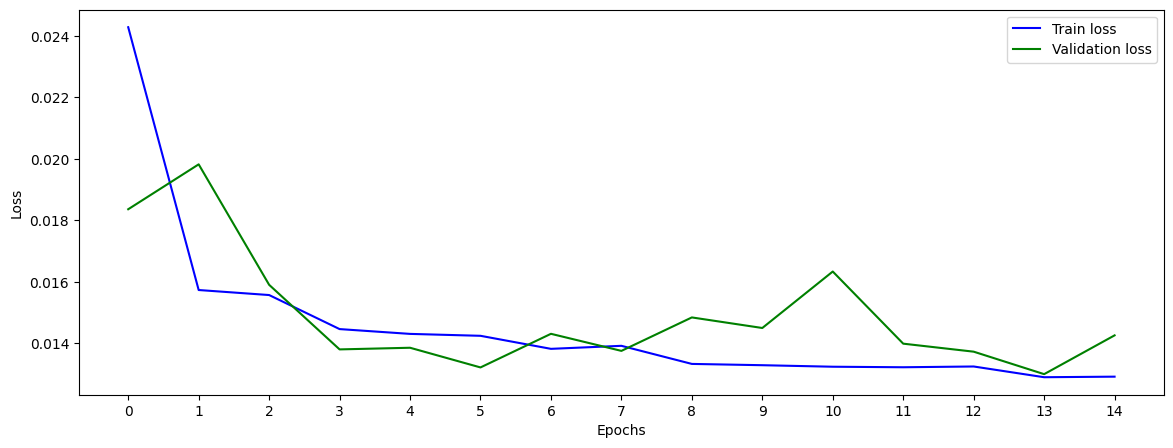

In [51]:
history = pd.read_csv('history/training-1-3.log')
cst.plot_losses(history, epochs)


The trend shown in this plot follows the previous ones described in Task 1.1 and 1.2

Evaluation on the test set

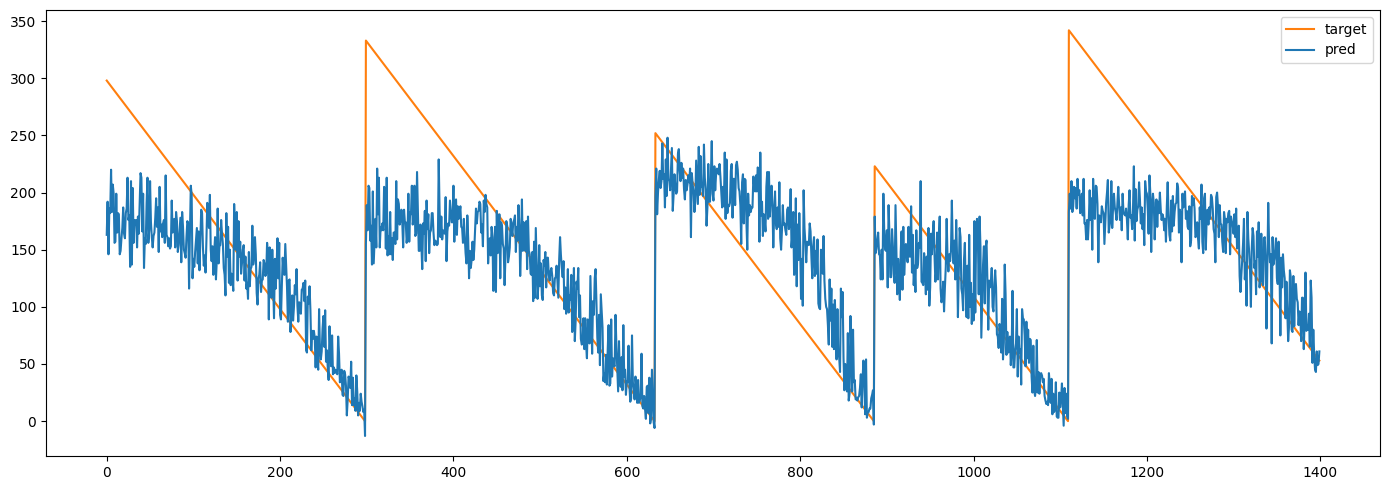

In [52]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

We can observe from this plot that the overall trend is compliant with the one in Task 1.1 and 1.2, but in general here we can spot more fluctuations in RUL values.

In [53]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0128
Standard Deviation of MSE: 0.0010


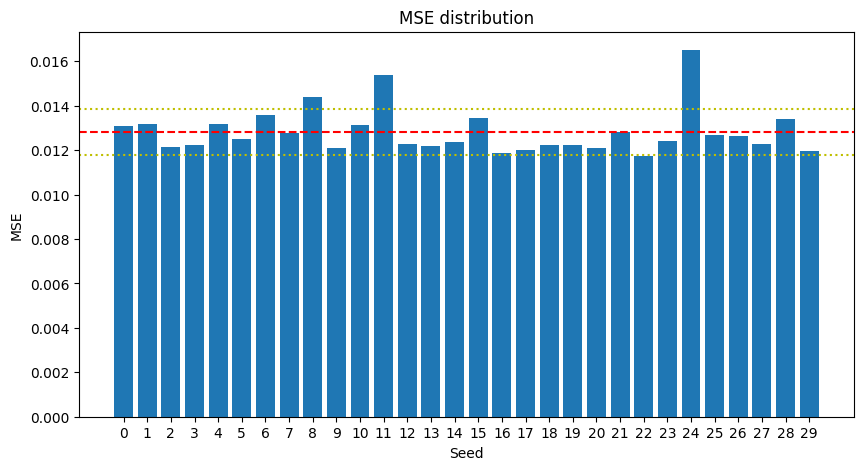

In [54]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [55]:
cst.save_results_to_excel("Task 1.3", mse_mean, mse_std, mse_seeds, excel_file_path)

In [56]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-1-3.xlsx')

In [43]:
pd.read_excel('./predictions/predictions-1-3.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0         163     178     173     183     162     169     195     163     141   
1         192     177     193     194     202     185     183     182     173   
2         146     168     167     182     159     170     179     175     152   
3         186     202     199     210     184     196     216     194     176   
4         182     168     202     213     183     199     242     179     180   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
15859      23      19       2      21       8      23     -22      12      -3   
15860      29      -1      21      26       3      22     -14      13       0   
15861      20     -10      12      17     -22      12     -26      -2     -14   
15862       8     -11      25      -4       5       7      -9      -3       0   
15863      -5       0      23       1      -5       5     -18       6       1   

       Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0         194  ...      164      190      196      145      171      170   
1         211  ...      199      193      182      162      176      199   
2         181  ...      160      180      180      142      164      164   
3         219  ...      188      213      207      176      197      194   
4         194  ...      210      211      197      166      181      160   
...       ...  ...      ...      ...      ...      ...      ...      ...   
15859       6  ...       10       15       17        1      -10       18   
15860      36  ...       31       18       26      -38       -6       35   
15861      16  ...        5        7       17      -53      -11       17   
15862      10  ...        0       12       12        0       -5        4   
15863       8  ...        0       15       18       -3        8       14   

       Seed_27  Seed_28  Seed_29  rul  
0          182      163      200  298  
1          187      177      198  297  
2          180      162      182  296  
3          212      191      220  295  
4          173      173      207  294  
...        ...      ...      ...  ...  
15859       -5        2       17    4  
15860       13       -3       12    3  
15861       -9      -12        9    2  
15862      -11      -19       16    1  
15863       -4       -4       16    0  

[15864 rows x 31 columns]

#### Results on Task 1


In [11]:
results_task1 = pd.read_excel('results.xlsx')

results_task1_1= results_task1[results_task1['Task'] == 'Task 1.1']
results_task1_2 = results_task1[results_task1['Task'] == 'Task 1.2']
results_task1_3 = results_task1[results_task1['Task'] == 'Task 1.3']

drop_columns = [col for col in results_task1_1.columns if 'Seed_' in col]

res_task1 = pd.concat([results_task1_1, results_task1_2, results_task1_3]).drop(columns=drop_columns)

print(tabulate(res_task1, headers='keys', showindex= False, tablefmt='psql'))

+----------+-----------+-------------+
| Task     |      Mean |         Std |
|----------+-----------+-------------|
| Task 1.1 | 0.0123038 | 0.000977068 |
| Task 1.2 | 0.0125143 | 0.000928641 |
| Task 1.3 | 0.0128224 | 0.00103055  |
+----------+-----------+-------------+


Task 1 uses only supervised data, as we expected the best model is the one that uses 100% of the data, but the other two don't have such worse performances. 
The mean of the *mse* metric is quite low, mainly because it is computed on standardized data. Indeed, if we observe closer the prediction  (non standardized) we observe that there is a quite great gap between the real rul value and the predicted one, especially at the beginning. 

In [105]:
# print predictions of the best model for the first machine
rul_values = pd.read_excel('./predictions/predictions-1-1.xlsx')
print(tabulate(rul_values[0:298], showindex= False, headers=rul_values.columns,  tablefmt='psql'))

+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------+
|   Seed_0 |   Seed_1 |   Seed_2 |   Seed_3 |   Seed_4 |   Seed_5 |   Seed_6 |   Seed_7 |   Seed_8 |   Seed_9 |   Seed_10 |   Seed_11 |   Seed_12 |   Seed_13 |   Seed_14 |   Seed_15 |   Seed_16 |   Seed_17 |   Seed_18 |   Seed_19 |   Seed_20 |   Seed_21 |   Seed_22 |   Seed_23 |   Seed_24 |   Seed_25 |   Seed_26 |   Seed_27 |   Seed_28 |   Seed_29 |   rul |
|----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-

We just printed the predictions for the first machine in the test set. These predictions are aligned with our initial expectations, as the model learns what we expected. Indeed, the model struggles more in predicting the initial *RUL* value, as it is close to the target value but always below it, while it succeeds in identfying 
the last values of the *RUL*, which are low and in general quite close to 0. In some cases, we observe that the predictions are negative, meaning that the model is not learning that the minimum admissible value for a *RUL* is 0. However, we can observe that the model understands well the decreasing trend that the *RUL* of a given machine must follow.

To conclude, the overall results are a rough approximation of the behavior expected, they are not perfect but in general the values are close to the right ones, and the trend they follow too. 

### **Task 2**: train the model with only unsupervised data. We will experiment with different ratios of unsupervised data. 


While training the models only with unsupervised data, we do not have great expectations. Indeed, using only unsupervised data there is no way the model can learn to predict the RUL. 
However, it is possible for the regressor to learn the constraint which imposes that the RUL for a machine should decrease. In comparison with the full supervised models, we expect that unsupervised models won't be able to predict the initial and final RUL values as accurately as the supervised models.
In general, we expect that the perormances will be worse with respect the superivised experiments.

In [60]:
tru, vs, ts = cst.split_machines(dt, 0, 0.75)

Num. machines: 149 (unsupervised), 37 (validation), 63 (test)


In [61]:
print(f'Num. samples: {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 36746 (unsupervised), 8639 (validation), 15864 (test)


For Task 2 we train the model only with unsupervised data. In this setting we do not have true RUL values therefore it is not possible to compute *mse* loss. As a conseguence, we used *cst* loss that enforces the model to follow a monotonic decreasing trend. For this reason we set *alpha* paarameter to 0 and *beta* to 1.

To address Task 2 we need to prepare our data by: 
* we remove the end of the unsupervised data sequences to simulate the fact that the machines are still operating
* we set RUL value to -1

#### 100% of unsupervised data

In [62]:
tru_s, vs_s, ts_s, trmaxrul = cst.standardize(tru, vs, ts, dt_in)

In [63]:
tru_st = cst.remove_rul(tru_s)

In [64]:
history, predictions = train_model(train_data=tru_st, val_data=vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=0, beta=1, logger_file = 'training-2-1.log')


Epoch 1/15
1079/1079 [==============================] - 3s 3ms/step - loss: 0.0048 - mse: 0.0000e+00 - cst: 0.0048 - val_loss: 5.8424e-04 - val_mse: 0.0283 - val_cst: 5.8424e-04
Epoch 2/15
1079/1079 [==============================] - 3s 3ms/step - loss: 4.6191e-04 - mse: 0.0000e+00 - cst: 4.6191e-04 - val_loss: 4.3882e-04 - val_mse: 0.0332 - val_cst: 4.3882e-04
Epoch 3/15
1079/1079 [==============================] - 3s 3ms/step - loss: 4.4966e-04 - mse: 0.0000e+00 - cst: 4.4966e-04 - val_loss: 4.2281e-04 - val_mse: 0.0378 - val_cst: 4.2281e-04
Epoch 4/15
1079/1079 [==============================] - 3s 3ms/step - loss: 4.6085e-04 - mse: 0.0000e+00 - cst: 4.6085e-04 - val_loss: 4.0145e-04 - val_mse: 0.0411 - val_cst: 4.0145e-04
Epoch 5/15
1079/1079 [==============================] - 3s 3ms/step - loss: 4.4337e-04 - mse: 0.0000e+00 - cst: 4.4337e-04 - val_loss: 5.1031e-04 - val_mse: 0.0452 - val_cst: 5.1031e-04
Epoch 6/15
1079/1079 [==============================] - 3s 3ms/step - loss: 4.

Train history visualization for the first seed

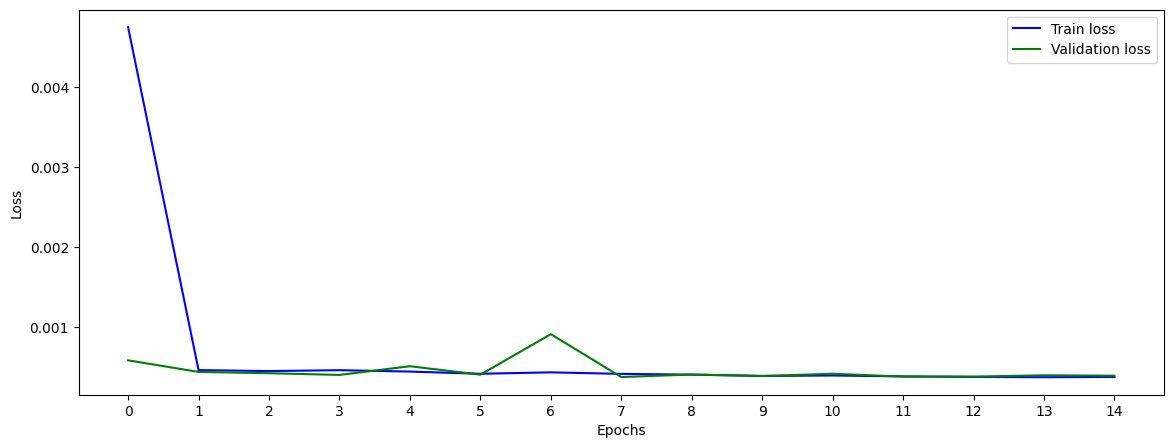

In [65]:
history = pd.read_csv('history/training-2-1.log')
cst.plot_losses(history, epochs)


We can observe from the previous plot that both validation and train loss are quite low and they often have overlapping values. 

Evaluation on the test set

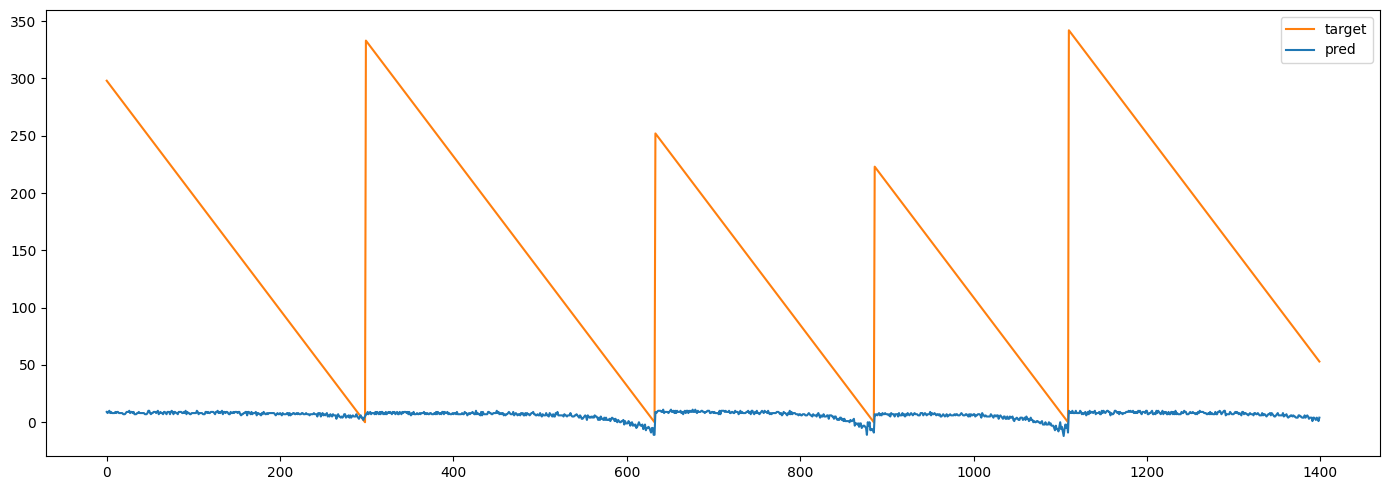

In [66]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

From the previous plot we observe that the values of the RUL are very different with respect to the target, as they lay always between 0 and 25. Since the scales of the two data are extremely different, we plot them in the following graph with *same_scale* parameter set to False in order to be able to spot and compare the general trend.

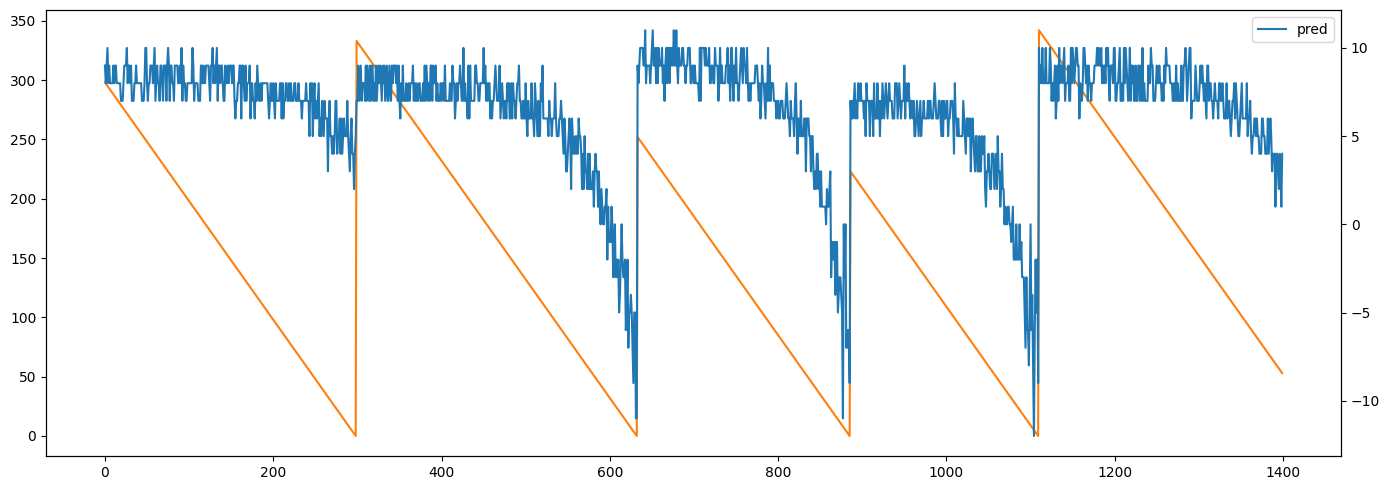

In [67]:
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

Looking at the scaled graph we can spot the trend of these predictions. The first values of the predictions lay on a plateau, meaning that the values have some fluctuations around the same values. Then, the values start decreasing and therefore the model roughly learn the decreasing trend of *RUL* values. Moreover, we can see that it is common that *RUL* predictions have a negative value.

In [68]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0843
Standard Deviation of MSE: 0.0111


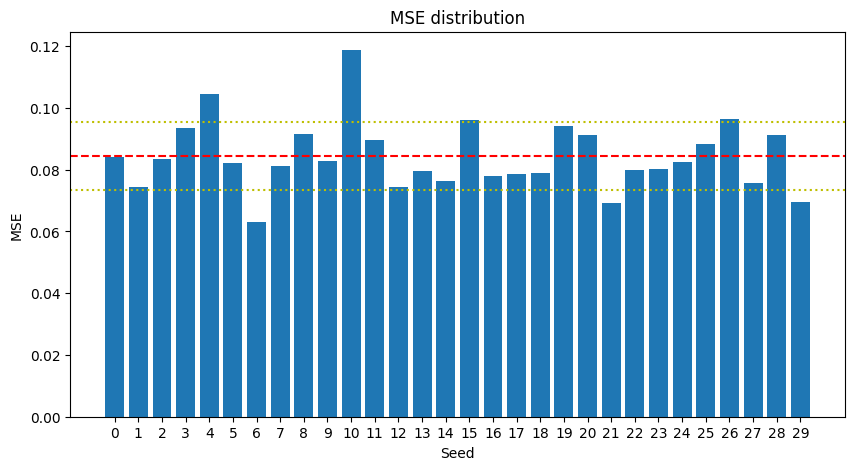

In [69]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

 Save results and predictions on excel files and show them

In [70]:
cst.save_results_to_excel("Task 2.1", mse_mean, mse_std, mse_seeds, excel_file_path)

In [71]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-2-1.xlsx')

In [3]:
pd.read_excel('./predictions/predictions-2-1.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0           9      22      11      -1     -14      12      35      11       1   
1           8      20       7       0     -12      12      33      13       0   
2           9      21      11      -2     -13      12      35      12       1   
3          10      23      12       0     -12      12      35      13       2   
4           8      23      11      -1     -11       8      37      12       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
15859      -6       2     -13     -21     -27      -8      28      -5     -14   
15860      -5       3      -7     -19     -31     -10      28      -1     -14   
15861      -9       0     -10     -21     -32     -11      26      -3     -17   
15862      -9       5      -6     -23     -24     -11      25      -1     -14   
15863     -14       4     -10     -26     -27     -11      24      -2     -13   

       Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0          11  ...       27       12       14       10        5       -4   
1          11  ...       26       14       13       11        5       -6   
2          10  ...       26       12       13       10        5       -4   
3          11  ...       28       13       14       11        6       -4   
4          10  ...       26       17       15       12        4       -4   
...       ...  ...      ...      ...      ...      ...      ...      ...   
15859      -9  ...       10       -5       -6       -5      -20      -23   
15860     -10  ...       16       -6       -3       -7      -16      -23   
15861     -16  ...       13       -9       -5      -11      -19      -26   
15862      -4  ...       15       -4       -3       -7       -9      -20   
15863     -10  ...       15        0       -7      -15      -20      -21   

       Seed_27  Seed_28  Seed_29  rul  
0           20        0       27  298  
1           20        0       27  297  
2           18        1       26  296  
3           20        1       28  295  
4           17        0       26  294  
...        ...      ...      ...  ...  
15859       -6      -24        9    4  
15860       -6      -22        9    3  
15861      -10      -26        6    2  
15862        5      -23       12    1  
15863        1      -27       10    0  

[15864 rows x 31 columns]

#### 75% of unsupervised data

In [73]:
tru_2 = cst.split_data(ts, tru=tru, tru_ratio=0.75)

Num. samples: 27559 (unsupervised), 15864 (test)


In [74]:
tru_s, vs_s, ts_s, trmaxrul = cst.standardize(tru_2, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)

In [75]:
history, predictions = train_model(train_data=tru_st, val_data=vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=0, beta=1, logger_file = 'training-2-2.log')

Epoch 1/15
812/812 [==============================] - 3s 3ms/step - loss: 0.0047 - mse: 0.0000e+00 - cst: 0.0047 - val_loss: 6.0758e-04 - val_mse: 0.0281 - val_cst: 6.0758e-04
Epoch 2/15
812/812 [==============================] - 3s 4ms/step - loss: 5.4668e-04 - mse: 0.0000e+00 - cst: 5.4668e-04 - val_loss: 5.6359e-04 - val_mse: 0.0315 - val_cst: 5.6359e-04
Epoch 3/15
812/812 [==============================] - 2s 3ms/step - loss: 5.0930e-04 - mse: 0.0000e+00 - cst: 5.0930e-04 - val_loss: 5.3276e-04 - val_mse: 0.0343 - val_cst: 5.3276e-04
Epoch 4/15
812/812 [==============================] - 3s 3ms/step - loss: 4.7721e-04 - mse: 0.0000e+00 - cst: 4.7721e-04 - val_loss: 0.0018 - val_mse: 0.0400 - val_cst: 0.0018
Epoch 5/15
812/812 [==============================] - 2s 3ms/step - loss: 4.9801e-04 - mse: 0.0000e+00 - cst: 4.9801e-04 - val_loss: 4.1714e-04 - val_mse: 0.0400 - val_cst: 4.1714e-04
Epoch 6/15
812/812 [==============================] - 2s 3ms/step - loss: 5.0994e-04 - mse: 0.00

Train history visualization for the first seed

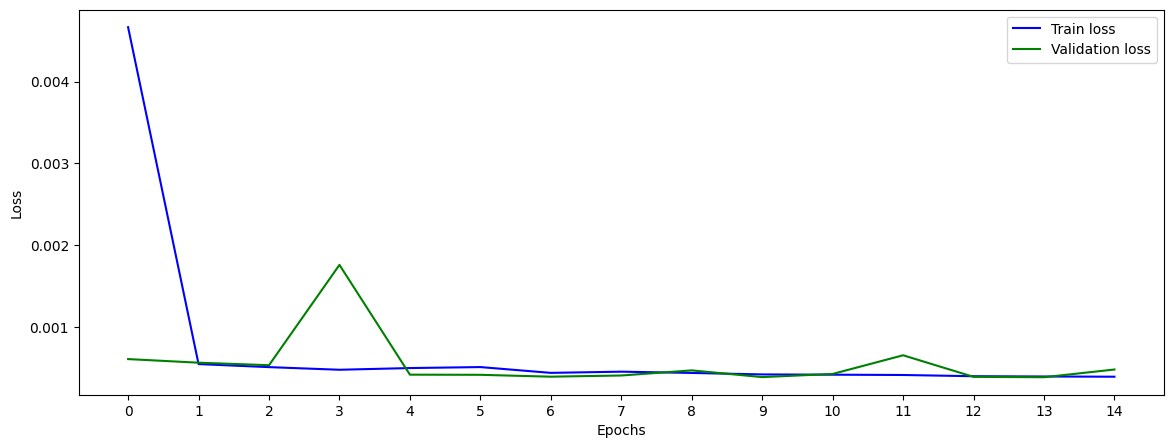

In [76]:
history = pd.read_csv('history/training-2-2.log')
cst.plot_losses(history, epochs)

The trend of the losses is very similar to the one previously discussed for Task 2.2

Evaluation on the test set

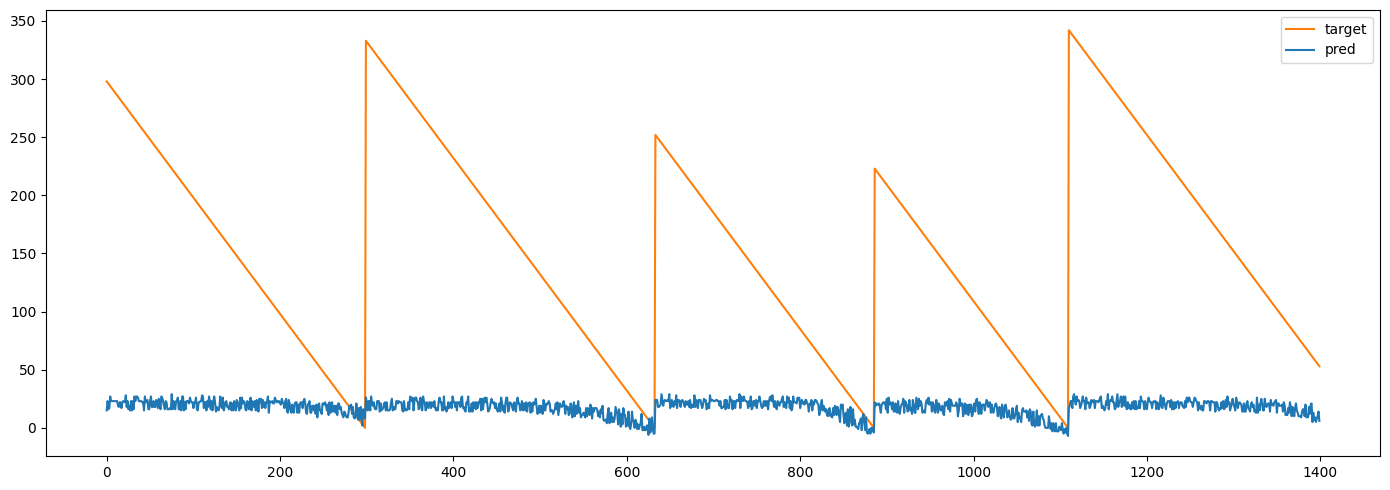

In [77]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

Similarly to Task 2.1, we notice that the values of the RUL are very different with respect to the target, as they lay always between 0 and 50. Since the scales of the two data are extremely different, we plot them in the following graph with *same_scale* parameter set to False in order to be able to spot and compare the general trend.

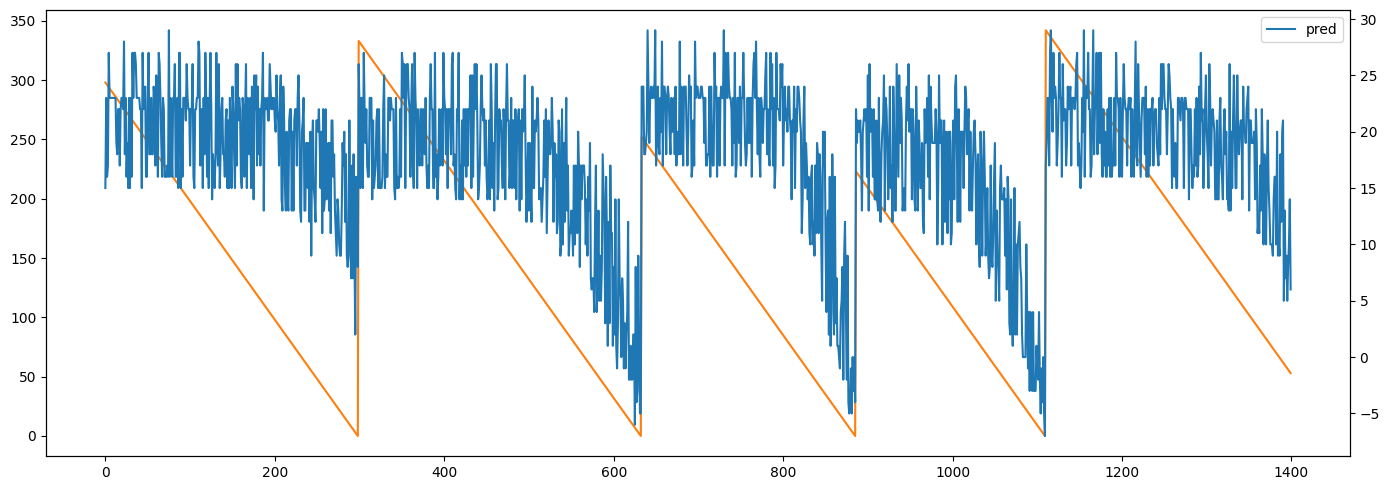

In [78]:
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

By studying this graph we first notice that there are a lot of fluctuations in prediction values. This, as we expected, is due to the fact that here we consider only 75% of unsupervised data, therefore the model has less example for learning the correct trend. <br>
As the previous experiment for Task 2.1, the first values of the predictions lay on a plateau, meaning that the values have some fluctuations around the same values. Then, towards the end of machine life the values start decreasing and therefore the model roughly learn the decreasing trend of *RUL* values. Also in this subtask it is common that *RUL* predictions are assigned to negative values.

In [79]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0842
Standard Deviation of MSE: 0.0146


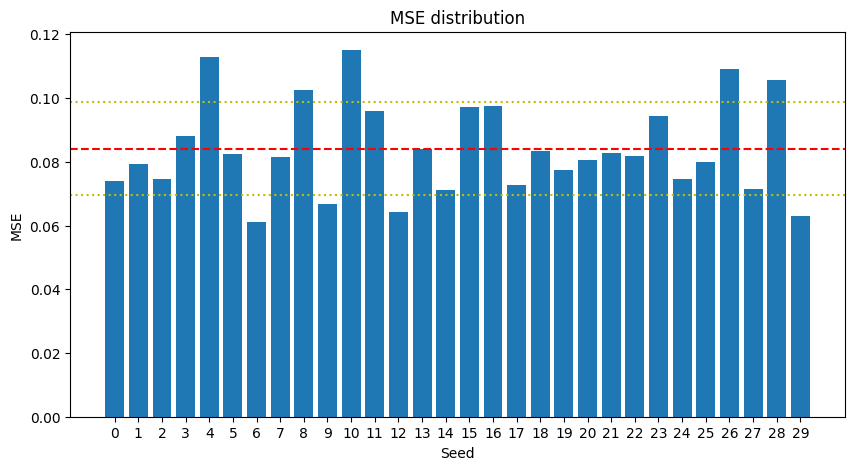

In [80]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [81]:
cst.save_results_to_excel("Task 2.2", mse_mean, mse_std, mse_seeds, excel_file_path)

In [82]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-2-2.xlsx')

In [4]:
pd.read_excel('./predictions/predictions-2-2.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0          15      13      21       5     -19      10      37      12     -12   
1          23      15      22       3     -18      14      40      14     -10   
2          16      13      20       4     -18       9      36      12     -12   
3          17      15      21       6     -18      11      38      13     -11   
4          27      17      21       9     -23      11      42      10     -10   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
15859      -1      -7      -7     -21     -39      -8      19      -6     -33   
15860       1      -1      -7     -17     -35      -5      25       1     -21   
15861      -4      -4      -9     -22     -37      -7      20      -1     -24   
15862      -6      -4      -3     -18     -37     -10      17      -5     -30   
15863      -6     -11      -6     -23     -43     -15      17       2     -31   

       Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0          30  ...       11       11       -2       19       12      -18   
1          30  ...       10       12        0       20       15      -16   
2          29  ...       11       11       -3       19       12      -18   
3          31  ...       12       12       -1       20       14      -16   
4          30  ...       13       14       -2       24       15      -16   
...       ...  ...      ...      ...      ...      ...      ...      ...   
15859       8  ...      -20       -8      -26       -4       -9      -35   
15860      15  ...       -7      -10      -25        2       -9      -40   
15861      10  ...      -15      -14      -28        0      -11      -45   
15862      16  ...      -10      -11      -24       -5       -6      -43   
15863      14  ...      -12       -8      -24        2       -8      -44   

       Seed_27  Seed_28  Seed_29  rul  
0           23      -14       36  298  
1           25      -13       34  297  
2           23      -15       35  296  
3           24      -14       37  295  
4           23      -13       35  294  
...        ...      ...      ...  ...  
15859       -3      -40       15    4  
15860        2      -38       20    3  
15861       -2      -43       18    2  
15862        4      -40       17    1  
15863        8      -42       19    0  

[15864 rows x 31 columns]

#### 50% of unsupervised

In [84]:
tru_3 = cst.split_data(ts, tru=tru, tru_ratio=0.50)

Num. samples: 18373 (unsupervised), 15864 (test)


In [85]:
tru_s, vs_s, ts_s, trmaxrul = cst.standardize(tru_3, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)

In [86]:
history, predictions = train_model(train_data=tru_st, val_data=vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=0, beta=1, logger_file = 'training-2-3.log')

Epoch 1/15
541/541 [==============================] - 2s 3ms/step - loss: 0.0072 - mse: 0.0000e+00 - cst: 0.0072 - val_loss: 5.7786e-04 - val_mse: 0.0280 - val_cst: 5.7786e-04
Epoch 2/15
541/541 [==============================] - 1s 3ms/step - loss: 4.8538e-04 - mse: 0.0000e+00 - cst: 4.8538e-04 - val_loss: 4.9844e-04 - val_mse: 0.0289 - val_cst: 4.9844e-04
Epoch 3/15
541/541 [==============================] - 2s 3ms/step - loss: 4.4765e-04 - mse: 0.0000e+00 - cst: 4.4765e-04 - val_loss: 4.9353e-04 - val_mse: 0.0298 - val_cst: 4.9353e-04
Epoch 4/15
541/541 [==============================] - 1s 3ms/step - loss: 4.5155e-04 - mse: 0.0000e+00 - cst: 4.5155e-04 - val_loss: 4.3910e-04 - val_mse: 0.0326 - val_cst: 4.3910e-04
Epoch 5/15
541/541 [==============================] - 2s 3ms/step - loss: 4.2665e-04 - mse: 0.0000e+00 - cst: 4.2665e-04 - val_loss: 4.3038e-04 - val_mse: 0.0356 - val_cst: 4.3038e-04
Epoch 6/15
541/541 [==============================] - 2s 3ms/step - loss: 4.2529e-04 - m

Train history visualization for the first seed

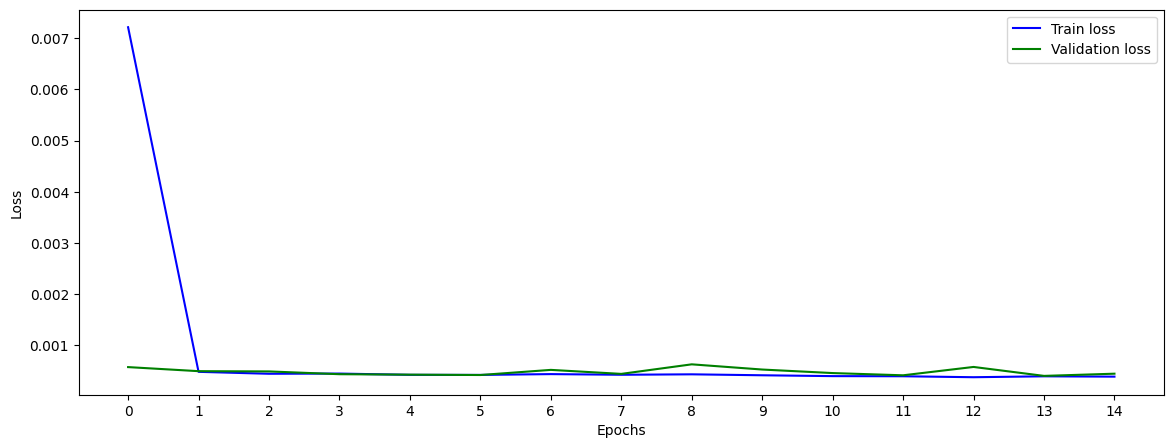

In [87]:
history = pd.read_csv('history/training-2-3.log')
cst.plot_losses(history, epochs)


Both validation and train loss follow the previously mentioned trend.

Evaluation on the test set

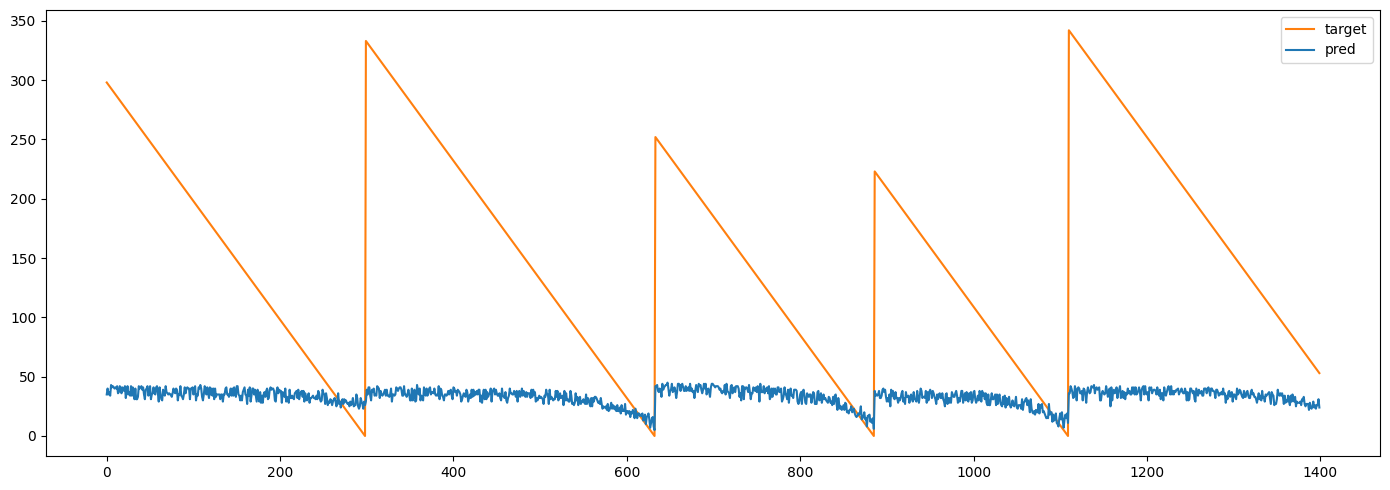

In [90]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

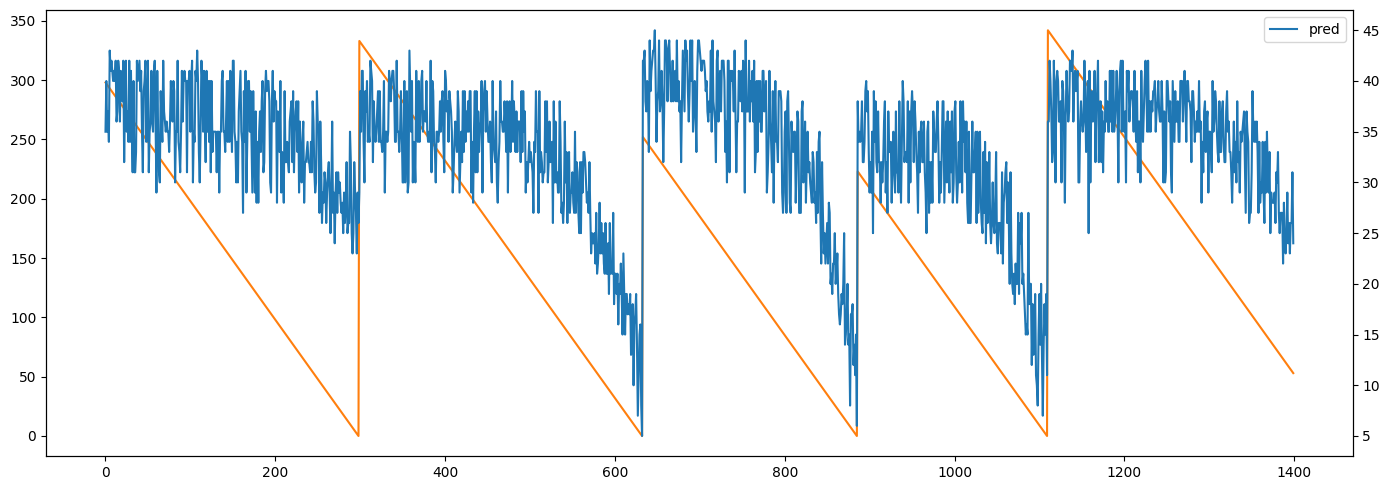

In [91]:
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

This two plots show a very similar trend to Task 2.1 and 2.2, therefore the same considerations can be made. 

In [92]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0937
Standard Deviation of MSE: 0.0637


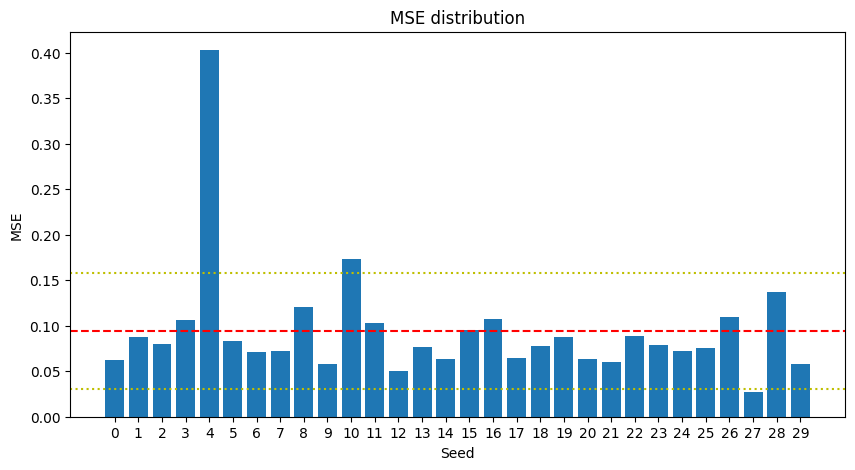

In [93]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

 Save results and predictions on excel files and show them

In [94]:
cst.save_results_to_excel("Task 2.3", mse_mean, mse_std, mse_seeds, excel_file_path)

In [95]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-2-3.xlsx')

In [5]:
pd.read_excel('./predictions/predictions-2-3.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0          35       5      15     -12    -193      16      25      21     -27   
1          40       9      14     -12    -196       8      25      26     -25   
2          35       6      14     -13    -193      14      25      22     -27   
3          37       7      17     -11    -196      16      26      23     -26   
4          34       4      15     -10    -189      12      27      24     -25   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
15859      13     -18     -17     -41    -227     -12       8       5     -44   
15860      16      -9      -7     -37    -218      -8      10       5     -42   
15861       9     -13     -12     -40    -222     -12       4       2     -42   
15862      13     -13      -9     -45    -216      -7      10       0     -38   
15863       5     -14     -14     -48    -233     -13       6      -2     -40   

       Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0          44  ...       41        4       17       23       19      -17   
1          44  ...       43        6       15       23       20      -16   
2          44  ...       40        4       16       22       18      -18   
3          45  ...       42        6       17       24       20      -16   
4          43  ...       41        1       18       25       21      -17   
...       ...  ...      ...      ...      ...      ...      ...      ...   
15859      20  ...       22      -17       -8        1       -2      -33   
15860      25  ...       22      -10       -9        5        0      -34   
15861      20  ...       17      -12      -11        3       -3      -37   
15862      33  ...       18      -17       -1        7       -4      -34   
15863      27  ...       17      -15        1        7       -5      -36   

       Seed_27  Seed_28  Seed_29  rul  
0          121      -43       43  298  
1          116      -42       46  297  
2          123      -43       42  296  
3          126      -42       43  295  
4          111      -34       38  294  
...        ...      ...      ...  ...  
15859       77      -66       25    4  
15860       87      -61       34    3  
15861       82      -64       31    2  
15862       88      -65       28    1  
15863       81      -68       28    0  

[15864 rows x 31 columns]

#### Results on Task 2

In [9]:
results_task2 = pd.read_excel('results.xlsx')

# tieni solo task 2.1 e 2.2
results_task2_1= results_task2[results_task2['Task'] == 'Task 2.1']
results_task2_2 = results_task2[results_task2['Task'] == 'Task 2.2']
results_task2_3 = results_task2[results_task2['Task'] == 'Task 2.3']

res_task2 = pd.concat([results_task2_1, results_task2_2, results_task2_3]).drop(columns=drop_columns)

print(tabulate(res_task2, headers='keys', showindex= False, tablefmt='psql'))

+----------+-----------+-----------+
| Task     |      Mean |       Std |
|----------+-----------+-----------|
| Task 2.1 | 0.0843178 | 0.0110605 |
| Task 2.2 | 0.0841617 | 0.0145537 |
| Task 2.3 | 0.0936787 | 0.0636977 |
+----------+-----------+-----------+


From what we can see from the previous table, there is a great difference in terms of *mse* between Task 2.1/2.2 and Task 2.3 as the first two has lower mean *mse* value with respect to the last one. This is can be due to the fact that with our current setup 75% of unsuperviused data is enough to supply the model with enough information, but 50% is to low.

In [104]:
# print predictions of the best model for the first machine
rul_values = pd.read_excel('./predictions/predictions-2-2.xlsx')
print(tabulate(rul_values[0:298], showindex= False, headers=rul_values.columns,  tablefmt='psql'))


+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------+
|   Seed_0 |   Seed_1 |   Seed_2 |   Seed_3 |   Seed_4 |   Seed_5 |   Seed_6 |   Seed_7 |   Seed_8 |   Seed_9 |   Seed_10 |   Seed_11 |   Seed_12 |   Seed_13 |   Seed_14 |   Seed_15 |   Seed_16 |   Seed_17 |   Seed_18 |   Seed_19 |   Seed_20 |   Seed_21 |   Seed_22 |   Seed_23 |   Seed_24 |   Seed_25 |   Seed_26 |   Seed_27 |   Seed_28 |   Seed_29 |   rul |
|----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-

Task 2, differentlty from Task 1, uses only unsupervised data. Meaning that there is no information on the RUL while training the models. For this reason, as already mentioned, we expected that the model struggles in learning the initial and final values of the remaining useful life of the machines, but it should be able to at least guess the right decreasing trend.

As a matter of fact, in comparison to Task 1:
-  the initial values of Task 1 are higher than those of Task 2: for the first one the values are more closer to the right initial RUL (near 200), for the second task they are far more different, as the maximum initial value is around 50
- the final values of Task 1 are closer to 0 than those of Task 2: the latter often have a lot of negative values and rarely ends with a 0.

Even if the final considerations seems to favor supervised data, some useful information can be still extracted from unsupervised data regarding the decreasing trend of remaining useful life. 


### **Task 3**: train the model with both supervised and unsupervised data. We will experiment with different ratios of unsupervised and supervised data. 


We expect that the performances of models trained with both supervised and unsupervied data will lay in between those of the models trained just with supervised data and the models trained with only unsupervised data, meaning that they will have better performances wrt the unsupervised models, but worse than those of fully supervised models. Moreover, changing the ratio will greatly influence the performances of the models.
We will study the 16 combinations of 100, 75, 50, 25 supervised and 100, 75, 50, 25 unsupervised. 

- a) increasing the number of supervised samples (25%, 50%, 100%), with fixed unsupervised samples, will lead to a more performing model
- b) increasing the number of unsupervised samples (25%, 50%, 100%), with fixed supervised samples, will lead to a less improvement in the performances with respect to a.
- c) greater number of supervised with respect to the unsupervised samples, will lead to better performances
- d) greater number of unsupervised with respect to the supervised samples, will lead to worse performances

In [15]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


For this Task we train the model with both supervised and unsupervised data. As a consequence, we choose to train our model with a **combined loss** which takes this into account: we set *alpha* and *beta* parameters to 1. In this way, the final loss will receive the contribution of both *mse* loss and *cst* loss. 

##### 3.1 100% unsupervised, 100% supervised

In [107]:
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 27824 (supervised), 14813 (unsupervised), 15864 (validation), 2748 (test)


In [108]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [109]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-1.log')

Epoch 1/15
1373/1373 [==============================] - 5s 3ms/step - loss: 0.0223 - mse: 0.0174 - cst: 0.0049 - val_loss: 0.0198 - val_mse: 0.0182 - val_cst: 0.0016
Epoch 2/15
1373/1373 [==============================] - 5s 3ms/step - loss: 0.0144 - mse: 0.0124 - cst: 0.0020 - val_loss: 0.0166 - val_mse: 0.0152 - val_cst: 0.0014
Epoch 3/15
1373/1373 [==============================] - 4s 3ms/step - loss: 0.0138 - mse: 0.0117 - cst: 0.0021 - val_loss: 0.0160 - val_mse: 0.0144 - val_cst: 0.0016
Epoch 4/15
1373/1373 [==============================] - 4s 3ms/step - loss: 0.0135 - mse: 0.0114 - cst: 0.0021 - val_loss: 0.0153 - val_mse: 0.0136 - val_cst: 0.0017
Epoch 5/15
1373/1373 [==============================] - 4s 3ms/step - loss: 0.0134 - mse: 0.0114 - cst: 0.0020 - val_loss: 0.0166 - val_mse: 0.0140 - val_cst: 0.0026
Epoch 6/15
1373/1373 [==============================] - 4s 3ms/step - loss: 0.0131 - mse: 0.0111 - cst: 0.0020 - val_loss: 0.0172 - val_mse: 0.0145 - val_cst: 0.0027
Epoc

Train history visualization for the first seed

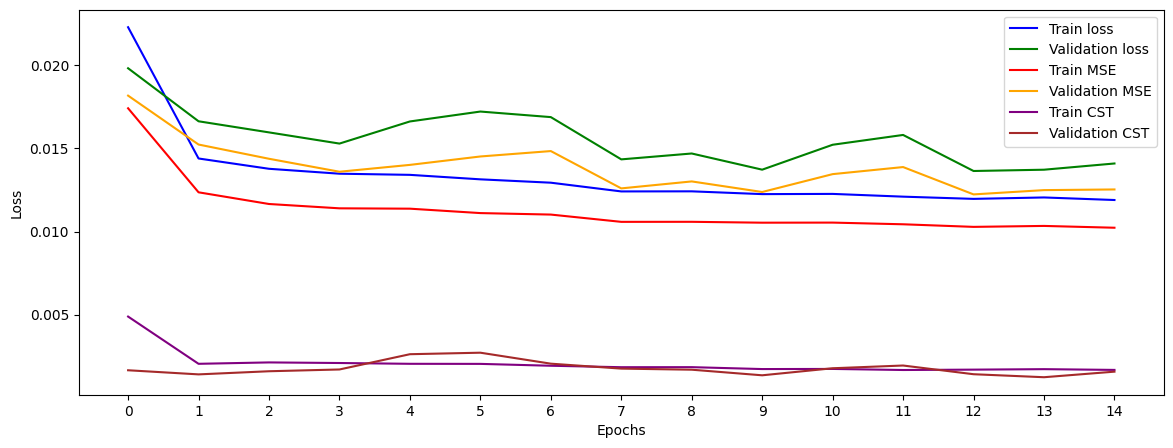

In [110]:
history = pd.read_csv('history/training-3-1.log')
cst.plot_losses_mixed(history, epochs)


Observing the plot we can see that all values are quite low. <br>
In particular, *cst* loss for both train and validation is the lowest, but it is pretty stable and it does not decreases a lot. <br>
The other train losses have a more decreasing trend, that becomes more stable after few epochs. <br>
Validation losses are in general higher that train ones, but they still have a decresaing trend (enìven if it is not strictly monotonic).

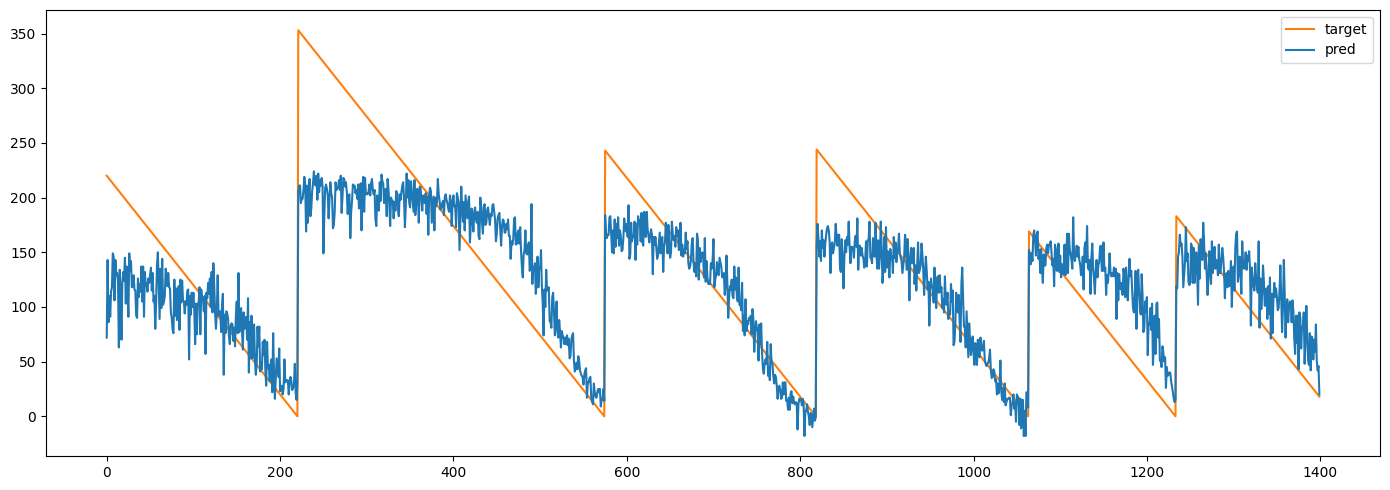

In [111]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

Observing the plot, inital values are often mispredicted and have lower values wrt the true initial RUL. Anyway, they learn the decresing trend of the RUL.

In [112]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0110
Standard Deviation of MSE: 0.0008


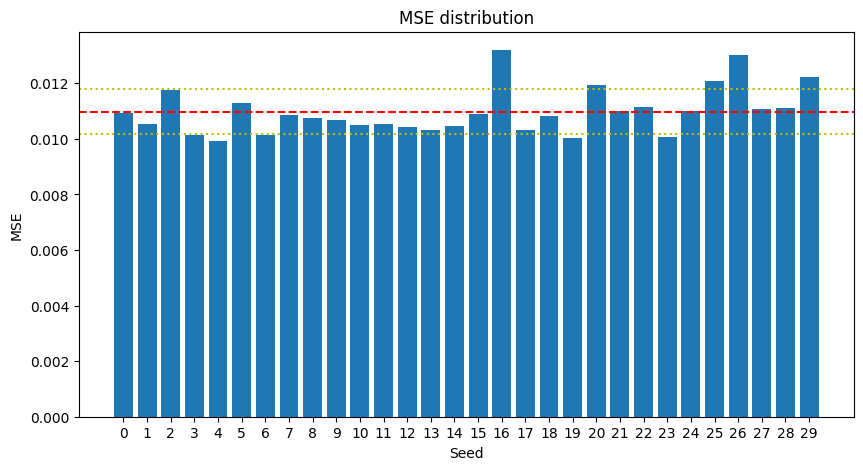

In [113]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [114]:
cst.save_results_to_excel("Task 3.1", mse_mean, mse_std, mse_seeds, excel_file_path)

In [115]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-1.xlsx')

In [10]:
pd.read_excel('./predictions/predictions-3-1.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0         72     102      82     102      88      70     110      98      94   
1        143     138     120     146     147     130     142     145     144   
2         86     115      95     120      99      78     127     110     108   
3        110     108      56     120      99     108     116     111     133   
4         91     122     103     129     111      84     128     112     109   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2743       4      29      11      15     -11      12      19      10      19   
2744       2      20     -17       0       8      11       3      32      16   
2745      14      26      -1      13     -12      10      17      13      14   
2746       9      21     -10       2       4      13      13      30      25   
2747       3      30      -5      19      16      23       6      16      31   

      Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0        108  ...       78       96      118       61       77       84   
1        137  ...      130      136      135      129      127      124   
2        120  ...       96      105      135       75       90       99   
3        106  ...       88      107       98      101      133       61   
4        123  ...      100      114      141       78       95      105   
...      ...  ...      ...      ...      ...      ...      ...      ...   
2743      23  ...        6       17       10       13       25       19   
2744      21  ...       10       23       18       16       -8        6   
2745      19  ...        0        5      -11        9       -1        5   
2746      24  ...        3       24       20       20       -1        2   
2747      32  ...        8       31       15       24       19       -4   

      Seed_27  Seed_28  Seed_29  rul  
0         109      110       73  220  
1         136      142      119  219  
2         117      118       87  218  
3          87      104       81  217  
4         123      121       98  216  
...       ...      ...      ...  ...  
2743       14       29        8    4  
2744       24       45        2    3  
2745        4       -4       -3    2  
2746       20       50       12    1  
2747       16       30        8    0  

[2748 rows x 31 columns]

##### 3.2 100% unsupervised, 75% supervised

In [117]:
ratio_sup = 0.75 
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 20868 (supervised), 14813 (unsupervised), 15864 (validation), 2748 (test)


In [118]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [119]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-2.log')

Epoch 1/15
1137/1137 [==============================] - 4s 3ms/step - loss: 0.0205 - mse: 0.0163 - cst: 0.0042 - val_loss: 0.0199 - val_mse: 0.0183 - val_cst: 0.0015
Epoch 2/15
1137/1137 [==============================] - 4s 4ms/step - loss: 0.0143 - mse: 0.0122 - cst: 0.0021 - val_loss: 0.0172 - val_mse: 0.0158 - val_cst: 0.0014
Epoch 3/15
1137/1137 [==============================] - 3s 3ms/step - loss: 0.0131 - mse: 0.0112 - cst: 0.0019 - val_loss: 0.0151 - val_mse: 0.0136 - val_cst: 0.0016
Epoch 4/15
1137/1137 [==============================] - 4s 3ms/step - loss: 0.0126 - mse: 0.0106 - cst: 0.0020 - val_loss: 0.0149 - val_mse: 0.0136 - val_cst: 0.0013
Epoch 5/15
1137/1137 [==============================] - 4s 3ms/step - loss: 0.0120 - mse: 0.0102 - cst: 0.0018 - val_loss: 0.0157 - val_mse: 0.0134 - val_cst: 0.0023
Epoch 6/15
1137/1137 [==============================] - 4s 3ms/step - loss: 0.0120 - mse: 0.0102 - cst: 0.0019 - val_loss: 0.0164 - val_mse: 0.0151 - val_cst: 0.0012
Epoc

Train history visualization for the first seed

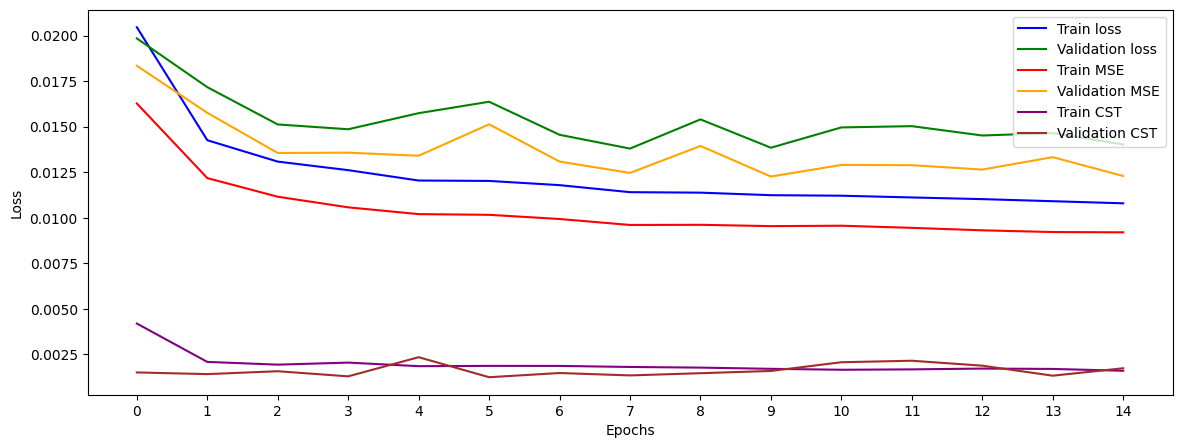

In [120]:
history = pd.read_csv('history/training-3-2.log')
cst.plot_losses_mixed(history, epochs)


This plot follows the same considerations of the previous subtask.

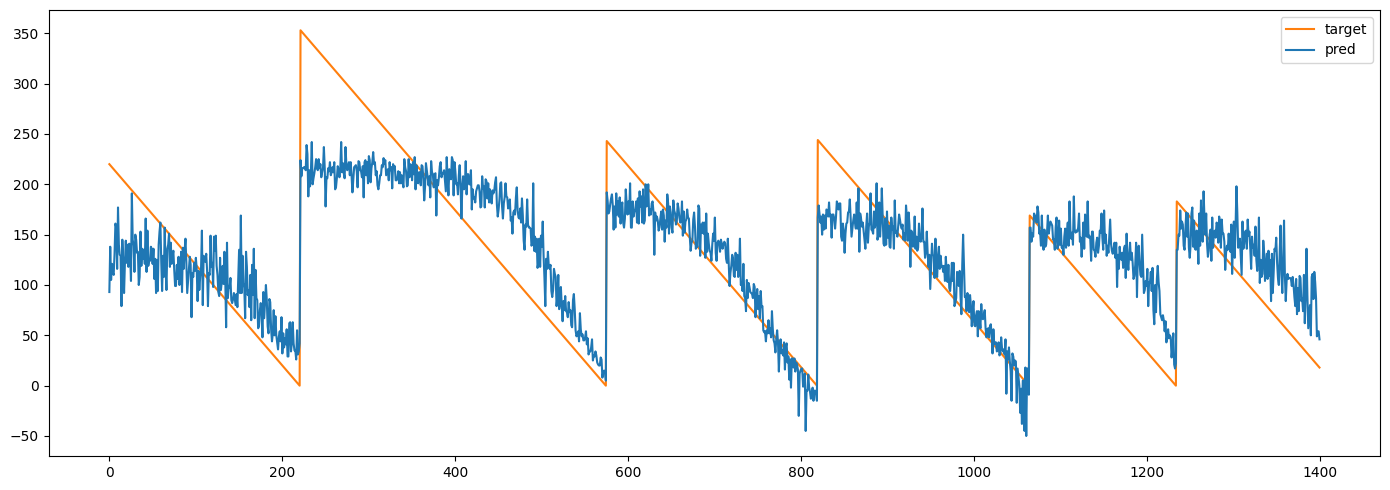

In [121]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

For this graph, we can make the same considerations done for the previous subtask. 


In [122]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0109
Standard Deviation of MSE: 0.0005


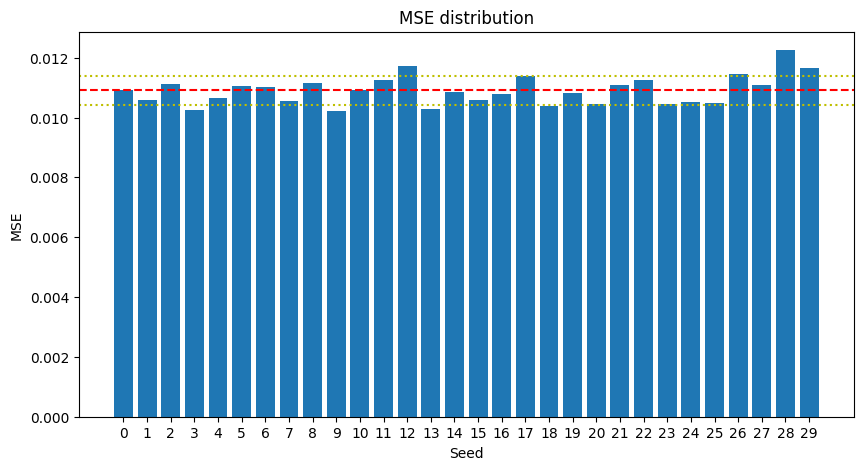

In [123]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [124]:
cst.save_results_to_excel("Task 3.2", mse_mean, mse_std, mse_seeds, excel_file_path)

In [125]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-2.xlsx')

In [11]:
pd.read_excel('./predictions/predictions-3-2.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0         93     103     107     121      93     101     113     123      88   
1        138     159     170     145     158     137     149     138     126   
2        105     115     124     144     109     108     130     136     103   
3        121     133     134     121     128     111     150     120      81   
4        112     122     132     151     119     116     133     138     108   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2743      31      29      19      16      14      12      14      19      21   
2744      -7       5      12      -5      17      -6       3      34      13   
2745      22      18      18      13     -11      13       9      14      16   
2746       7       7      15       3      15      -3      18      39      10   
2747      23      38      17      28      20      22      25      36      17   

      Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0        103  ...       90      123      103      133       99       87   
1        128  ...      116      149      139      150      141      132   
2        119  ...      109      134      118      148      114       99   
3        110  ...      107      129      100      112      109      104   
4        123  ...      115      141      124      153      118      110   
...      ...  ...      ...      ...      ...      ...      ...      ...   
2743       1  ...        1       32       19       33       19        8   
2744      24  ...      -12        2        8       27       -4       23   
2745      -8  ...      -28       14        3       21       -2       -6   
2746      26  ...      -18       12        1       33       -4       13   
2747      19  ...       -6       39       22       25       16       27   

      Seed_27  Seed_28  Seed_29  rul  
0          86       78      127  220  
1         141      129      155  219  
2          94       90      145  218  
3         116      101      124  217  
4          96       93      151  216  
...       ...      ...      ...  ...  
2743       13       31       18    4  
2744       14        2       21    3  
2745        6       -9       30    2  
2746        9       11       37    1  
2747       15       19       20    0  

[2748 rows x 31 columns]

##### 3.3 100% unsupervised, 50% supervised

In [127]:
ratio_sup = 0.50
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 10434 (supervised), 14813 (unsupervised), 2748 (test)


In [128]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [129]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-3.log')

Epoch 1/15
787/787 [==============================] - 3s 3ms/step - loss: 0.0152 - mse: 0.0103 - cst: 0.0049 - val_loss: 0.0231 - val_mse: 0.0220 - val_cst: 0.0012
Epoch 2/15
787/787 [==============================] - 2s 3ms/step - loss: 0.0091 - mse: 0.0076 - cst: 0.0015 - val_loss: 0.0239 - val_mse: 0.0227 - val_cst: 0.0012
Epoch 3/15
787/787 [==============================] - 2s 3ms/step - loss: 0.0084 - mse: 0.0069 - cst: 0.0015 - val_loss: 0.0170 - val_mse: 0.0156 - val_cst: 0.0014
Epoch 4/15
787/787 [==============================] - 2s 3ms/step - loss: 0.0081 - mse: 0.0066 - cst: 0.0015 - val_loss: 0.0219 - val_mse: 0.0188 - val_cst: 0.0031
Epoch 5/15
787/787 [==============================] - 2s 3ms/step - loss: 0.0080 - mse: 0.0064 - cst: 0.0016 - val_loss: 0.0169 - val_mse: 0.0160 - val_cst: 8.9852e-04
Epoch 6/15
787/787 [==============================] - 2s 3ms/step - loss: 0.0078 - mse: 0.0064 - cst: 0.0014 - val_loss: 0.0158 - val_mse: 0.0147 - val_cst: 0.0011
Epoch 7/15
7

Train history visualization for the first seed

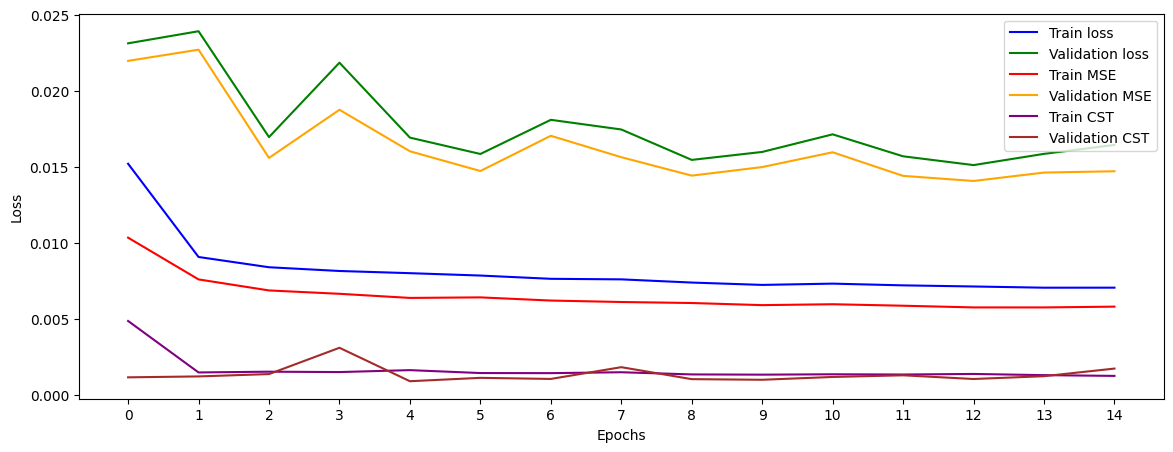

In [130]:
history = pd.read_csv('history/training-3-3.log')
cst.plot_losses_mixed(history, epochs)


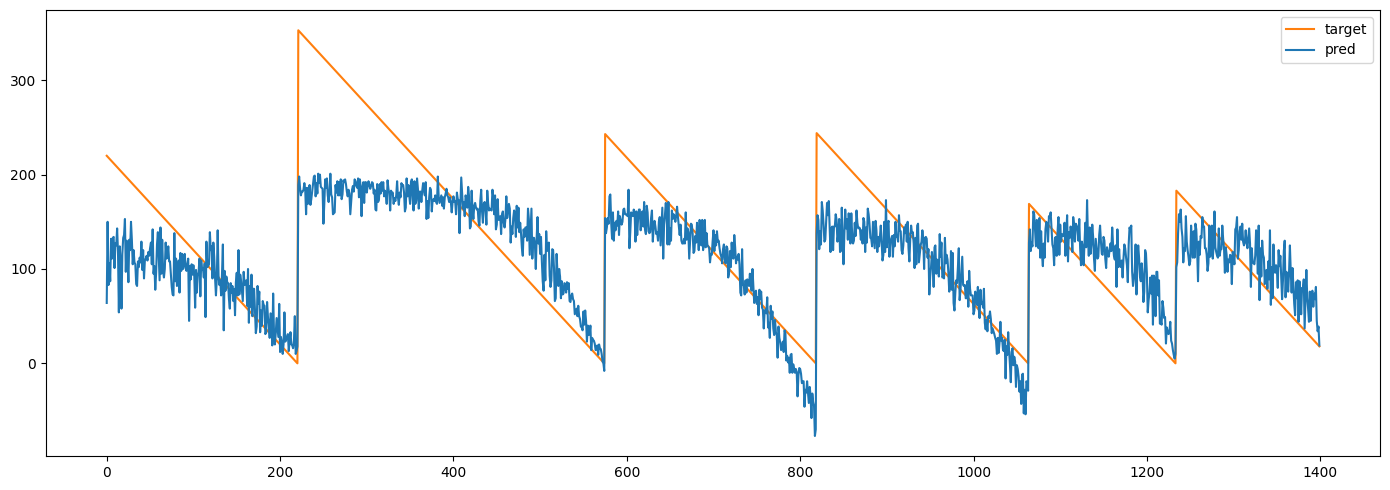

In [131]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

Differently from the previous esperiments on Task 3, here we have a significant decrease in terms of performances as the model often predicts negative values. <br>
The inital and final values are mispredicted, but the decreasing trend is correctly learnt. This is compliant to the fact that we reduced supervided data, while keeping constant unsupervided data. 

In [132]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0125
Standard Deviation of MSE: 0.0008


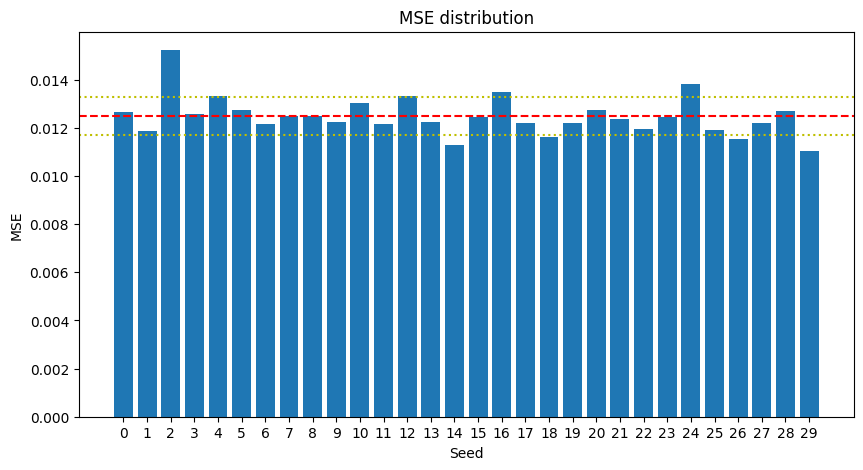

In [133]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [134]:
cst.save_results_to_excel("Task 3.3", mse_mean, mse_std, mse_seeds, excel_file_path)

In [135]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-3.xlsx')

In [12]:
pd.read_excel('./predictions/predictions-3-3.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0         64     108     133      94     128      99     114     120      94   
1        150     147     165     121     163     141     174     142     140   
2         83     119     143     106     140     106     128     130     108   
3        106     122     166     107     149     133     141     122     140   
4         87     123     150     113     148     109     129     132     110   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2743     -15      10      37       0      39      20      10      10      18   
2744     -20      15      60      -4      37      26      24      19      33   
2745      -1      25      28     -12      21      23      24       2      -2   
2746     -14      18      67       5      24      35      39      35      34   
2747      -3      26      47       2      42      38      34      14      37   

      Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0        123  ...       98      127      103      105       95      115   
1        149  ...      129      153      125      128      138      155   
2        135  ...      111      134      112      113      109      129   
3        129  ...      115      120      119      104      120      135   
4        138  ...      117      142      115      115      110      137   
...      ...  ...      ...      ...      ...      ...      ...      ...   
2743      -1  ...       12       18        5        6       16       12   
2744      17  ...       24       -5      -11       22       -2       18   
2745       3  ...        2        3      -21        4       10        1   
2746      24  ...        8        1       -7       20       13       26   
2747      36  ...       -5       -2       15        7       31       27   

      Seed_27  Seed_28  Seed_29  rul  
0         137      104      103  220  
1         159      137      140  219  
2         144      113      113  218  
3         132      113      126  217  
4         145      118      122  216  
...       ...      ...      ...  ...  
2743       12       19        9    4  
2744       19      -10       -8    3  
2745        2        7        3    2  
2746        9        2        6    1  
2747       33       20       22    0  

[2748 rows x 31 columns]

##### 3.4 100% unsupervised, 25% supervised

In [137]:
ratio_sup = 0.25
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation),{len(ts)} (test)')

Num. samples: 2608 (supervised), 14813 (unsupervised), 15864 (validation),2748 (test)


In [138]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [139]:
history, predictions = train_model(train_data=trsu_s,  val_data =vs_s,  test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-4.log')

Epoch 1/15
526/526 [==============================] - 3s 5ms/step - loss: 0.0109 - mse: 0.0042 - cst: 0.0068 - val_loss: 0.0277 - val_mse: 0.0266 - val_cst: 0.0011
Epoch 2/15
526/526 [==============================] - 2s 4ms/step - loss: 0.0044 - mse: 0.0036 - cst: 8.2829e-04 - val_loss: 0.0249 - val_mse: 0.0236 - val_cst: 0.0013
Epoch 3/15
526/526 [==============================] - 2s 5ms/step - loss: 0.0042 - mse: 0.0033 - cst: 8.8674e-04 - val_loss: 0.0239 - val_mse: 0.0231 - val_cst: 7.4943e-04
Epoch 4/15
526/526 [==============================] - 2s 3ms/step - loss: 0.0040 - mse: 0.0030 - cst: 9.5135e-04 - val_loss: 0.0235 - val_mse: 0.0213 - val_cst: 0.0023
Epoch 5/15
526/526 [==============================] - 2s 5ms/step - loss: 0.0039 - mse: 0.0029 - cst: 0.0011 - val_loss: 0.0196 - val_mse: 0.0188 - val_cst: 8.1871e-04
Epoch 6/15
526/526 [==============================] - 3s 6ms/step - loss: 0.0038 - mse: 0.0028 - cst: 9.7521e-04 - val_loss: 0.0205 - val_mse: 0.0191 - val_cst:

Train history visualization for the first seed

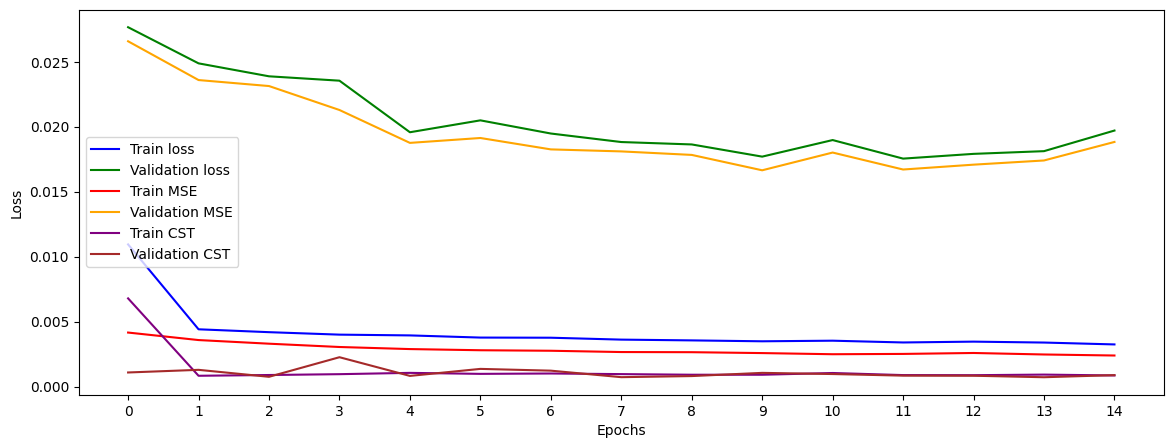

In [140]:
history = pd.read_csv('history/training-3-4.log')
cst.plot_losses_mixed(history, epochs)


Comparing this plot with the previous on task 3.1, 3.2, 3.3 here the difference between validation and train losses is remarkable. Indeed, in this experiment overfitting is present.

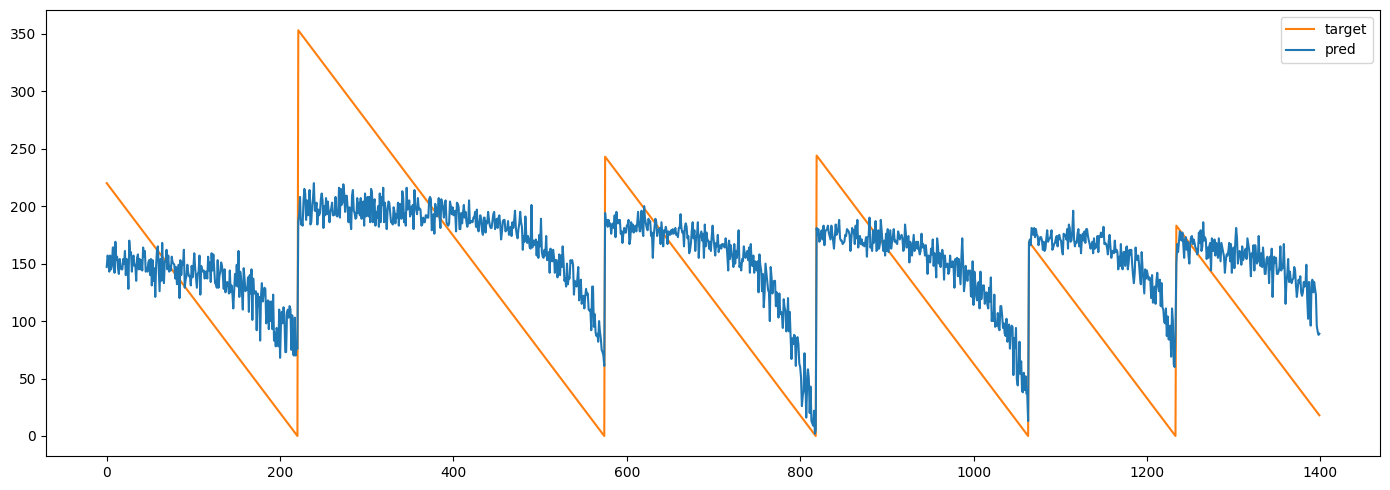

In [141]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

Comparing with the previous experiments, here we have worse performances.

In [143]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0148
Standard Deviation of MSE: 0.0009


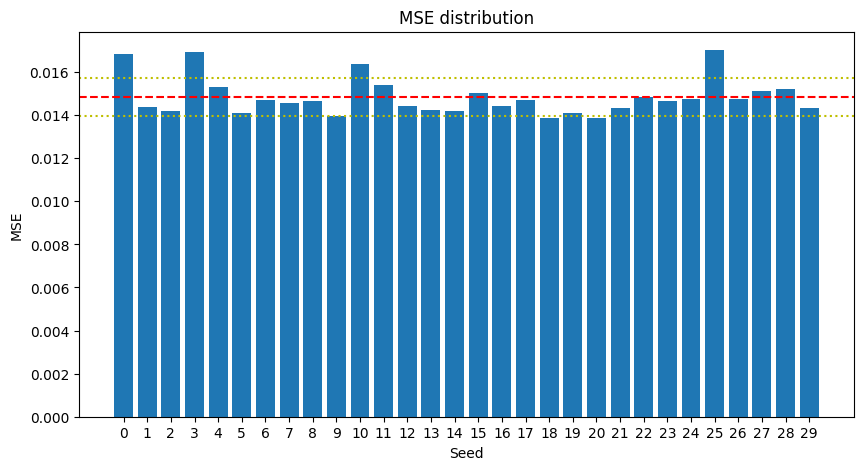

In [144]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [145]:
cst.save_results_to_excel("Task 3.4", mse_mean, mse_std, mse_seeds, excel_file_path)

In [146]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-4.xlsx')

In [13]:
pd.read_excel('./predictions/predictions-3-4.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0        147     121     121     133     108     104     124      85     122   
1        157     142     142     166     145     137     141     140     136   
2        154     133     131     145     117     110     136      97     133   
3        143     120     124     150     116     118     126     122     117   
4        157     135     134     149     129     109     132      89     132   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2743      61      34      48      33      31      49      43      26      48   
2744      80      66      31      81       7      46      45      54      57   
2745      53      44      40      37      29      29      41      46      39   
2746      86      71      36      91       9      47      52      55      60   
2747      69      32      50      56      45      44      30      28      45   

      Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0        106  ...       96       86      140      123       91      129   
1        121  ...      139      123      155      135       97      148   
2        114  ...      109       94      150      129      100      136   
3         98  ...      128      111      121      130       76      127   
4        117  ...      111       99      151      130      101      140   
...      ...  ...      ...      ...      ...      ...      ...      ...   
2743      20  ...       26       16       53       58       10       39   
2744      26  ...       52       34       34       63       50       52   
2745      27  ...       19       -6       74       54        4       39   
2746      40  ...       48       38       37       63       53       62   
2747      25  ...       52       41       38       68        2       45   

      Seed_27  Seed_28  Seed_29  rul  
0         119      130      101  220  
1         143      142      128  219  
2         124      138      113  218  
3         127      129      130  217  
4         124      140      117  216  
...       ...      ...      ...  ...  
2743       47       38       30    4  
2744       68       70       46    3  
2745       55       35       48    2  
2746       62       77       50    1  
2747       52       70       53    0  

[2748 rows x 31 columns]

##### 3.5 100% supervised, 50% unsupervised

In [25]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [26]:
ratio_unsup = 0.50
tru = tru[:int(len(tru) * ratio_unsup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 27824 (supervised), 7406 (unsupervised), 15864 (validation), 2748 (test)


In [27]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [28]:
history, predictions = train_model(train_data=trsu_s,  val_data =vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-5.log')

Epoch 1/15
1151/1151 [==============================] - 4s 4ms/step - loss: 0.0258 - mse: 0.0206 - cst: 0.0051 - val_loss: 0.0184 - val_mse: 0.0164 - val_cst: 0.0020
Epoch 2/15
1151/1151 [==============================] - 4s 4ms/step - loss: 0.0171 - mse: 0.0149 - cst: 0.0022 - val_loss: 0.0182 - val_mse: 0.0160 - val_cst: 0.0022
Epoch 3/15
1151/1151 [==============================] - 5s 4ms/step - loss: 0.0161 - mse: 0.0138 - cst: 0.0023 - val_loss: 0.0151 - val_mse: 0.0134 - val_cst: 0.0017
Epoch 4/15
1151/1151 [==============================] - 4s 4ms/step - loss: 0.0157 - mse: 0.0135 - cst: 0.0022 - val_loss: 0.0159 - val_mse: 0.0140 - val_cst: 0.0019
Epoch 5/15
1151/1151 [==============================] - 4s 4ms/step - loss: 0.0156 - mse: 0.0135 - cst: 0.0021 - val_loss: 0.0164 - val_mse: 0.0149 - val_cst: 0.0015
Epoch 6/15
1151/1151 [==============================] - 4s 3ms/step - loss: 0.0152 - mse: 0.0131 - cst: 0.0021 - val_loss: 0.0163 - val_mse: 0.0136 - val_cst: 0.0027
Epoc

Train history visualization for the first seed

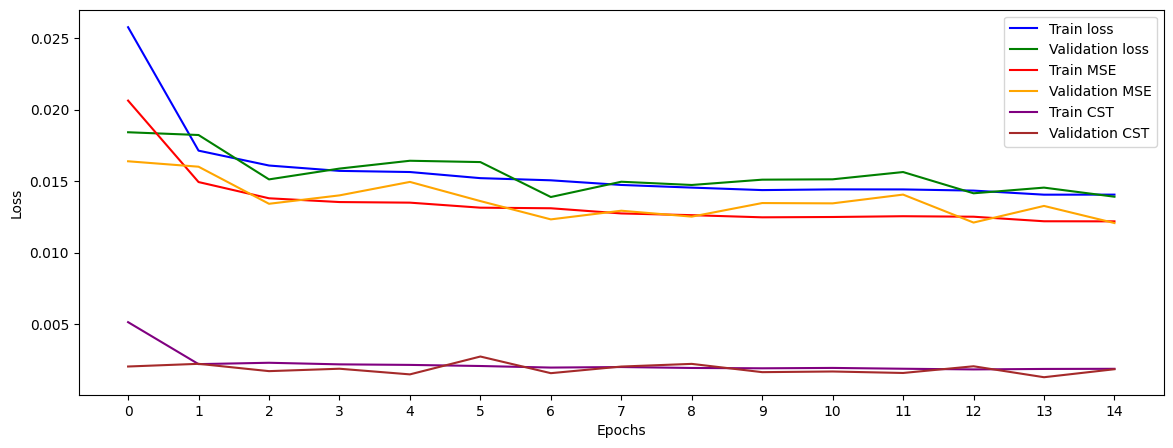

In [29]:
history = pd.read_csv('history/training-3-5.log')
cst.plot_losses_mixed(history, epochs)


The train and validation losses have similar values and decreasing trend.

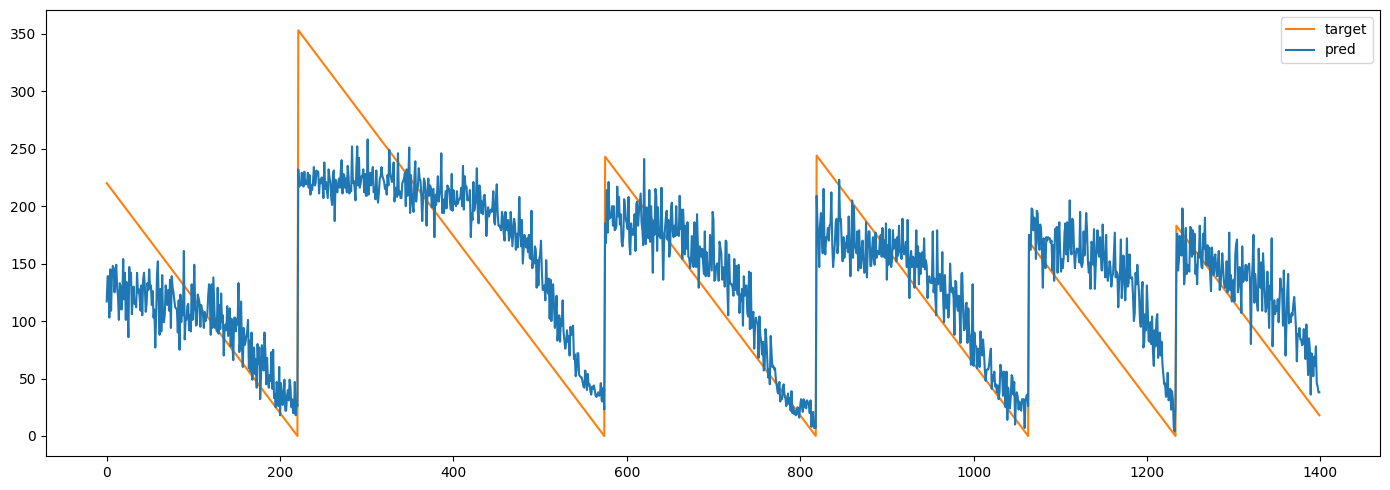

In [30]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [31]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0106
Standard Deviation of MSE: 0.0006


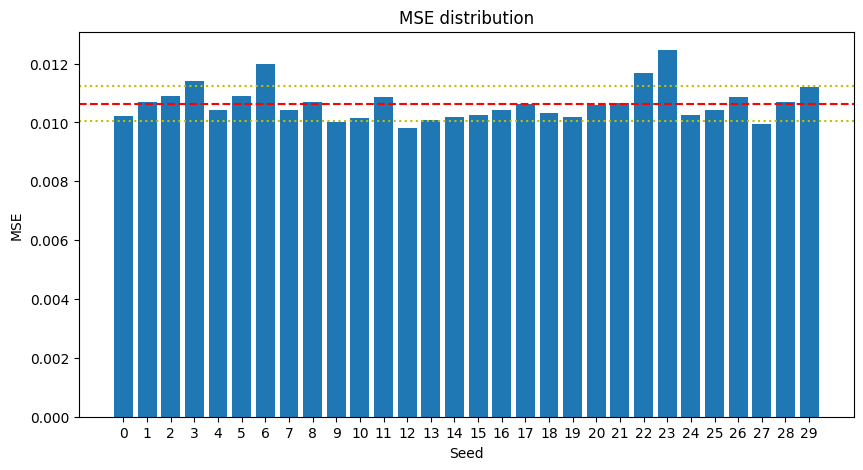

In [32]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [38]:
cst.save_results_to_excel("Task 3.5", mse_mean, mse_std, mse_seeds, excel_file_path)

In [34]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-5.xlsx')

In [35]:
pd.read_excel('./predictions/predictions-3-5.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0        117      99      84     131     108      96      62     113     132   
1        139     147     140     158     151     154     120     149     151   
2        139     110      97     146     122     107      77     126     148   
3        103     122      99     146     128     111      82      97     123   
4        145     113     106     153     133     112      79     130     149   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2743      33      41      20      31      30      30       6      10      14   
2744      18      18      -8      39      -9      42      -8      28      23   
2745      12      18       8      27      -4      45      -9      13       0   
2746      16      19      -1      34     -14      42      -5      25      22   
2747      13      23       4      37       9      22     -17      14      33   

      Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0         94  ...       90       73       83      103       93      107   
1        149  ...      134      113      120      138      140      145   
2        108  ...      108       85      100      117      108      119   
3        118  ...      104       78       65       97      102      100   
4        111  ...      113       91      106      124      113      129   
...      ...  ...      ...      ...      ...      ...      ...      ...   
2743     -12  ...        4       -1       10       25       15       21   
2744      17  ...        1      -33       13       10        1       39   
2745       1  ...       -5      -21      -26       18       11       10   
2746      20  ...       -4      -24       10       18       13       46   
2747      13  ...        5        9       -3       19        9        9   

      Seed_27  Seed_28  Seed_29  rul  
0         119      101       93  220  
1         141      143      131  219  
2         129      110      105  218  
3          93      129       93  217  
4         132      119      116  216  
...       ...      ...      ...  ...  
2743       18       29       19    4  
2744       -1       24       -9    3  
2745        4       10        2    2  
2746        1       21        3    1  
2747       17       44       12    0  

[2748 rows x 31 columns]

##### 3.6 100% supervised, 75% unsupervised

In [160]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [161]:
ratio_unsup = 0.75 
tru = tru[:int(len(tru) * ratio_unsup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 27824 (supervised), 11109 (unsupervised), 15864 (validation), 2748 (test)


In [162]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [163]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-6.log')

Epoch 1/15
1264/1264 [==============================] - 5s 4ms/step - loss: 0.0244 - mse: 0.0193 - cst: 0.0050 - val_loss: 0.0189 - val_mse: 0.0173 - val_cst: 0.0016
Epoch 2/15
1264/1264 [==============================] - 4s 3ms/step - loss: 0.0160 - mse: 0.0138 - cst: 0.0021 - val_loss: 0.0157 - val_mse: 0.0143 - val_cst: 0.0013
Epoch 3/15
1264/1264 [==============================] - 4s 3ms/step - loss: 0.0147 - mse: 0.0126 - cst: 0.0021 - val_loss: 0.0194 - val_mse: 0.0148 - val_cst: 0.0046
Epoch 4/15
1264/1264 [==============================] - 4s 3ms/step - loss: 0.0144 - mse: 0.0123 - cst: 0.0021 - val_loss: 0.0157 - val_mse: 0.0141 - val_cst: 0.0016
Epoch 5/15
1264/1264 [==============================] - 4s 3ms/step - loss: 0.0143 - mse: 0.0122 - cst: 0.0021 - val_loss: 0.0161 - val_mse: 0.0136 - val_cst: 0.0025
Epoch 6/15
1264/1264 [==============================] - 4s 3ms/step - loss: 0.0141 - mse: 0.0121 - cst: 0.0020 - val_loss: 0.0167 - val_mse: 0.0149 - val_cst: 0.0019
Epoc

Train history visualization for the first seed

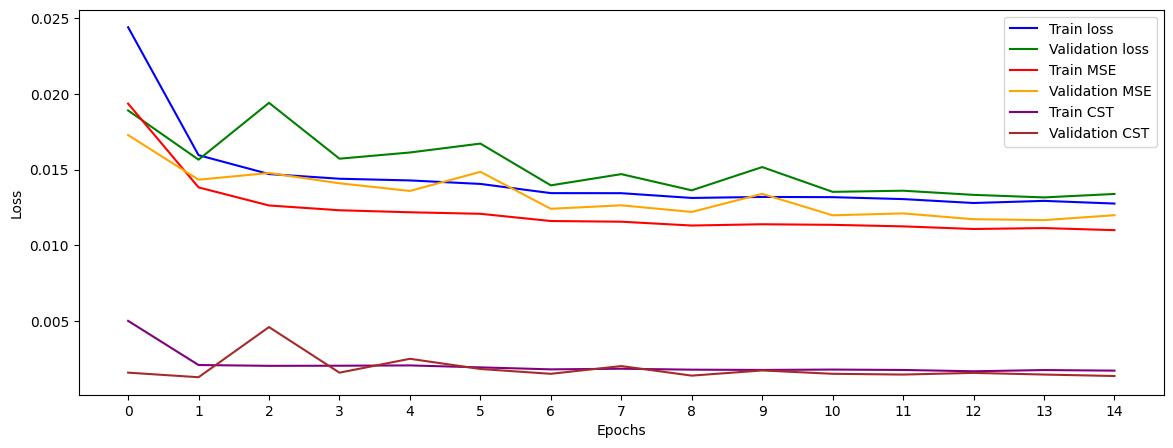

In [164]:
history = pd.read_csv('history/training-3-6.log')
cst.plot_losses_mixed(history, epochs)


The train and validation losses have similar values and decreasing trend.

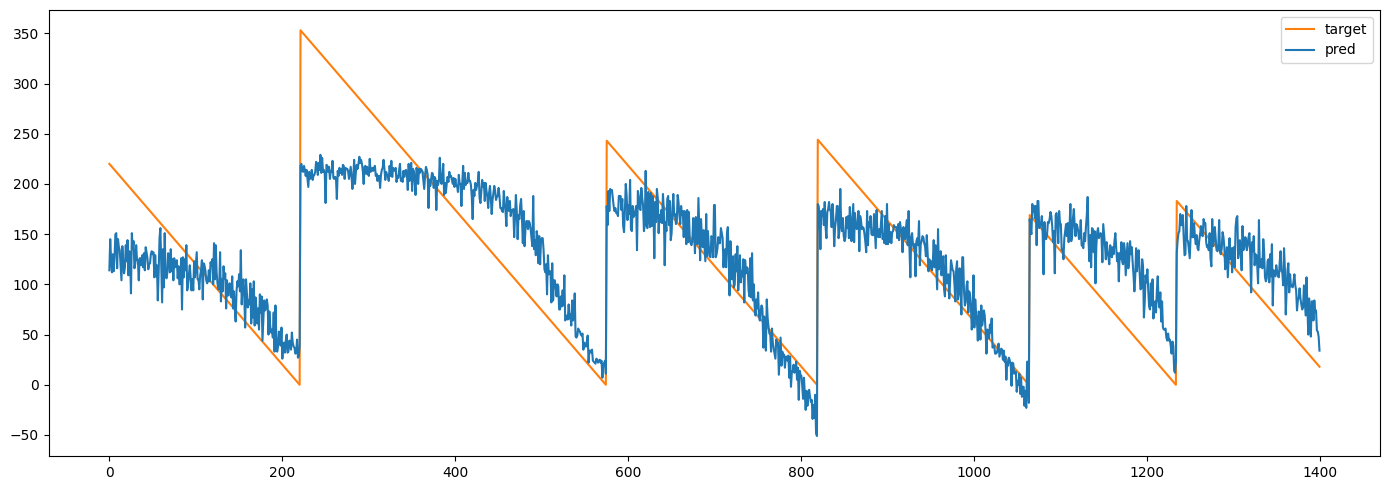

In [165]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [166]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0106
Standard Deviation of MSE: 0.0005


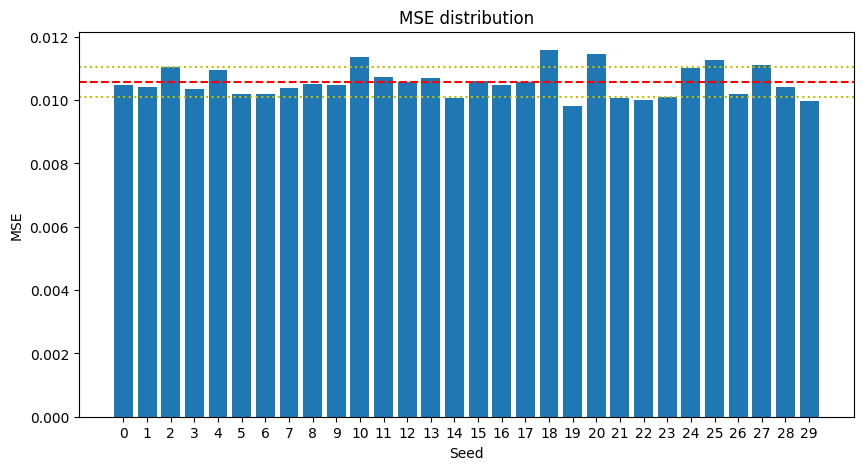

In [167]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [168]:
cst.save_results_to_excel("Task 3.6", mse_mean, mse_std, mse_seeds, excel_file_path)

In [169]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-6.xlsx')

In [15]:
pd.read_excel('./predictions/predictions-3-6.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0        114      98      81      67      96      80      93      94      92   
1        145     145     148     123     144     138     138     142     144   
2        125     111      95      86     108      91     109     109     108   
3        112     108     109      91      96      92      75     103     120   
4        130     115     101      95     116      96     112     110     112   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2743      18      30      27       5       3       9       0      18      15   
2744      12      24     -10       5      38      21      24       7      21   
2745      11      18      11     -13      12      17      15      19       3   
2746      15      26      -2      16      33      21      31      10      15   
2747      20      26      14      15       6       7      13      27      23   

      Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0         90  ...      102       87      114       74      134      104   
1        140  ...      147      153      150      130      150      149   
2        104  ...      119      101      132       85      149      119   
3        107  ...      109      111      113      102      132      117   
4        108  ...      125      109      137       91      157      131   
...      ...  ...      ...      ...      ...      ...      ...      ...   
2743       4  ...       20       14       17       17       23       19   
2744      15  ...       11       -3       19       20       18        3   
2745      21  ...        3        7      -13       14       31       17   
2746      24  ...        5        6       22       26       19        2   
2747      26  ...       11       -3       18       23       30       23   

      Seed_27  Seed_28  Seed_29  rul  
0         133       87      107  220  
1         138      136      133  219  
2         142       98      122  218  
3         120      105       87  217  
4         146      102      133  216  
...       ...      ...      ...  ...  
2743       23       15       16    4  
2744       17       18        5    3  
2745        9       -9       14    2  
2746       17       26       20    1  
2747       18       14       11    0  

[2748 rows x 31 columns]

##### 3.7 100% supervised, 25% unsupervised

In [171]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [172]:
ratio_unsup = 0.25 
tru = tru[:int(len(tru) * ratio_unsup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 27824 (supervised), 3703 (unsupervised), 15864 (validation), 2748 (test)


In [173]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [174]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-7.log')

Epoch 1/15
1041/1041 [==============================] - 4s 3ms/step - loss: 0.0298 - mse: 0.0238 - cst: 0.0060 - val_loss: 0.0198 - val_mse: 0.0175 - val_cst: 0.0023
Epoch 2/15
1041/1041 [==============================] - 4s 4ms/step - loss: 0.0182 - mse: 0.0160 - cst: 0.0021 - val_loss: 0.0159 - val_mse: 0.0142 - val_cst: 0.0017
Epoch 3/15
1041/1041 [==============================] - 4s 3ms/step - loss: 0.0176 - mse: 0.0153 - cst: 0.0023 - val_loss: 0.0153 - val_mse: 0.0136 - val_cst: 0.0017
Epoch 4/15
1041/1041 [==============================] - 3s 3ms/step - loss: 0.0170 - mse: 0.0147 - cst: 0.0022 - val_loss: 0.0144 - val_mse: 0.0126 - val_cst: 0.0017
Epoch 5/15
1041/1041 [==============================] - 3s 3ms/step - loss: 0.0168 - mse: 0.0144 - cst: 0.0024 - val_loss: 0.0146 - val_mse: 0.0130 - val_cst: 0.0016
Epoch 6/15
1041/1041 [==============================] - 3s 3ms/step - loss: 0.0164 - mse: 0.0142 - cst: 0.0021 - val_loss: 0.0145 - val_mse: 0.0130 - val_cst: 0.0015
Epoc

Train history visualization for the first seed

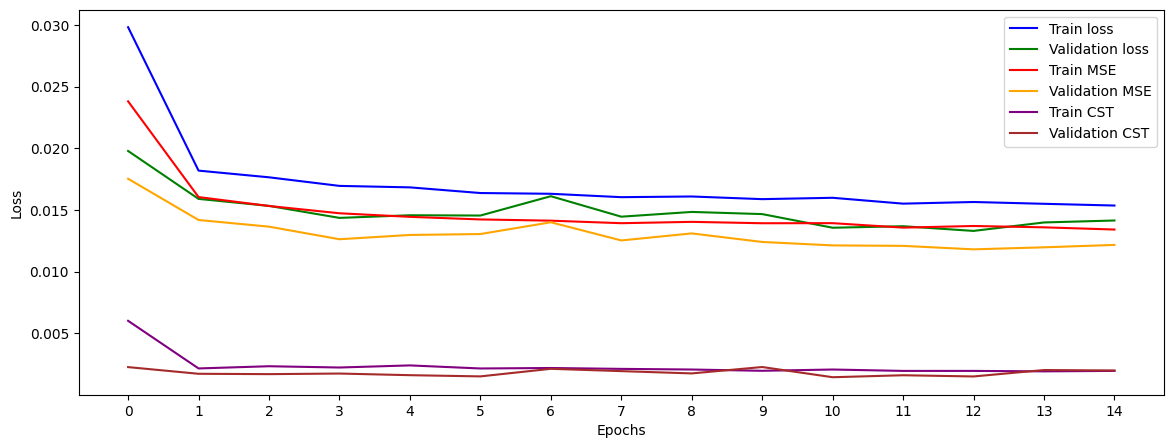

In [175]:
history = pd.read_csv('history/training-3-7.log')
cst.plot_losses_mixed(history, epochs)


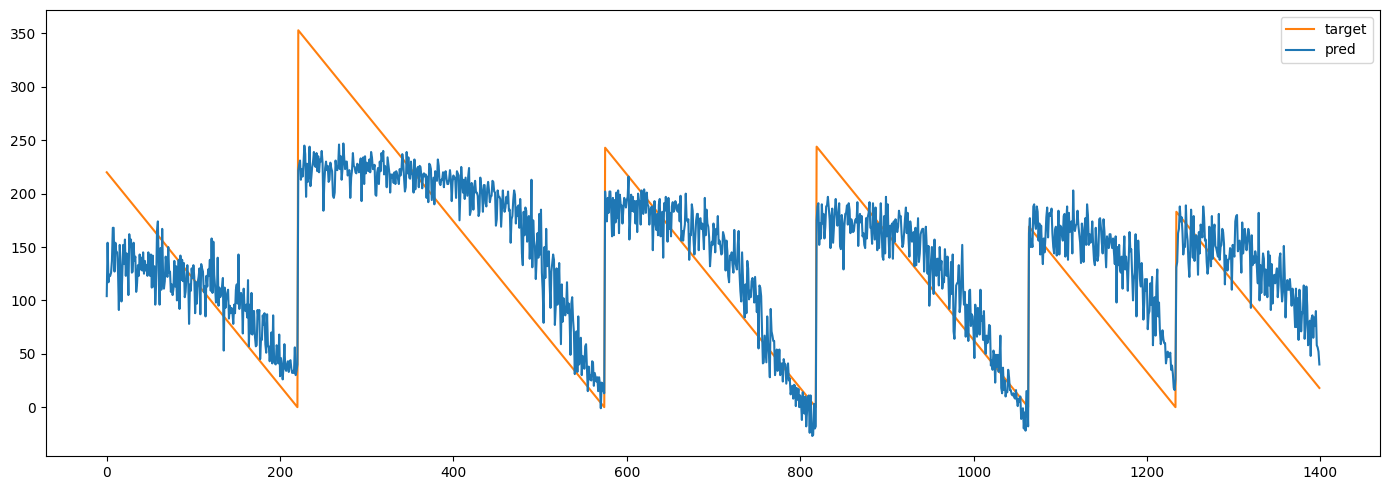

In [176]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [177]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0107
Standard Deviation of MSE: 0.0005


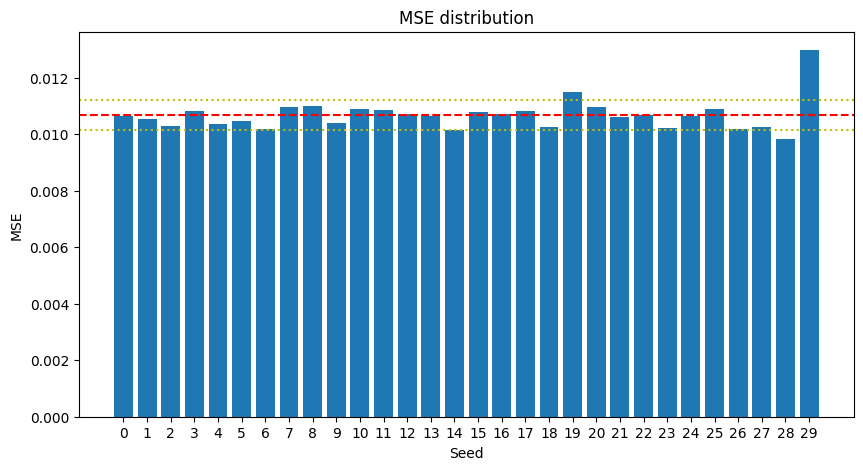

In [178]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [179]:
cst.save_results_to_excel("Task 3.7", mse_mean, mse_std, mse_seeds, excel_file_path)

In [180]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-7.xlsx')

In [16]:
pd.read_excel('./predictions/predictions-3-7.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0        104      88      96      67      77     117      90     103     111   
1        154     123     129     126     133     158     130     136     148   
2        117     103     109      80      95     126     108     118     127   
3        124     101      91     108      92     113      81      94     111   
4        123     106     119      89     107     133     109     119     130   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2743      24      19       3      -1     -12      21      22      -8      19   
2744       8       1      -1      11      10      -6     -12      10      57   
2745      14      13       1     -20     -12      17      12     -11      15   
2746       7       4       2      16      -1      -1      11      12      47   
2747      31      16     -12      22       6      27       8      19      22   

      Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0        123  ...       86      128       81       87      120       95   
1        161  ...      120      159      128      128      149      150   
2        138  ...      102      139       97       99      130      108   
3         96  ...      106       97      111       81      132      101   
4        137  ...      107      150      104      105      137      115   
...      ...  ...      ...      ...      ...      ...      ...      ...   
2743       0  ...       13       12        5       11       30       12   
2744      15  ...        8      -35       19       10        4        2   
2745       9  ...       16        5      -10        8       27        2   
2746      13  ...       -4      -27       12        9       11        7   
2747       8  ...        5      -17       15       19       26        8   

      Seed_27  Seed_28  Seed_29  rul  
0         115       93      159  220  
1         142      131      176  219  
2         125      107      175  218  
3          96      105      145  217  
4         127      119      180  216  
...       ...      ...      ...  ...  
2743       33       10       31    4  
2744       10       10        3    3  
2745        6       -1       21    2  
2746        1       10       17    1  
2747       29        6       43    0  

[2748 rows x 31 columns]

##### 3.8 75% unsupervised, 75% supervised

In [182]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [183]:
ratio_unsup = 0.75 
ratio_sup = 0.75
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation),{len(ts)} (test)')

Num. samples: 20868 (supervised), 11109 (unsupervised), 15864 (validation),2748 (test)


In [184]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [185]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-8.log')

Epoch 1/15
1028/1028 [==============================] - 4s 3ms/step - loss: 0.0240 - mse: 0.0184 - cst: 0.0056 - val_loss: 0.0212 - val_mse: 0.0184 - val_cst: 0.0027
Epoch 2/15
1028/1028 [==============================] - 3s 3ms/step - loss: 0.0148 - mse: 0.0128 - cst: 0.0020 - val_loss: 0.0184 - val_mse: 0.0164 - val_cst: 0.0020
Epoch 3/15
1028/1028 [==============================] - 3s 3ms/step - loss: 0.0138 - mse: 0.0117 - cst: 0.0021 - val_loss: 0.0174 - val_mse: 0.0155 - val_cst: 0.0019
Epoch 4/15
1028/1028 [==============================] - 3s 3ms/step - loss: 0.0137 - mse: 0.0115 - cst: 0.0022 - val_loss: 0.0167 - val_mse: 0.0139 - val_cst: 0.0028
Epoch 5/15
1028/1028 [==============================] - 3s 3ms/step - loss: 0.0133 - mse: 0.0112 - cst: 0.0020 - val_loss: 0.0141 - val_mse: 0.0125 - val_cst: 0.0017
Epoch 6/15
1028/1028 [==============================] - 4s 3ms/step - loss: 0.0132 - mse: 0.0111 - cst: 0.0020 - val_loss: 0.0153 - val_mse: 0.0134 - val_cst: 0.0019
Epoc

Train history visualization for the first seed

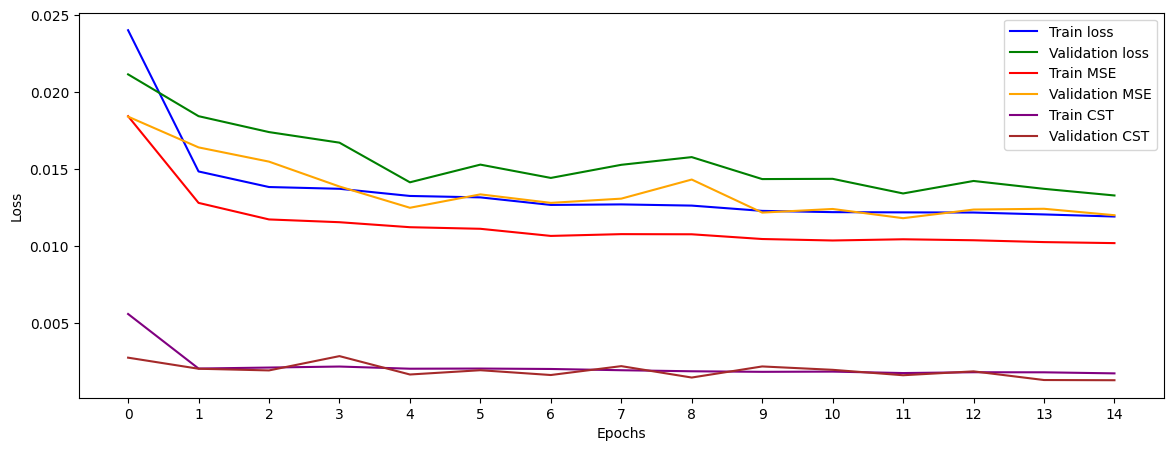

In [186]:
history = pd.read_csv('history/training-3-8.log')
cst.plot_losses_mixed(history, epochs)


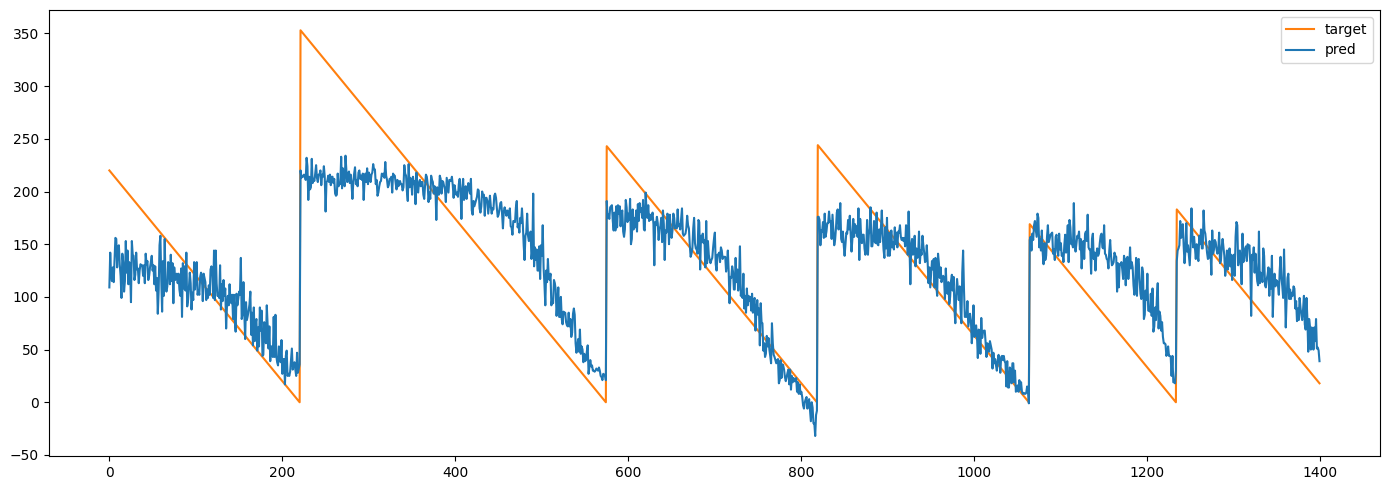

In [187]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [188]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0112
Standard Deviation of MSE: 0.0009


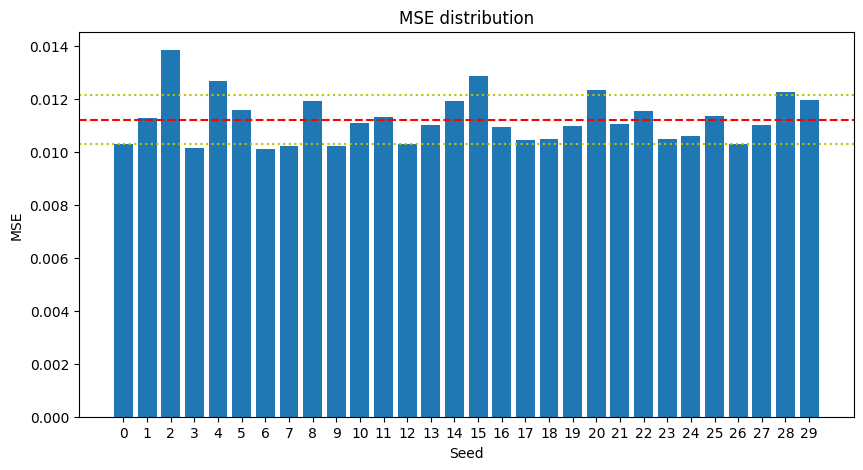

In [189]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [190]:
cst.save_results_to_excel("Task 3.8", mse_mean, mse_std, mse_seeds, excel_file_path)

In [191]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-8.xlsx')

In [17]:
pd.read_excel('./predictions/predictions-3-8.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0        109      95     182     123     123      91     105     109     112   
1        142     132     194     152     172     125     155     163     155   
2        121     110     199     140     136      99     121     124     132   
3        115      92     132     118     154      98     114     114     146   
4        128     115     203     149     144     106     122     126     137   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2743      29      20      40      29      23       8       8     -11      35   
2744      12      -8      36       7      53      14      -6      16      33   
2745       7      16      30       1      -1       6      25      -1      21   
2746       8      -4      42      11      43      14      11      17      25   
2747      26      10      30      27      29      16      14      18      37   

      Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0        116  ...      145      123      102       88       98      111   
1        150  ...      169      165      140      147      137      144   
2        128  ...      163      134      120      103      111      125   
3        117  ...      124      130      102      115      120      116   
4        131  ...      167      144      123      107      116      134   
...      ...  ...      ...      ...      ...      ...      ...      ...   
2743       3  ...       27       25       16       21       18       27   
2744      -2  ...       17        9       -6        6       13       26   
2745      -4  ...       11       -5      -13       11      -13        0   
2746      -4  ...        5       17       -8       14       14       24   
2747      30  ...       12        9       20       31       26       21   

      Seed_27  Seed_28  Seed_29  rul  
0          97       92       78  220  
1         150      128      124  219  
2         107      102       92  218  
3         118       86      106  217  
4         108      106      100  216  
...       ...      ...      ...  ...  
2743       22       10        0    4  
2744        3       -4        0    3  
2745       11      -10       17    2  
2746       -2        4       13    1  
2747       13        6       18    0  

[2748 rows x 31 columns]

##### 3.9 75% unsupervised, 50% supervised

In [193]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [194]:
ratio_unsup = 0.75 
ratio_sup = 0.50
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation),{len(ts)} (test)')

Num. samples: 13912 (supervised), 11109 (unsupervised), 15864 (validation),2748 (test)


In [195]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [196]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-9.log')

Epoch 1/15
795/795 [==============================] - 3s 3ms/step - loss: 0.0227 - mse: 0.0171 - cst: 0.0056 - val_loss: 0.0230 - val_mse: 0.0208 - val_cst: 0.0022
Epoch 2/15
795/795 [==============================] - 3s 3ms/step - loss: 0.0147 - mse: 0.0129 - cst: 0.0018 - val_loss: 0.0201 - val_mse: 0.0183 - val_cst: 0.0018
Epoch 3/15
795/795 [==============================] - 2s 3ms/step - loss: 0.0129 - mse: 0.0111 - cst: 0.0018 - val_loss: 0.0163 - val_mse: 0.0150 - val_cst: 0.0012
Epoch 4/15
795/795 [==============================] - 3s 4ms/step - loss: 0.0125 - mse: 0.0106 - cst: 0.0018 - val_loss: 0.0173 - val_mse: 0.0162 - val_cst: 0.0011
Epoch 5/15
795/795 [==============================] - 3s 3ms/step - loss: 0.0121 - mse: 0.0103 - cst: 0.0018 - val_loss: 0.0168 - val_mse: 0.0143 - val_cst: 0.0025
Epoch 6/15
795/795 [==============================] - 3s 4ms/step - loss: 0.0118 - mse: 0.0100 - cst: 0.0018 - val_loss: 0.0150 - val_mse: 0.0136 - val_cst: 0.0014
Epoch 7/15
795/7

Train history visualization for the first seed

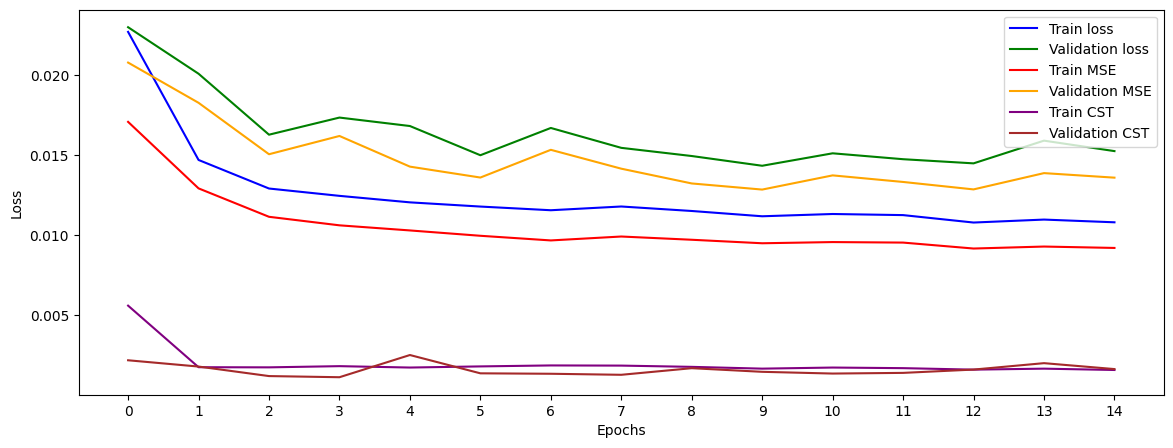

In [197]:
history = pd.read_csv('history/training-3-9.log')
cst.plot_losses_mixed(history, epochs)


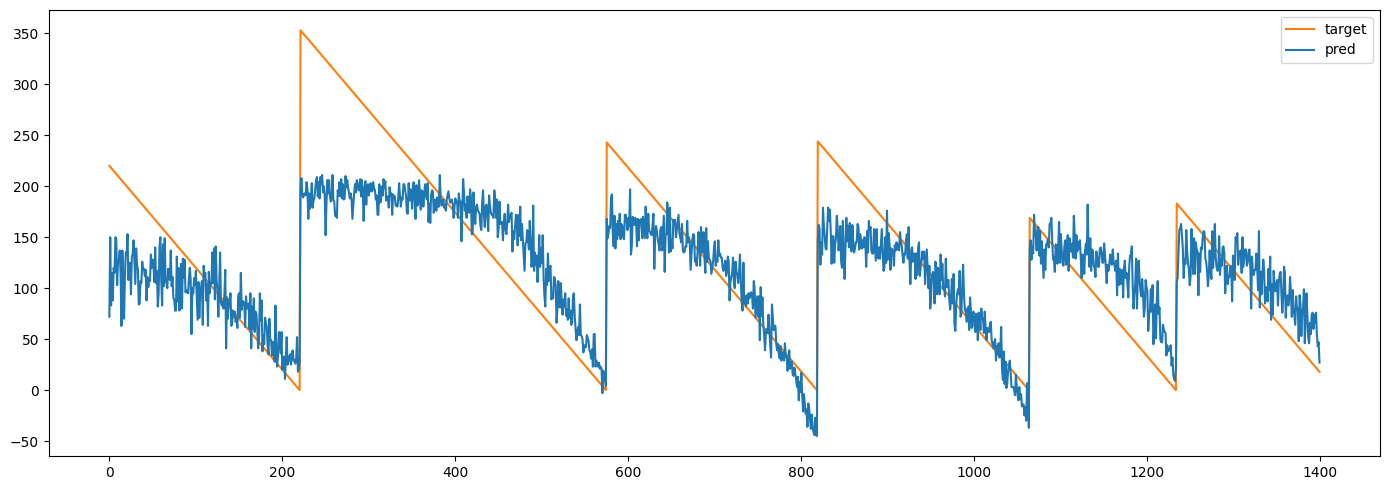

In [198]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [199]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0115
Standard Deviation of MSE: 0.0009


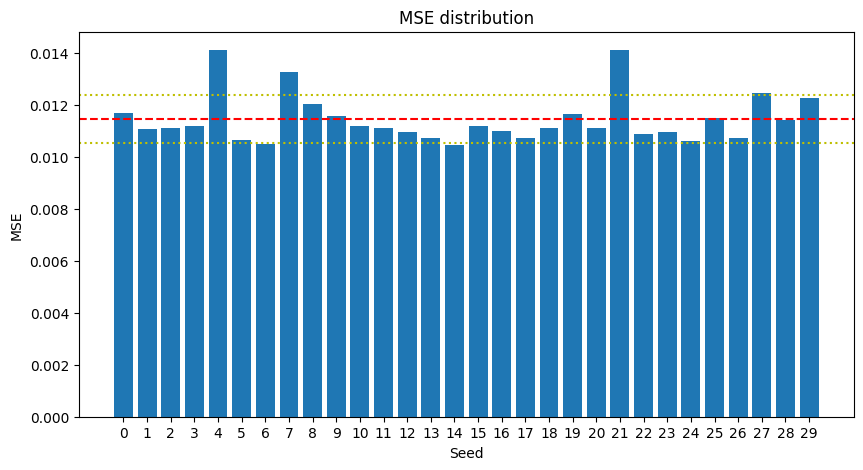

In [200]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [201]:
cst.save_results_to_excel("Task 3.9", mse_mean, mse_std, mse_seeds, excel_file_path)

In [202]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-9.xlsx')

In [18]:
pd.read_excel('./predictions/predictions-3-9.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0         72     101      90     120      79      98     110      85     118   
1        150     137     148     153     109     135     160     125     160   
2         83     112     102     137      91     108     127      88     137   
3        115     109     102     120      94     106     111     105     135   
4         88     114     111     143     100     110     128      89     145   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2743      -3      13       5      13       8       4       9      -2      25   
2744       0      21     -48     -20      -1     -12      -6      12      15   
2745      14       4       9       8     -27       9      27      -2       9   
2746       5      22     -31     -13     -17      -8      12      15      12   
2747       9       7      -9      16      14       4      28      19      31   

      Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0         77  ...       75      101      100      103      108      106   
1        135  ...      126      130      132      136      157      141   
2         88  ...       91      110      115      114      122      118   
3        106  ...       86      117      125      108      140      131   
4         91  ...       95      118      118      118      126      127   
...      ...  ...      ...      ...      ...      ...      ...      ...   
2743      -8  ...       -7        9       17       13       25        7   
2744      15  ...      -31      -15        2       36      -10       -6   
2745       1  ...      -14       -4       -7        7       25      -13   
2746      19  ...      -42       -7       -3       42        0        0   
2747      22  ...      -13        6       21       23       35       14   

      Seed_27  Seed_28  Seed_29  rul  
0          71       98      136  220  
1         129      138      150  219  
2          78      107      147  218  
3         133      113      148  217  
4          77      109      151  216  
...       ...      ...      ...  ...  
2743       12       16       28    4  
2744       25       -6        8    3  
2745      -13       14       17    2  
2746       18       14       18    1  
2747       21       24       36    0  

[2748 rows x 31 columns]

##### 3.10 75% unsupervised, 25% supervised

In [204]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [205]:
ratio_unsup = 0.75 
ratio_sup = 0.25
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 6956 (supervised), 11109 (unsupervised), 15864 (validation), 2748 (test)


In [206]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [207]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-10.log')

Epoch 1/15
562/562 [==============================] - 3s 4ms/step - loss: 0.0207 - mse: 0.0126 - cst: 0.0082 - val_loss: 0.0256 - val_mse: 0.0239 - val_cst: 0.0017
Epoch 2/15
562/562 [==============================] - 2s 4ms/step - loss: 0.0100 - mse: 0.0086 - cst: 0.0014 - val_loss: 0.0226 - val_mse: 0.0208 - val_cst: 0.0018
Epoch 3/15
562/562 [==============================] - 2s 4ms/step - loss: 0.0089 - mse: 0.0074 - cst: 0.0014 - val_loss: 0.0208 - val_mse: 0.0184 - val_cst: 0.0024
Epoch 4/15
562/562 [==============================] - 2s 4ms/step - loss: 0.0086 - mse: 0.0070 - cst: 0.0016 - val_loss: 0.0183 - val_mse: 0.0167 - val_cst: 0.0015
Epoch 5/15
562/562 [==============================] - 2s 3ms/step - loss: 0.0079 - mse: 0.0064 - cst: 0.0015 - val_loss: 0.0184 - val_mse: 0.0167 - val_cst: 0.0017
Epoch 6/15
562/562 [==============================] - 2s 3ms/step - loss: 0.0078 - mse: 0.0062 - cst: 0.0016 - val_loss: 0.0175 - val_mse: 0.0155 - val_cst: 0.0020
Epoch 7/15
562/5

Train history visualization for the first seed

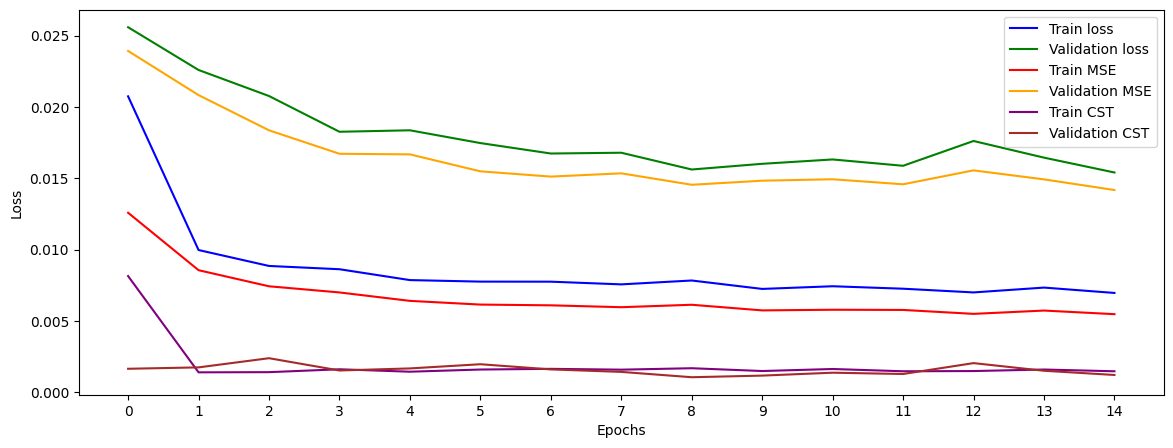

In [208]:
history = pd.read_csv('history/training-3-10.log')
cst.plot_losses_mixed(history, epochs)


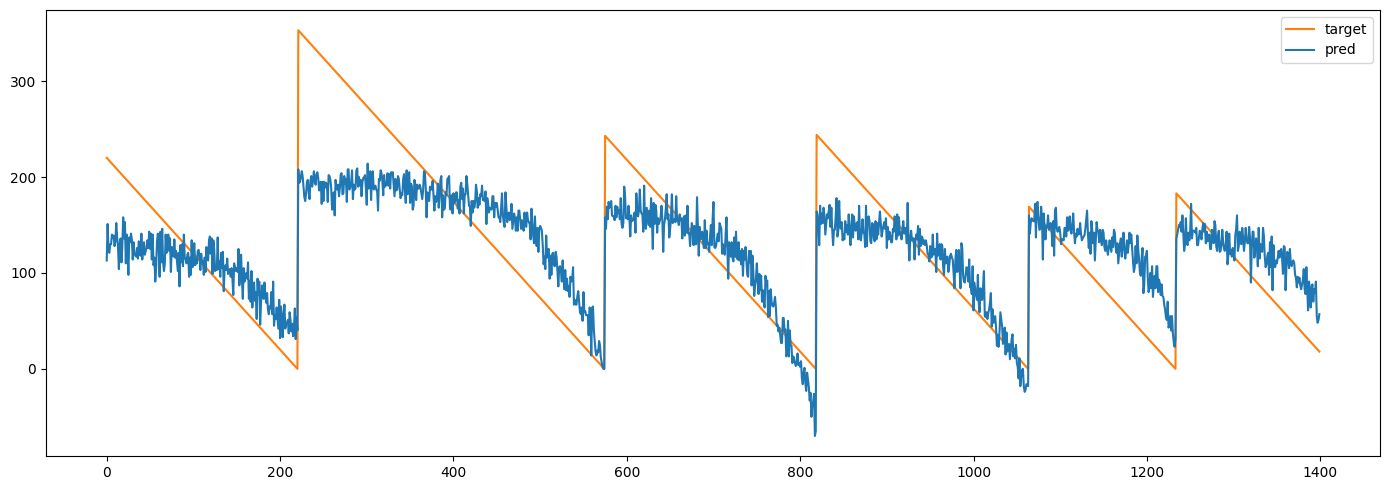

In [209]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [210]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0124
Standard Deviation of MSE: 0.0012


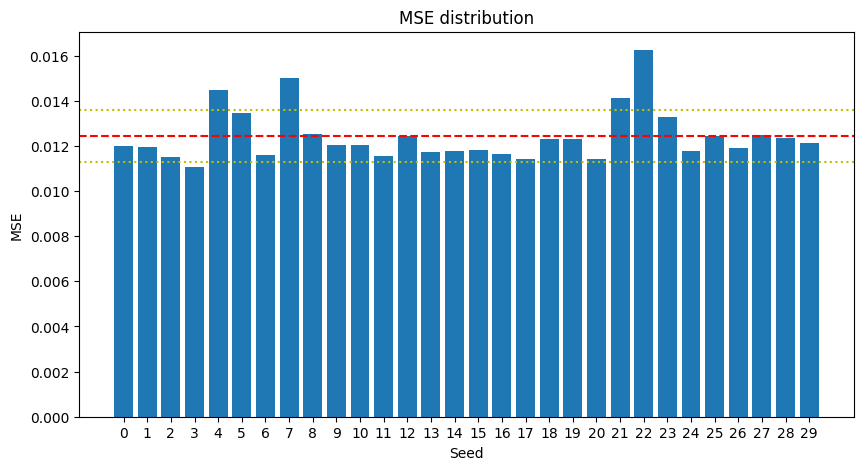

In [211]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [212]:
cst.save_results_to_excel("Task 3.10", mse_mean, mse_std, mse_seeds, excel_file_path)

In [213]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-10.xlsx')

In [19]:
pd.read_excel('./predictions/predictions-3-10.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0        113     116      89     107      84     140     109      74     115   
1        151     153     153     154     128     158     151     120     158   
2        124     132     101     125      95     145     128      87     129   
3        121     136     115     141     128     131     135      93     108   
4        130     135     110     129     104     149     124      89     129   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2743      21     -11      -5      -6      -5      30       5     -15     -15   
2744       3      18     -18      -6      12      48      10     -20       8   
2745      13       2      -5      -7     -31      19      -9     -14      15   
2746      11      27      -4       9      17      55      32     -16      10   
2747      14      18       1      11      13      17      18       5      24   

      Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0        126  ...       71      166       89      109       98      100   
1        165  ...      131      189      146      137      140      155   
2        140  ...       87      177      105      118      112      115   
3        135  ...      100      174       94      126      118      138   
4        143  ...       90      185      104      121      116      125   
...      ...  ...      ...      ...      ...      ...      ...      ...   
2743      10  ...      -17       34        2        5        8      -10   
2744      16  ...      -11       18        1       10       33        6   
2745      13  ...      -13       30      -12       12       -5      -13   
2746      23  ...      -16       19       -2       19       47       15   
2747      21  ...       -1       47        8       24       16       15   

      Seed_27  Seed_28  Seed_29  rul  
0         120      120      123  220  
1         148      152      155  219  
2         129      132      139  218  
3         120      133      145  217  
4         127      139      146  216  
...       ...      ...      ...  ...  
2743        5       10       24    4  
2744        7       21       21    3  
2745       10       13       11    2  
2746       -1       33       27    1  
2747       11       35       44    0  

[2748 rows x 31 columns]

##### 3.11 50% unsupervised, 75% supervised

In [215]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [216]:
ratio_unsup = 0.50 
ratio_sup = 0.75
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 20868 (supervised), 7406 (unsupervised), 15864 (validation), 2748 (test)


In [217]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [218]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-11.log')

Epoch 1/15
915/915 [==============================] - 3s 3ms/step - loss: 0.0274 - mse: 0.0215 - cst: 0.0059 - val_loss: 0.0185 - val_mse: 0.0170 - val_cst: 0.0015
Epoch 2/15
915/915 [==============================] - 3s 4ms/step - loss: 0.0164 - mse: 0.0143 - cst: 0.0020 - val_loss: 0.0179 - val_mse: 0.0160 - val_cst: 0.0020
Epoch 3/15
915/915 [==============================] - 3s 3ms/step - loss: 0.0155 - mse: 0.0132 - cst: 0.0023 - val_loss: 0.0155 - val_mse: 0.0142 - val_cst: 0.0013
Epoch 4/15
915/915 [==============================] - 3s 3ms/step - loss: 0.0148 - mse: 0.0126 - cst: 0.0022 - val_loss: 0.0149 - val_mse: 0.0133 - val_cst: 0.0016
Epoch 5/15
915/915 [==============================] - 3s 3ms/step - loss: 0.0149 - mse: 0.0126 - cst: 0.0023 - val_loss: 0.0153 - val_mse: 0.0139 - val_cst: 0.0014
Epoch 6/15
915/915 [==============================] - 3s 3ms/step - loss: 0.0143 - mse: 0.0122 - cst: 0.0021 - val_loss: 0.0150 - val_mse: 0.0133 - val_cst: 0.0018
Epoch 7/15
915/9

Train history visualization for the first seed

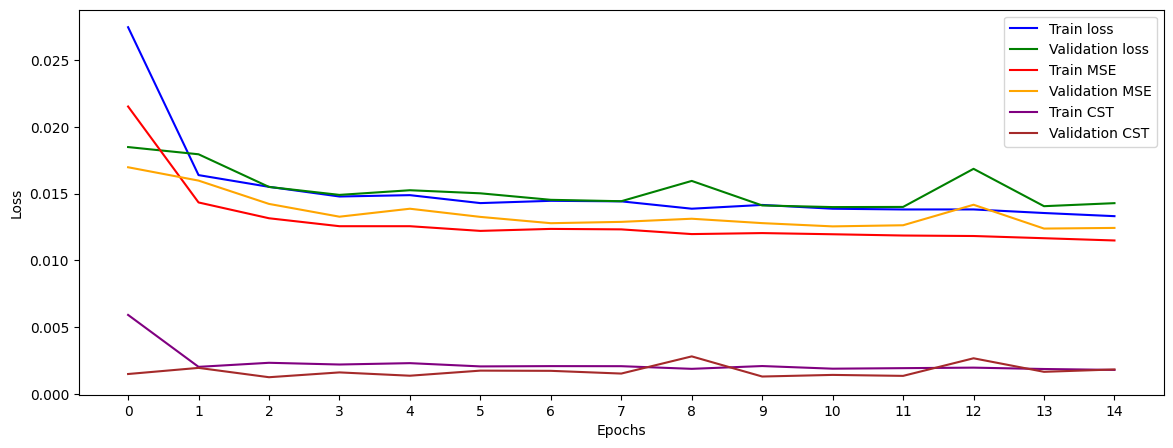

In [219]:
history = pd.read_csv('history/training-3-11.log')
cst.plot_losses_mixed(history, epochs)


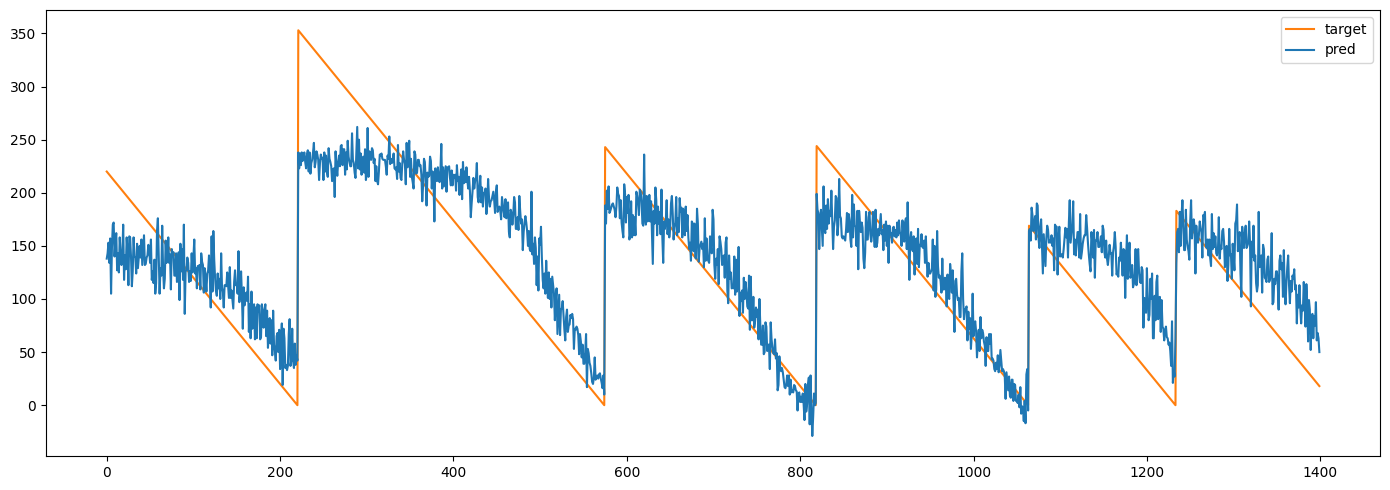

In [220]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [221]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0114
Standard Deviation of MSE: 0.0011


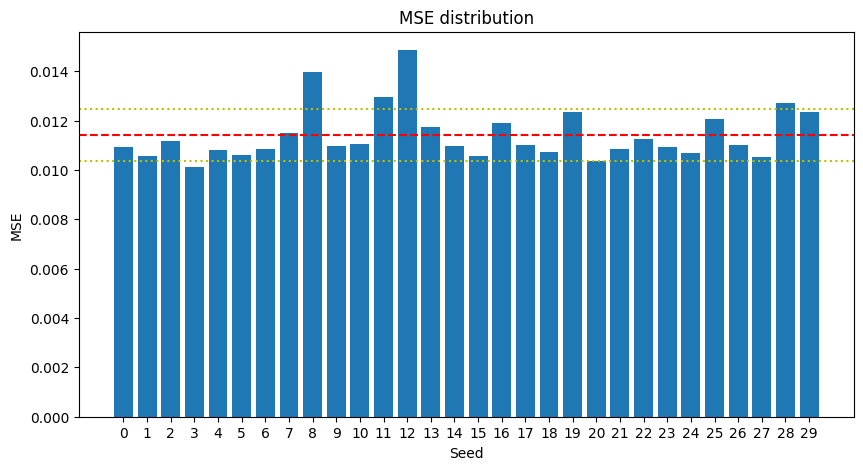

In [222]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [223]:
cst.save_results_to_excel("Task 3.11", mse_mean, mse_std, mse_seeds, excel_file_path)

In [224]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-11.xlsx')

In [20]:
pd.read_excel('./predictions/predictions-3-11.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0        138     103      97     106     120      87     135     125      59   
1        143     131     150     151     170     143     149     151     116   
2        153     119     113     124     134      90     155     142      73   
3        134     105     120     116     121     139     123     157     101   
4        157     125     124     131     145      94     155     141      80   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2743      16      18      20      11      26      11      15       6     -11   
2744       8      -2      20      -2       4       9      22       1       2   
2745      17      -4      -9      -9     -17      -2      24      10     -23   
2746       9       0      26       4      -6      13      30       6      -2   
2747      32      19      13      25      16      34      22      36      23   

      Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0         92  ...      131      113      118      106      132      102   
1        160  ...      155      149      137      145      161      137   
2        107  ...      148      125      134      115      147      114   
3        133  ...      126      116       98      112      146       86   
4        111  ...      152      131      139      119      153      125   
...      ...  ...      ...      ...      ...      ...      ...      ...   
2743     -19  ...       20       25       16       17       24       10   
2744      25  ...        7      -10       17       18       19       10   
2745      -2  ...       -3      -19      -15       13       25       -9   
2746      30  ...       -1       -3       22       25       28        3   
2747      32  ...       14       18        7       24       34        4   

      Seed_27  Seed_28  Seed_29  rul  
0         117      110       79  220  
1         160      130      117  219  
2         126      124       94  218  
3         117       82      102  217  
4         129      126      103  216  
...       ...      ...      ...  ...  
2743       23       20      -24    4  
2744       20      -15        3    3  
2745       -6      -10       -1    2  
2746       13       -6       16    1  
2747       27        2       23    0  

[2748 rows x 31 columns]

##### 3.12 50% unsupervised, 50% supervised

In [226]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [227]:
ratio_unsup = 0.50
ratio_sup = 0.50
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 13912 (supervised), 7406 (unsupervised), 15864 (validation), 2748 (test)


In [228]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [229]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-12.log')

Epoch 1/15
682/682 [==============================] - 3s 4ms/step - loss: 0.0252 - mse: 0.0180 - cst: 0.0071 - val_loss: 0.0208 - val_mse: 0.0192 - val_cst: 0.0015
Epoch 2/15
682/682 [==============================] - 3s 5ms/step - loss: 0.0157 - mse: 0.0138 - cst: 0.0019 - val_loss: 0.0203 - val_mse: 0.0171 - val_cst: 0.0032
Epoch 3/15
682/682 [==============================] - 2s 3ms/step - loss: 0.0144 - mse: 0.0124 - cst: 0.0020 - val_loss: 0.0161 - val_mse: 0.0144 - val_cst: 0.0017
Epoch 4/15
682/682 [==============================] - 2s 4ms/step - loss: 0.0137 - mse: 0.0116 - cst: 0.0020 - val_loss: 0.0148 - val_mse: 0.0135 - val_cst: 0.0014
Epoch 5/15
682/682 [==============================] - 3s 4ms/step - loss: 0.0136 - mse: 0.0115 - cst: 0.0021 - val_loss: 0.0160 - val_mse: 0.0141 - val_cst: 0.0019
Epoch 6/15
682/682 [==============================] - 2s 3ms/step - loss: 0.0135 - mse: 0.0115 - cst: 0.0020 - val_loss: 0.0156 - val_mse: 0.0138 - val_cst: 0.0019
Epoch 7/15
682/6

Train history visualization for the first seed

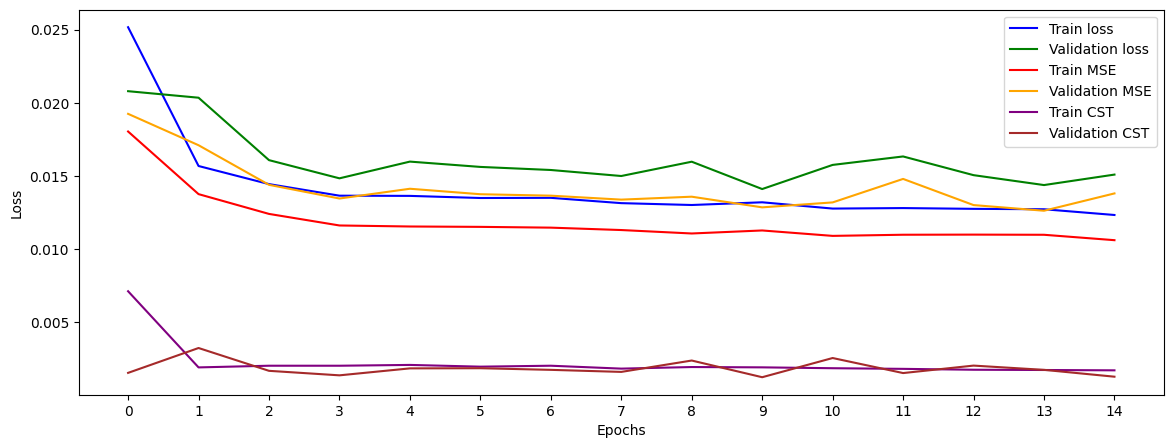

In [230]:
history = pd.read_csv('history/training-3-12.log')
cst.plot_losses_mixed(history, epochs)


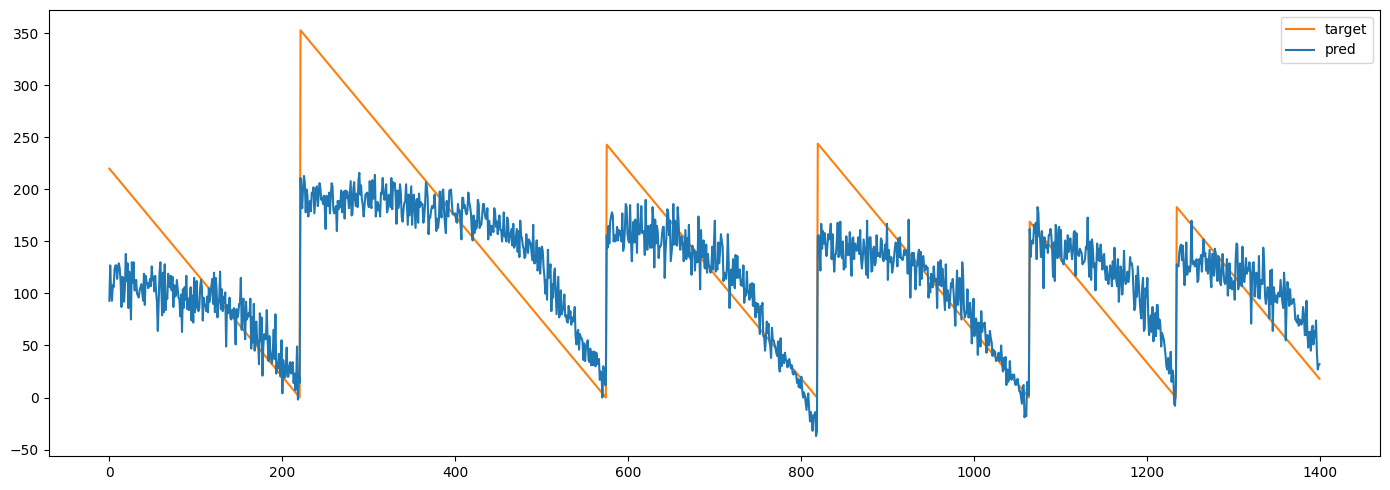

In [231]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [232]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0116
Standard Deviation of MSE: 0.0008


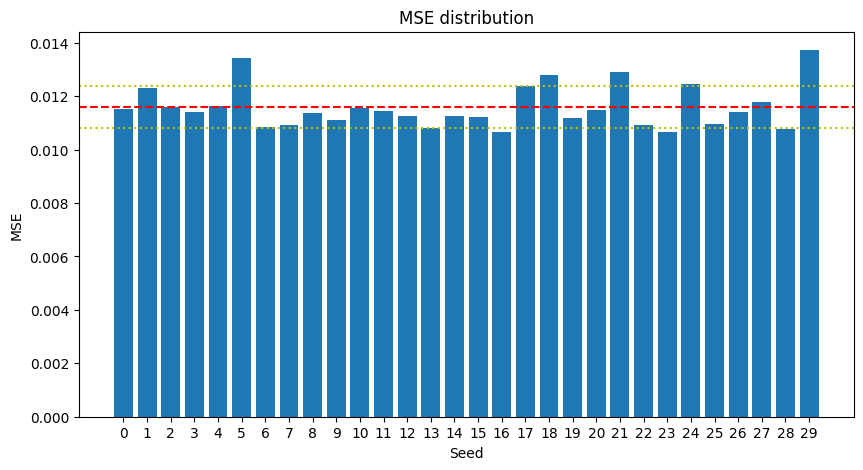

In [233]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [234]:
cst.save_results_to_excel("Task 3.12", mse_mean, mse_std, mse_seeds, excel_file_path)

In [235]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-12.xlsx')

In [21]:
pd.read_excel('./predictions/predictions-3-12.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0         93      72     115     105      91     143     115     116     118   
1        127     130     139     127     142     179     148     145     146   
2        101      86     129     118     106     149     133     126     133   
3         93      88      75     102     118     143     128     112     118   
4        108      89     137     119     120     151     131     127     135   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2743      24     -19       8     -14      12      17      -3      15      22   
2744       8       0     -45      26      -4      10      -3       2      -6   
2745      -3      21       7      -6     -26      25      13      11      11   
2746       9       8     -35      28     -18      13       7       1      -8   
2747       4       7      -2      10       9      31      20      18      28   

      Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0         87  ...      123      112      117       81       90      135   
1        146  ...      168      149      134      120      137      161   
2         95  ...      139      123      133       92      105      148   
3        126  ...      157      104      111       99      116      124   
4         98  ...      142      132      134       94      110      158   
...      ...  ...      ...      ...      ...      ...      ...      ...   
2743     -17  ...       10       13       23       -7       21       29   
2744       6  ...       16       -5        1       22        4        8   
2745       0  ...       -4       -9        3       -8        5       18   
2746       9  ...        0        2        1       28       15       21   
2747      17  ...       28        0       20        6       25       27   

      Seed_27  Seed_28  Seed_29  rul  
0         135       99      143  220  
1         162      130      189  219  
2         144      112      156  218  
3         118      102      155  217  
4         143      123      160  216  
...       ...      ...      ...  ...  
2743       40        0       36    4  
2744       -9       -4        4    3  
2745       10      -15       22    2  
2746      -18        9       21    1  
2747       20      -11       56    0  

[2748 rows x 31 columns]

##### 3.13 50% unsupervised, 25% supervised

In [237]:
tr, ts, trs, tru, vs= cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [238]:
ratio_unsup = 0.50 
ratio_sup = 0.25
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 6956 (supervised), 7406 (unsupervised), 15864 (validation), 2748 (test)


In [239]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [240]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-13.log')

Epoch 1/15
449/449 [==============================] - 2s 4ms/step - loss: 0.0265 - mse: 0.0153 - cst: 0.0112 - val_loss: 0.0250 - val_mse: 0.0232 - val_cst: 0.0018
Epoch 2/15
449/449 [==============================] - 2s 5ms/step - loss: 0.0112 - mse: 0.0099 - cst: 0.0013 - val_loss: 0.0203 - val_mse: 0.0188 - val_cst: 0.0015
Epoch 3/15
449/449 [==============================] - 2s 4ms/step - loss: 0.0103 - mse: 0.0087 - cst: 0.0016 - val_loss: 0.0194 - val_mse: 0.0172 - val_cst: 0.0022
Epoch 4/15
449/449 [==============================] - 2s 4ms/step - loss: 0.0096 - mse: 0.0080 - cst: 0.0017 - val_loss: 0.0163 - val_mse: 0.0150 - val_cst: 0.0013
Epoch 5/15
449/449 [==============================] - 2s 4ms/step - loss: 0.0095 - mse: 0.0077 - cst: 0.0018 - val_loss: 0.0163 - val_mse: 0.0146 - val_cst: 0.0016
Epoch 6/15
449/449 [==============================] - 2s 4ms/step - loss: 0.0093 - mse: 0.0073 - cst: 0.0020 - val_loss: 0.0159 - val_mse: 0.0145 - val_cst: 0.0014
Epoch 7/15
449/4

Train history visualization for the first seed

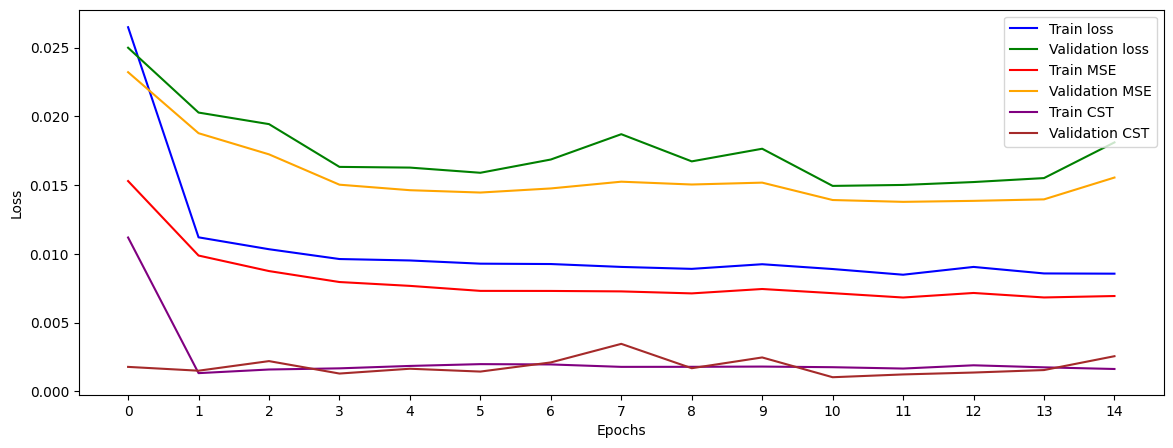

In [241]:
history = pd.read_csv('history/training-3-13.log')
cst.plot_losses_mixed(history, epochs)


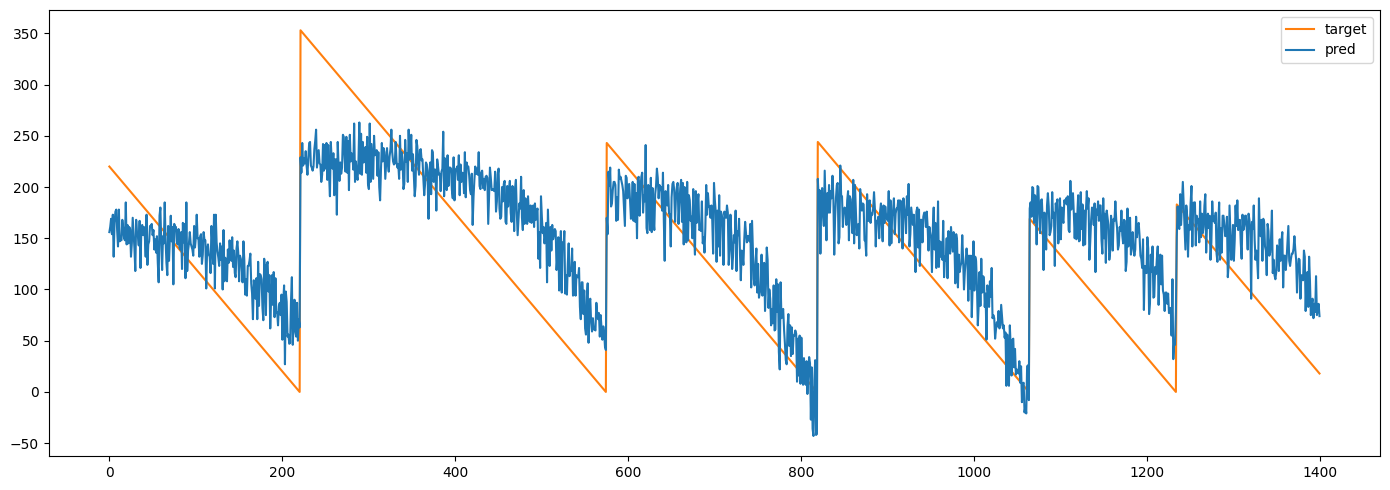

In [242]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [243]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0124
Standard Deviation of MSE: 0.0009


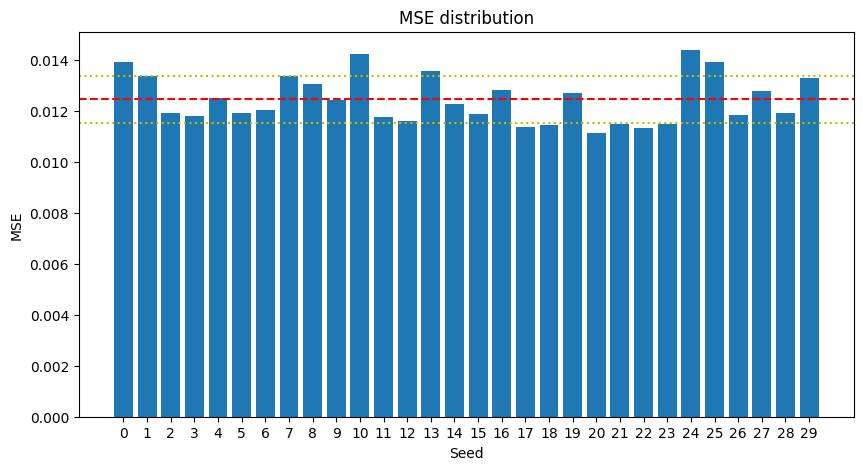

In [244]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [245]:
cst.save_results_to_excel("Task 3.13", mse_mean, mse_std, mse_seeds, excel_file_path)

In [246]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-13.xlsx')

In [22]:
pd.read_excel('./predictions/predictions-3-13.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0        156     140     117     133     137     116     100     135      89   
1        161     169     171     158     175     155     165     168     130   
2        169     156     130     149     149     122     119     148     104   
3        154     133     141     133     126     136     149     140     129   
4        173     160     135     152     158     123     117     152     108   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2743      32       9       9      -4      34      20      -9      21     -11   
2744      -6      35     -14      14      12      25     -19      45      22   
2745      27      20      13      -7      10      11       3      12      -3   
2746       2      47      -5      28       7      29       1      47      21   
2747      49       2      22      -1      25      17      14      23      25   

      Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0        105  ...      118      102      108      155       78      107   
1        139  ...      133      160      166      161      129      148   
2        118  ...      133      114      123      164       91      119   
3        130  ...      102      132      116      156      113      116   
4        121  ...      137      122      129      168       98      122   
...      ...  ...      ...      ...      ...      ...      ...      ...   
2743     -15  ...       -1       10       11       24       -3       25   
2744      37  ...       -7        8        7       39      -11       21   
2745      -7  ...      -18      -10       18       26      -16       14   
2746      50  ...      -12       12        8       42       -1       26   
2747       9  ...       -8       11       11       35       10       -6   

      Seed_27  Seed_28  Seed_29  rul  
0         117      122      148  220  
1         166      164      176  219  
2         125      138      166  218  
3         142      131      148  217  
4         124      144      172  216  
...       ...      ...      ...  ...  
2743       11       18       38    4  
2744       16        7       35    3  
2745       23        5       22    2  
2746       14       10       45    1  
2747       21       18       25    0  

[2748 rows x 31 columns]

##### 3.14 25% unsupervised, 75% supervised

In [248]:
tr, ts, trs, tru,vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [249]:
ratio_unsup = 0.25 
ratio_sup = 0.75
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 20868 (supervised), 3703 (unsupervised), 15864 (validation), 2748 (test)


In [250]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [251]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-14.log')

Epoch 1/15
805/805 [==============================] - 3s 3ms/step - loss: 0.0310 - mse: 0.0249 - cst: 0.0061 - val_loss: 0.0239 - val_mse: 0.0216 - val_cst: 0.0023
Epoch 2/15
805/805 [==============================] - 3s 4ms/step - loss: 0.0194 - mse: 0.0172 - cst: 0.0022 - val_loss: 0.0210 - val_mse: 0.0186 - val_cst: 0.0024
Epoch 3/15
805/805 [==============================] - 3s 3ms/step - loss: 0.0178 - mse: 0.0155 - cst: 0.0023 - val_loss: 0.0179 - val_mse: 0.0158 - val_cst: 0.0021
Epoch 4/15
805/805 [==============================] - 3s 3ms/step - loss: 0.0168 - mse: 0.0147 - cst: 0.0021 - val_loss: 0.0151 - val_mse: 0.0134 - val_cst: 0.0017
Epoch 5/15
805/805 [==============================] - 3s 4ms/step - loss: 0.0161 - mse: 0.0140 - cst: 0.0022 - val_loss: 0.0213 - val_mse: 0.0185 - val_cst: 0.0027
Epoch 6/15
805/805 [==============================] - 3s 4ms/step - loss: 0.0164 - mse: 0.0142 - cst: 0.0022 - val_loss: 0.0145 - val_mse: 0.0129 - val_cst: 0.0015
Epoch 7/15
805/8

Train history visualization for the first seed

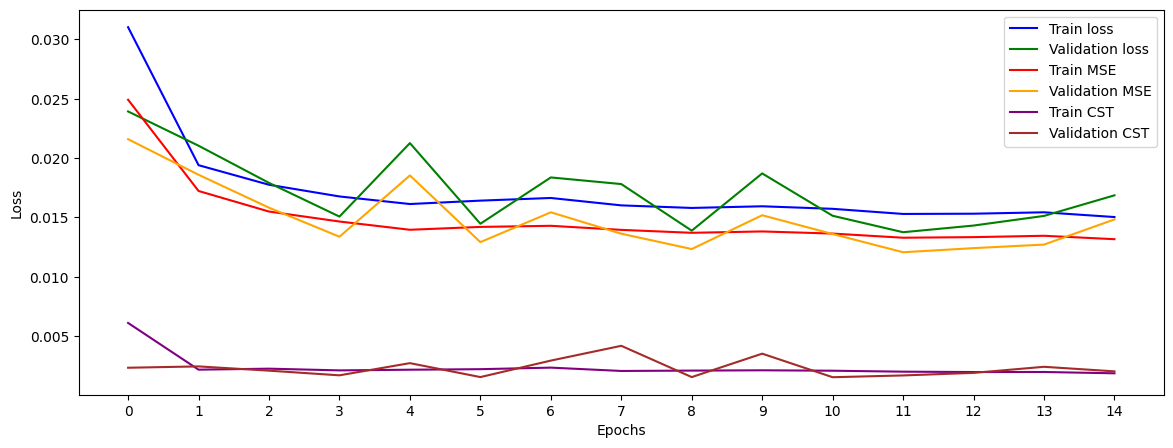

In [252]:
history = pd.read_csv('history/training-3-14.log')
cst.plot_losses_mixed(history, epochs)


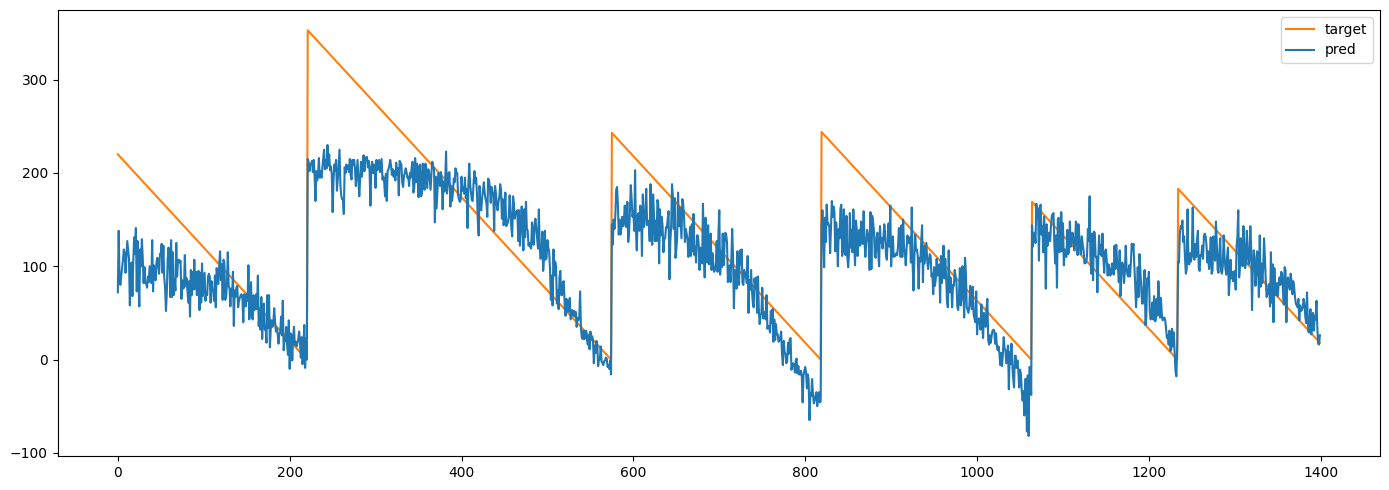

In [253]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [254]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0112
Standard Deviation of MSE: 0.0010


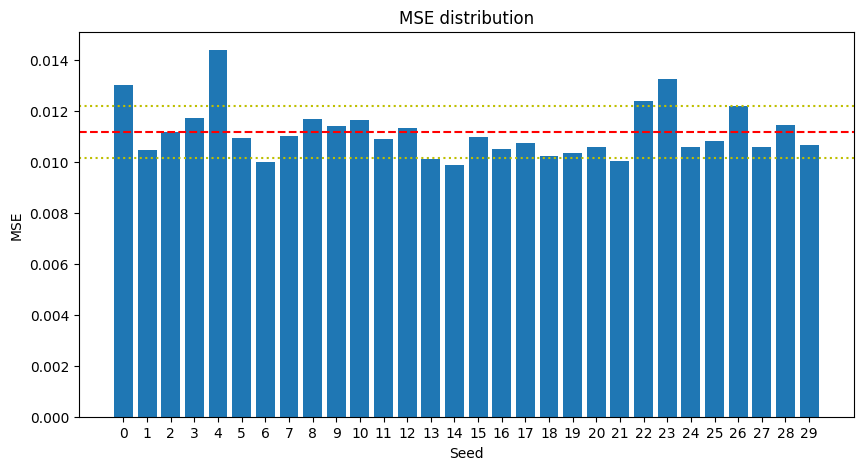

In [255]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [256]:
cst.save_results_to_excel("Task 3.14", mse_mean, mse_std, mse_seeds, excel_file_path)

In [257]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-14.xlsx')

In [23]:
pd.read_excel('./predictions/predictions-3-14.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0         72     109     100     139      67     132      83     108     103   
1        138     151     146     177     117     143     137     147     146   
2         87     124     111     156      83     143     103     121     119   
3         80     132     110     140      78     108      94     135     118   
4         90     126     121     162      97     150      99     122     119   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2743       4      17       7      22     -14      26      15       2      14   
2744     -33       1     -14      18      -3      16     -20       8      15   
2745      -8      20      -6       9     -53      16       2      -5      -5   
2746     -26       4      -2      22      -5      22       2       9      15   
2747     -26      19       3      14     -14      12     -10      25      15   

      Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0        102  ...       97       72       92      101       78      130   
1        147  ...      134      121      154      142      132      169   
2        114  ...      116       84      107      113       94      144   
3        101  ...      106       89      156       92      119      147   
4        116  ...      120       95      109      117       99      155   
...      ...  ...      ...      ...      ...      ...      ...      ...   
2743      -6  ...      -10      -10       37       16       17       19   
2744       2  ...       -7        6       22        9      -28       17   
2745       7  ...      -11      -30       21        3        7       21   
2746       9  ...      -21       17       21       13       -7       23   
2747      -2  ...       -9      -16       49       18       15       39   

      Seed_27  Seed_28  Seed_29  rul  
0         102       87       91  220  
1         140      123      144  219  
2         110       98      109  218  
3          97       87      135  217  
4         112      106      118  216  
...       ...      ...      ...  ...  
2743       13        6       -9    4  
2744       -3       10        0    3  
2745       -2       -6       -1    2  
2746       -8       13       12    1  
2747       13       14       22    0  

[2748 rows x 31 columns]

##### 3.15 25% unsupervised, 50% supervised

In [16]:
tr, ts, trs, tru, vs= cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [17]:
ratio_unsup = 0.25 
ratio_sup = 0.50
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 13912 (supervised), 3703 (unsupervised), 15864 (validation), 2748 (test)


In [18]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [19]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-15.log')

Epoch 1/15
572/572 [==============================] - 2s 4ms/step - loss: 0.0331 - mse: 0.0245 - cst: 0.0087 - val_loss: 0.0262 - val_mse: 0.0216 - val_cst: 0.0046
Epoch 2/15
572/572 [==============================] - 2s 3ms/step - loss: 0.0188 - mse: 0.0169 - cst: 0.0019 - val_loss: 0.0202 - val_mse: 0.0173 - val_cst: 0.0029
Epoch 3/15
572/572 [==============================] - 3s 5ms/step - loss: 0.0173 - mse: 0.0151 - cst: 0.0021 - val_loss: 0.0160 - val_mse: 0.0145 - val_cst: 0.0016
Epoch 4/15
572/572 [==============================] - 2s 3ms/step - loss: 0.0163 - mse: 0.0142 - cst: 0.0021 - val_loss: 0.0156 - val_mse: 0.0139 - val_cst: 0.0018
Epoch 5/15
572/572 [==============================] - 2s 3ms/step - loss: 0.0163 - mse: 0.0139 - cst: 0.0024 - val_loss: 0.0192 - val_mse: 0.0168 - val_cst: 0.0024
Epoch 6/15
572/572 [==============================] - 2s 3ms/step - loss: 0.0161 - mse: 0.0139 - cst: 0.0021 - val_loss: 0.0181 - val_mse: 0.0163 - val_cst: 0.0018
Epoch 7/15
572/5

Train history visualization for the first seed

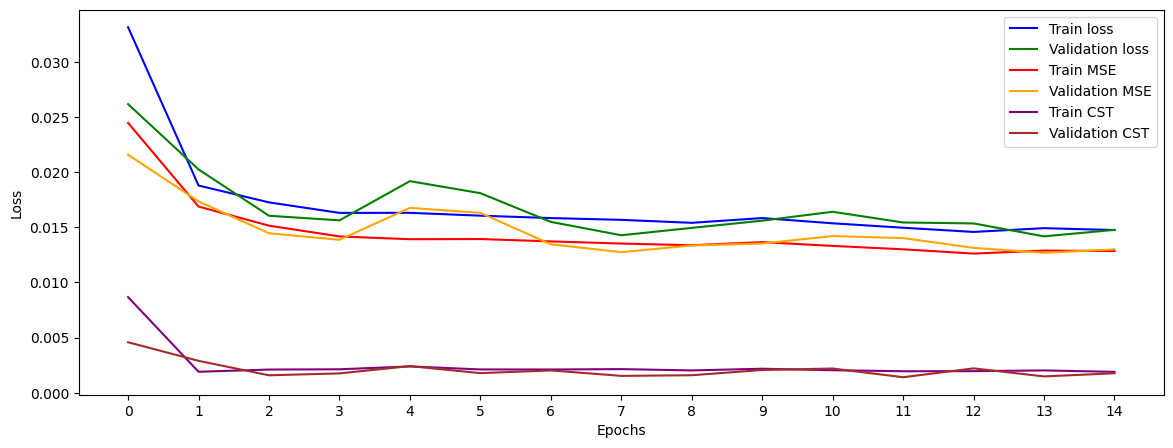

In [20]:
history = pd.read_csv('history/training-3-15.log')
cst.plot_losses_mixed(history, epochs)


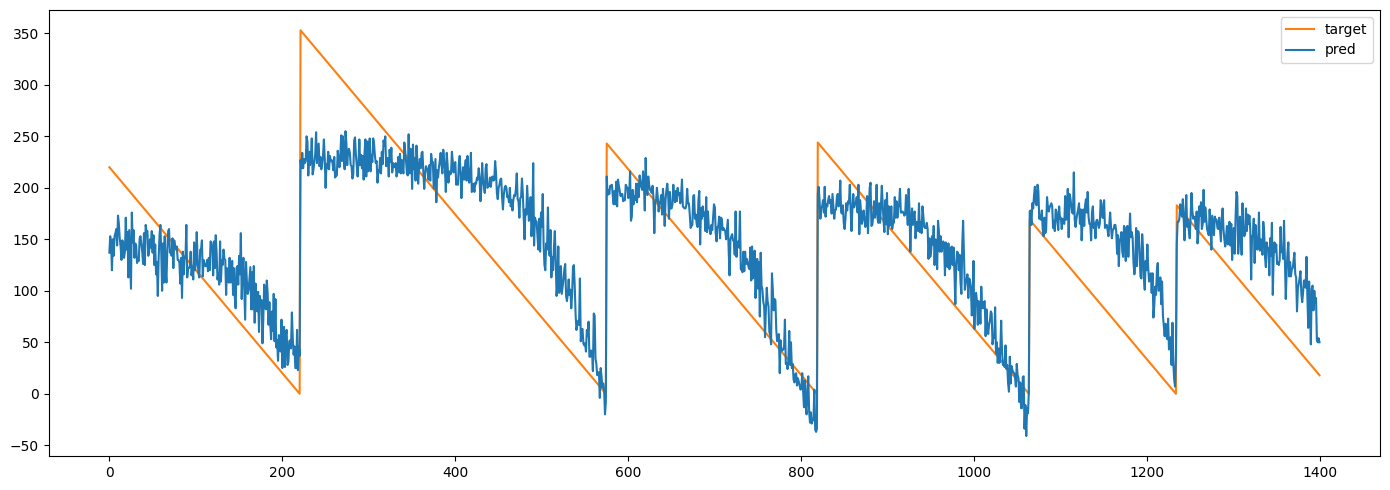

In [21]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [22]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0119
Standard Deviation of MSE: 0.0013


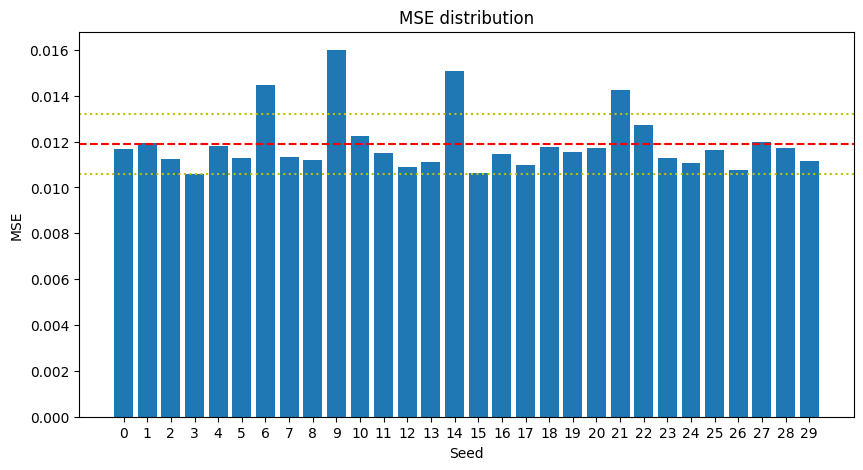

In [23]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [24]:
cst.save_results_to_excel("Task 3.15", mse_mean, mse_std, mse_seeds, excel_file_path)

In [25]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-15.xlsx')

In [25]:
pd.read_excel('./predictions/predictions-3-15.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0        137     106     108      93      71     108     157     100     139   
1        153     162     129     130     142     152     176     148     160   
2        146     122     122     111      84     114     177     113     153   
3        120     117     116     113     133     106     160     108     112   
4        150     125     131     118      99     115     173     109     154   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2743      14      -8      12     -22      -6     -11      32     -11      18   
2744       7      32     -44      27       8     -14      15     -25      22   
2745      11      23      -5     -11     -10       0      29       6       8   
2746      16      39     -33      34       2      -9      36     -22      17   
2747       3      13      18       0      22      -1      46      -1      14   

      Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0        131  ...       84      140      142       86       94      105   
1        173  ...      113      171      158      112      151      144   
2        146  ...      100      153      159       96      105      119   
3        173  ...       86      137      135      107      125      118   
4        146  ...      100      163      164      102      112      129   
...      ...  ...      ...      ...      ...      ...      ...      ...   
2743      11  ...      -28       19       21        5       -6       11   
2744      12  ...      -17       -6        4       20      -26      -17   
2745      16  ...      -22        2       -2        3        1       -1   
2746      19  ...      -28        4        7       31      -11       -6   
2747      41  ...      -12       23        8       32        7       30   

      Seed_27  Seed_28  Seed_29  rul  
0         138      125      125  220  
1         163      148      136  219  
2         145      142      135  218  
3         143      132      104  217  
4         146      151      145  216  
...       ...      ...      ...  ...  
2743       11       17       26    4  
2744       13       -2       42    3  
2745        9       10       -2    2  
2746        7       10       55    1  
2747       20       10       30    0  

[2748 rows x 31 columns]

##### 3.16 25% unsupervised, 25% supervised

In [27]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [28]:
ratio_unsup = 0.25 
ratio_sup = 0.25
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 6956 (supervised), 3703 (unsupervised), 15864 (validation), 2748 (test)


In [29]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [30]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-16.log')

Epoch 1/15
339/339 [==============================] - 2s 4ms/step - loss: 0.0341 - mse: 0.0211 - cst: 0.0130 - val_loss: 0.0266 - val_mse: 0.0244 - val_cst: 0.0022
Epoch 2/15
339/339 [==============================] - 1s 4ms/step - loss: 0.0156 - mse: 0.0138 - cst: 0.0017 - val_loss: 0.0216 - val_mse: 0.0197 - val_cst: 0.0020
Epoch 3/15
339/339 [==============================] - 2s 6ms/step - loss: 0.0138 - mse: 0.0120 - cst: 0.0018 - val_loss: 0.0193 - val_mse: 0.0174 - val_cst: 0.0019
Epoch 4/15
339/339 [==============================] - 1s 4ms/step - loss: 0.0128 - mse: 0.0109 - cst: 0.0019 - val_loss: 0.0212 - val_mse: 0.0173 - val_cst: 0.0039
Epoch 5/15
339/339 [==============================] - 1s 4ms/step - loss: 0.0124 - mse: 0.0106 - cst: 0.0019 - val_loss: 0.0162 - val_mse: 0.0151 - val_cst: 0.0011
Epoch 6/15
339/339 [==============================] - 2s 5ms/step - loss: 0.0117 - mse: 0.0099 - cst: 0.0018 - val_loss: 0.0171 - val_mse: 0.0146 - val_cst: 0.0025
Epoch 7/15
339/3

Train history visualization for the first seed

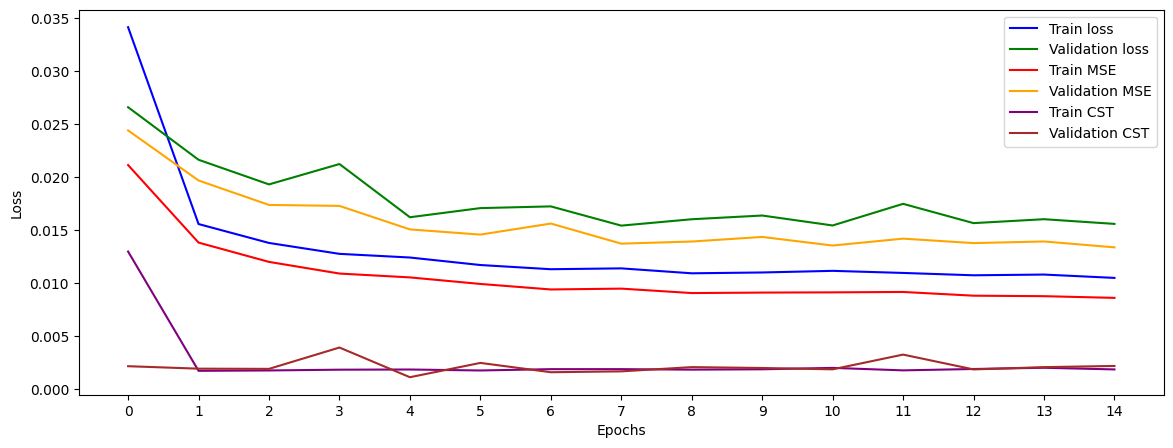

In [31]:
history = pd.read_csv('history/training-3-16.log')
cst.plot_losses_mixed(history, epochs)


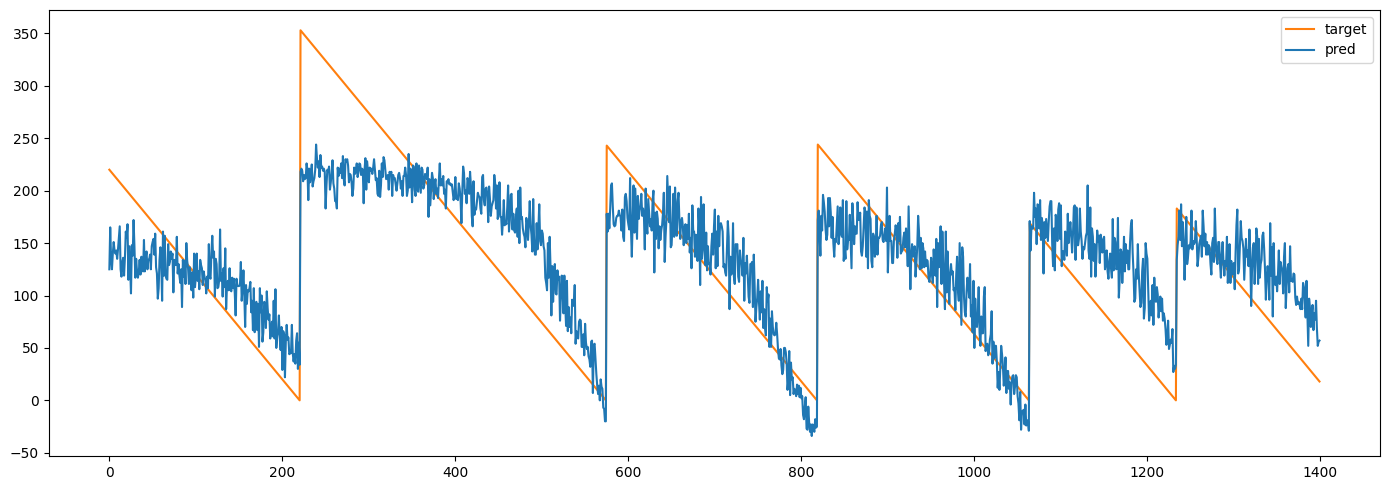

In [32]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [33]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0121
Standard Deviation of MSE: 0.0009


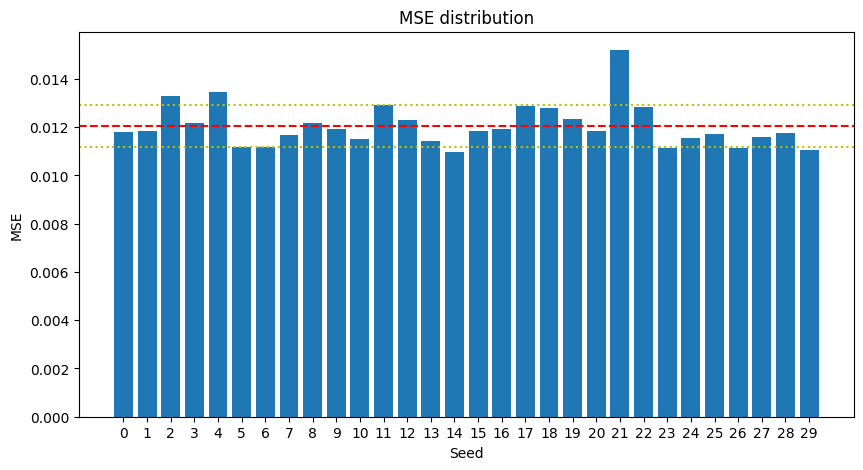

In [34]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [35]:
cst.save_results_to_excel("Task 3.16", mse_mean, mse_std, mse_seeds, excel_file_path)

In [36]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-16.xlsx')

In [26]:
pd.read_excel('./predictions/predictions-3-16.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0        125     128     148     122      81     122     116     107     114   
1        165     153     146     167     123     164     161     147     152   
2        135     149     161     139      95     132     133     118     131   
3        125     128     139     154     111     126     124     138     118   
4        140     154     165     140     104     134     127     111     134   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2743      24     -18      23     -33     -40      -5      -9      -2       1   
2744      -5      12      33     -18     -13       6     -30     -20     -13   
2745      28      -1      13      -3     -47      -5      -7      -2     -11   
2746       1      25      40       5     -17      14      -7     -14      -5   
2747       3       0      21      24      11      16      -2       9      13   

      Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0        110  ...      171      134      110      130      138      116   
1        153  ...      187      175      143      164      165      151   
2        127  ...      189      146      124      141      153      127   
3        138  ...      164      155      106      129      146      126   
4        131  ...      191      158      129      141      158      129   
...      ...  ...      ...      ...      ...      ...      ...      ...   
2743     -15  ...       36       19       20       21        6        3   
2744     -23  ...       13       26       -4       10      -11      -14   
2745      -2  ...       22       -6        4       17      -13       -3   
2746      -7  ...       -5       26        2       15       -4       -4   
2747      14  ...       30       19       -9       18       11       12   

      Seed_27  Seed_28  Seed_29  rul  
0         126      132       95  220  
1         167      143      149  219  
2         134      147      108  218  
3         135      110      138  217  
4         134      152      116  216  
...       ...      ...      ...  ...  
2743      -11       11       -8    4  
2744        9      -36      -30    3  
2745        3      -14        6    2  
2746       -8      -32       -9    1  
2747       -2       -1       22    0  

[2748 rows x 31 columns]

#### Results on Task 3

In [43]:
results_task3 = pd.read_excel('results.xlsx')

results_task3_1= results_task3[results_task3['Task'] == 'Task 3.1']
results_task3_2 = results_task3[results_task3['Task'] == 'Task 3.2']
results_task3_3 = results_task3[results_task3['Task'] == 'Task 3.3']
results_task3_4 = results_task3[results_task3['Task'] == 'Task 3.4']
results_task3_5 = results_task3[results_task3['Task'] == 'Task 3.5']
results_task3_6 = results_task3[results_task3['Task'] == 'Task 3.6']
results_task3_7 = results_task3[results_task3['Task'] == 'Task 3.7']
results_task3_8 = results_task3[results_task3['Task'] == 'Task 3.8']
results_task3_9 = results_task3[results_task3['Task'] == 'Task 3.9']
results_task3_10 = results_task3[results_task3['Task'] == 'Task 3.10']
results_task3_11 = results_task3[results_task3['Task'] == 'Task 3.11']
results_task3_12 = results_task3[results_task3['Task'] == 'Task 3.12']
results_task3_13 = results_task3[results_task3['Task'] == 'Task 3.13']
results_task3_14 = results_task3[results_task3['Task'] == 'Task 3.14']
results_task3_15 = results_task3[results_task3['Task'] == 'Task 3.15']
results_task3_16 = results_task3[results_task3['Task'] == 'Task 3.16']

#append new column with percentages to all results_task3
results_task3_1["Percentages"] = "100 u, 100 s"
results_task3_2["Percentages"] = "100 u, 75 s"
results_task3_3["Percentages"] = "100 u, 50 s"
results_task3_4["Percentages"] = "100 u, 25 s"
results_task3_5["Percentages"] = "50 u, 100 s"
results_task3_6["Percentages"] = "75 u, 100 s"
results_task3_7["Percentages"] = "25 u, 100 s"
results_task3_8["Percentages"] = "75 u, 75 s"
results_task3_9["Percentages"] = "75 u, 50 s"
results_task3_10["Percentages"] = "75 u, 25 s"
results_task3_11["Percentages"] = "50 u, 75 s"
results_task3_12["Percentages"] = "50 u, 50 s"
results_task3_13["Percentages"] = "50 u, 25 s"
results_task3_14["Percentages"] = "25 u, 75 s"
results_task3_15["Percentages"] = "25 u, 50 s"
results_task3_16["Percentages"] = "25 u, 25 s"



res_task3 = pd.concat([results_task3_1, results_task3_2, results_task3_3, results_task3_4, results_task3_5, results_task3_6, results_task3_7, results_task3_8, results_task3_9, results_task3_10, results_task3_11, results_task3_12, results_task3_13, results_task3_14, results_task3_15, results_task3_16]).drop(columns=drop_columns)

print(tabulate(res_task3, headers='keys', showindex=False,  tablefmt='psql'))


+-----------+-----------+-------------+---------------+
| Task      |      Mean |         Std | Percentages   |
|-----------+-----------+-------------+---------------|
| Task 3.1  | 0.0109722 | 0.000814917 | 100 u, 100 s  |
| Task 3.2  | 0.0109041 | 0.000473706 | 100 u, 75 s   |
| Task 3.3  | 0.0124868 | 0.000794526 | 100 u, 50 s   |
| Task 3.4  | 0.0148433 | 0.000868657 | 100 u, 25 s   |
| Task 3.5  | 0.0106446 | 0.000597778 | 50 u, 100 s   |
| Task 3.6  | 0.0105699 | 0.00046262  | 75 u, 100 s   |
| Task 3.7  | 0.0106759 | 0.000544534 | 25 u, 100 s   |
| Task 3.8  | 0.0112086 | 0.000914751 | 75 u, 75 s    |
| Task 3.9  | 0.0114565 | 0.000933271 | 75 u, 50 s    |
| Task 3.10 | 0.0124252 | 0.00115076  | 75 u, 25 s    |
| Task 3.11 | 0.0114138 | 0.00106732  | 50 u, 75 s    |
| Task 3.12 | 0.0115931 | 0.000789753 | 50 u, 50 s    |
| Task 3.13 | 0.0124448 | 0.000930329 | 50 u, 25 s    |
| Task 3.14 | 0.0111789 | 0.00102308  | 25 u, 75 s    |
| Task 3.15 | 0.0119027 | 0.00130128  | 25 u, 50

/tmp/ipykernel_11/542451260.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_task3_1["Percentages"] = "100 u, 100 s"
/tmp/ipykernel_11/542451260.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_task3_2["Percentages"] = "100 u, 75 s"
/tmp/ipykernel_11/542451260.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

From the obtained results we can observe the following:
- There is a general performance improvement compared to Tasks 1 and 2. This suggests that using mixed data allows better extraction of characteristics, by keeping good points from both supervised and unsupervised paradigms. As a matter of fact, from supervised data the model learns initial and final *RUL* values, while from unsupervised data it gets the overall trend. This is not in line with our initial expectations, as we thought that performances of Task 3 would lie in between those of Tasks 1 and 2.

- We expected performance to improve when keeping fixed unsupervised data and increasing supervised data ratio. This seems to be confirmed from our results, as we can observe for example by comparing the *mse* values for tasks from 3.1 to 3.4 (where decreasing *supervised ratio* leads to increasing *mse* values).

- On the other hand, we expected to have the opposite pattern when keeping fixed supervised data and increasing unsupervised data ratio. However, our expectations are not met since we are not able to detect a clear pattern in this sense: we get much variable *mse* results when we decrease *unsupervised ratio*.

- To further inspect the effects of changing *unsupervised ratio* of data while keeping fixed *supervised ratio*, we deem as particularly interesting the case where we have 50% of unsupervised data. In fact, this ratio enables us to study a more realistic case, in which we suppose to have huge amounts of unsupervised data wrt the supervised data and we have to choose the optimal ratio of unsupervised to be used. Here, we can observe a trend of performance improvement with increasing *unsupervised ratio*, which, however, plateaus when the percentage exceeds 75%.

- In general, when *supervised ratio* is greater than the unsupervised one, we observe better performance, which is compliant with our expectations. Indeed, if we consider the best results obtained (i.e. when we have *mse* < 0.011), they are due to *supervised ratio* being greater than the unsupervised or, in some cases, simply to a large amount of data used to train the model (as it happens in task 3.1).

- Conversely, we expected a greater *unsupervised ratio* to yield worse performance. However, if we look at the worst results (where *mse* >= 0.012), we notice that the relative percentages are typically of unsupervised > supervised or due to a small amount of data used to train the model (as it happens in task 3.16).

The fact that we use a fixed machine split when setting the ratios of supervised and unsupervised data makes it difficult to fully compare the obtained results, as we exclude some data from training every time we consider a percentage of data different from 100%. Hence, when choosing the best model we still have to take into account the amount of data on which the models are trained.

**Choosing the best model**: By comparing the results shown in the previous table, the best model in terms of mean *mse* value is the one trained in Task 3.6, where we have used 100% of supervised and 75% of unsupervised data.

In [41]:
# print predictions of the best model for the first machine
rul_values = pd.read_excel('./predictions/predictions-3-6.xlsx')
print(tabulate(rul_values[0:220], showindex= False, headers=rul_values.columns,  tablefmt='psql'))

+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------+
|   Seed_0 |   Seed_1 |   Seed_2 |   Seed_3 |   Seed_4 |   Seed_5 |   Seed_6 |   Seed_7 |   Seed_8 |   Seed_9 |   Seed_10 |   Seed_11 |   Seed_12 |   Seed_13 |   Seed_14 |   Seed_15 |   Seed_16 |   Seed_17 |   Seed_18 |   Seed_19 |   Seed_20 |   Seed_21 |   Seed_22 |   Seed_23 |   Seed_24 |   Seed_25 |   Seed_26 |   Seed_27 |   Seed_28 |   Seed_29 |   rul |
|----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-

### **Task 4**: Domain Knowledge injection by adding a new regularizer. We want to enforce the RUL being strictly positive

By observing the predictions obtained in the previous three tasks, we detected some negative *RUL* values that are not allowed in a realistic setting, as the lowest value should be 0. 

Therefore, we think that inferring **domain knowledge** will enhance the prediction qualiy of the regressor: adding a regularizer to enforce the RUL to be strictly positive will result in an improvment of the model's performances.

Adding a hyperparameter *gamma*, which controls the importance given to the positivity regularizer, should have a considerable impact on the results obtained.

In [15]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)
ratio_unsup = 0.75 
tru = tru[:int(len(tru) * ratio_unsup)]

print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)
Num. samples: 27824 (supervised), 11109 (unsupervised), 15864 (validation), 2748 (test)


In [18]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [15]:
history, predictions = train_task4(train_data=trsu_s, val_data=vs_s, test_data=ts_s, columns=dt_in, 
                             maxrul=trmaxrul, alpha=1.0, beta=1.0, gamma=4, logger_file = 'training-4.log')
    

Epoch 1/15
1264/1264 [==============================] - 10s 7ms/step - loss: 0.0246 - mse: 0.0194 - cst: 0.0051 - positivity_regularizer: 9.1201e-05 - val_loss: 0.0197 - val_mse: 0.0178 - val_cst: 0.0019 - val_positivity_regularizer: 0.0000e+00
Epoch 2/15
1264/1264 [==============================] - 10s 8ms/step - loss: 0.0161 - mse: 0.0140 - cst: 0.0021 - positivity_regularizer: 2.0275e-05 - val_loss: 0.0157 - val_mse: 0.0145 - val_cst: 0.0012 - val_positivity_regularizer: 0.0000e+00
Epoch 3/15
1264/1264 [==============================] - 10s 8ms/step - loss: 0.0148 - mse: 0.0128 - cst: 0.0020 - positivity_regularizer: 3.0168e-05 - val_loss: 0.0178 - val_mse: 0.0143 - val_cst: 0.0035 - val_positivity_regularizer: 0.0000e+00
Epoch 4/15
1264/1264 [==============================] - 10s 8ms/step - loss: 0.0146 - mse: 0.0124 - cst: 0.0021 - positivity_regularizer: 2.6931e-05 - val_loss: 0.0164 - val_mse: 0.0144 - val_cst: 0.0018 - val_positivity_regularizer: 1.7454e-04
Epoch 5/15
1264/1264

Train history visualization for the first seed

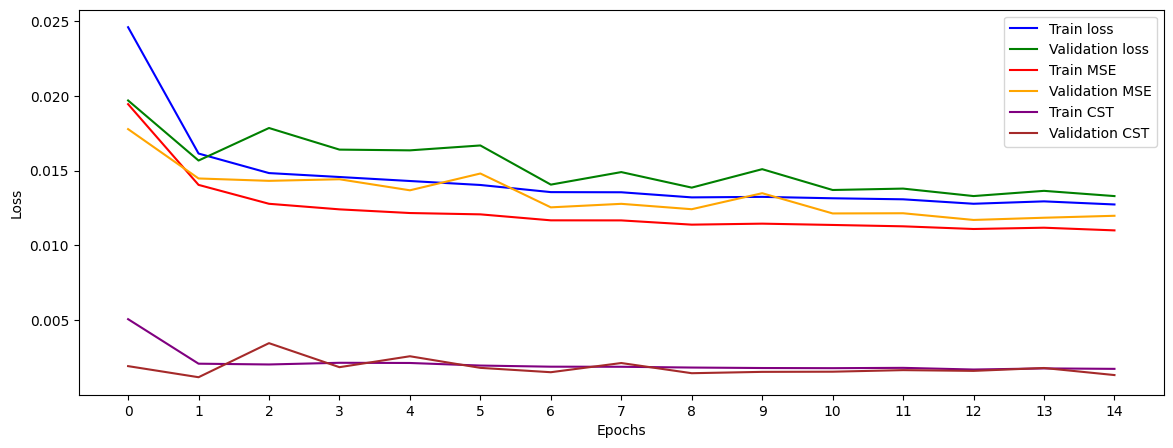

In [16]:
history = pd.read_csv('history/training-4.log')
cst.plot_losses_mixed(history, epochs)


Comment: bisogna vedere su più epoche

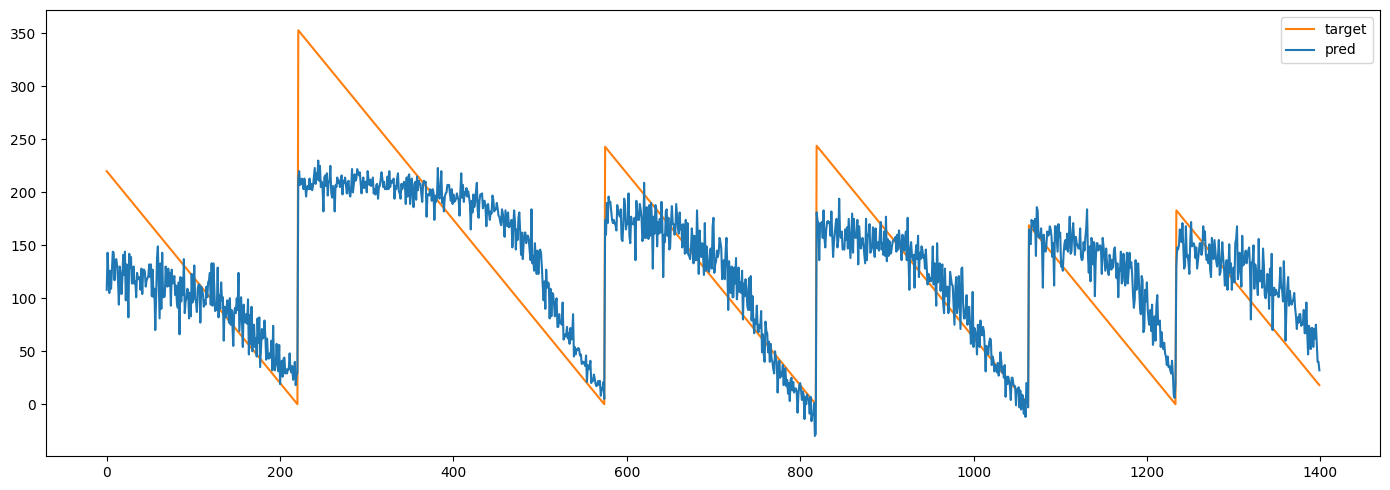

In [17]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [25]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0106
Standard Deviation of MSE: 0.0004


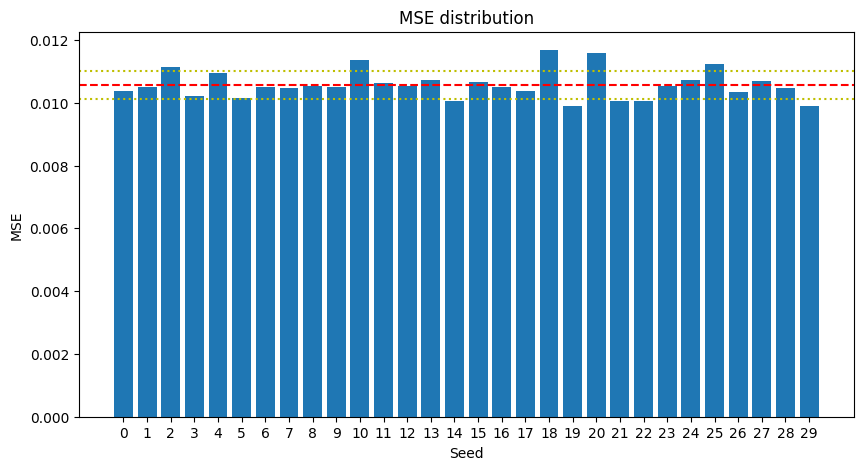

In [20]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

In [21]:
cst.save_results_to_excel("Task 4", mse_mean, mse_std, mse_seeds, excel_file_path)

In [22]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-4.xlsx')

In [20]:
pd.read_excel('./predictions/predictions-4.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0        112     114      76      74      98      90      84      95      88   
1        141     150     152     123     134     141     150     143     143   
2        125     126      91      93     113      99      99     109     108   
3        108     102     111     107     102      91      86     102     116   
4        131     130     101     101     123     104     101     109     115   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2743      20      37      15      22      20      17      25       7      11   
2744      20      28       3      13      52      33      24      31      14   
2745      14      36      11      -3      13      19      22      13      12   
2746      22      32      12      17      44      33      25      31      18   
2747      19      33      14      10      20      15      -1      28      28   

      Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0         93  ...       97       62      120       74      131      105   
1        131  ...      149      148      138      137      152      148   
2        106  ...      114       73      136       87      146      119   
3        120  ...      112      110      101      103      137      119   
4        109  ...      121       83      142       93      153      125   
...      ...  ...      ...      ...      ...      ...      ...      ...   
2743      10  ...       23       -4       28       15       26       15   
2744      30  ...       17      -11       27       29        5        6   
2745      17  ...       10       -3        2       18       37       15   
2746      28  ...       10       -5       32       27        9        9   
2747      26  ...       12      -17       16       30       31       15   

      Seed_27  Seed_28  Seed_29  rul  
0         130       81      107  220  
1         144      136      134  219  
2         140       89      122  218  
3         125      109       92  217  
4         142       93      133  216  
...       ...      ...      ...  ...  
2743       22       25       18    4  
2744       29       11       10    3  
2745        7      -11        8    2  
2746       31       20       22    1  
2747       23       26        7    0  

[2748 rows x 31 columns]

#### Results on Task 4

In [24]:
results_task4 = pd.read_excel('results.xlsx')

results_task4= results_task4[results_task4['Task'] == 'Task 4'].drop(columns=drop_columns)

print(tabulate(results_task4, headers='keys', showindex= False, tablefmt='psql'))

+--------+----------+----------+
| Task   |     Mean |      Std |
|--------+----------+----------|
| Task 4 | 0.010568 | 0.000425 |
+--------+----------+----------+


Results show a slight improvement with respect to Task 3.6. To obtain the best results, we manually tuned parameter *gamma* and we found out that its best configuration is 4. However, we expected to reach a greater improvement in the model's performance by adding a positivity regularizer than what we managed to achieve. 

To this extent, we have to take into account also the fact that we trained the model on 100% of supervised data and 75% of unsupervised: we hypothesize that having a greater percentage of unsupervised data mey lead to a more consistent enhancement. As a matter of fact, unsupervised data has proven to be more prone to predicting negative values. Another interesting experiment could be to analyze the effects of introducing a positivity regularizer in a fully unsupervised setting, as we expect to have a remarkable improvement of the performance in that case.

### **Task 5**: Lagrangian for dynamic weight of the loss function

Introducing a Lagrange multiplier can be considered as a weight that dynamically adjusts the importance of the regularization term, allowing the model to learn its optimal value during training. By adding a dynamic weight to the *cst* loss we expect a positive impact in the model's performance. 

We will test this approach on the best model obtained so far, namely the one of Task 4. In order to avoid possible conflict in the dynamic computation of the loss weight, we also tested the lagrangian regessor on the model structure of the task 3.6, using it as a benchmark, since it had similar performance to the model in the Task 4 but less likely to create conflict having no positivity regularizer.

#### Task 5.1: Benchmark on model structure of task 3.6

In [25]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)
ratio_unsup = 0.75 
tru = tru[:int(len(tru) * ratio_unsup)]

print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)
Num. samples: 27824 (supervised), 11109 (unsupervised), 15864 (validation), 2748 (test)


In [26]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [27]:
history, predictions = train_task5(train_data=trsu_s, val_data=vs_s, test_data=ts_s, columns=dt_in, 
                             maxrul=trmaxrul, alpha=1, beta=0, gamma=0, logger_file = 'training-5-1.log')

Epoch 1/15
1264/1264 [==============================] - 9s 7ms/step - loss: 0.0242 - mse: 0.0193 - cst: 0.0051 - val_loss: 0.0183 - val_mse: 0.0168 - val_cst: 0.0018
Epoch 2/15
1264/1264 [==============================] - 8s 7ms/step - loss: 0.0153 - mse: 0.0138 - cst: 0.0026 - val_loss: 0.0154 - val_mse: 0.0147 - val_cst: 0.0031
Epoch 3/15
1264/1264 [==============================] - 8s 7ms/step - loss: 0.0130 - mse: 0.0129 - cst: 0.0039 - val_loss: 0.0142 - val_mse: 0.0142 - val_cst: 0.0059
Epoch 4/15
1264/1264 [==============================] - 8s 7ms/step - loss: 0.0126 - mse: 0.0126 - cst: 0.0043 - val_loss: 0.0154 - val_mse: 0.0154 - val_cst: 0.0029
Epoch 5/15
1264/1264 [==============================] - 8s 7ms/step - loss: 0.0125 - mse: 0.0125 - cst: 0.0044 - val_loss: 0.0135 - val_mse: 0.0135 - val_cst: 0.0045
Epoch 6/15
1264/1264 [==============================] - 8s 7ms/step - loss: 0.0121 - mse: 0.0121 - cst: 0.0038 - val_loss: 0.0164 - val_mse: 0.0164 - val_cst: 0.0048
Epoc

Train history visualization for the first seed

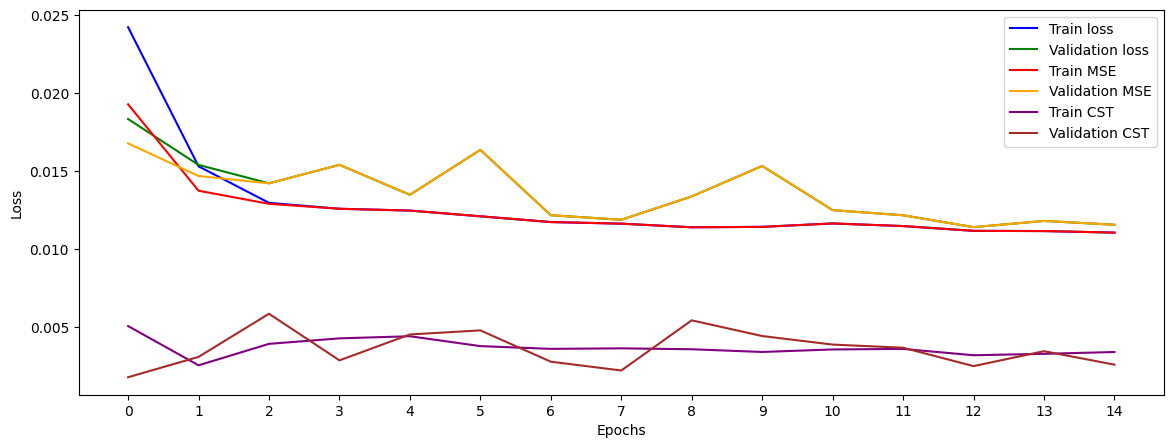

In [28]:
history = pd.read_csv('history/training-5-1.log')
cst.plot_losses_mixed(history, epochs)


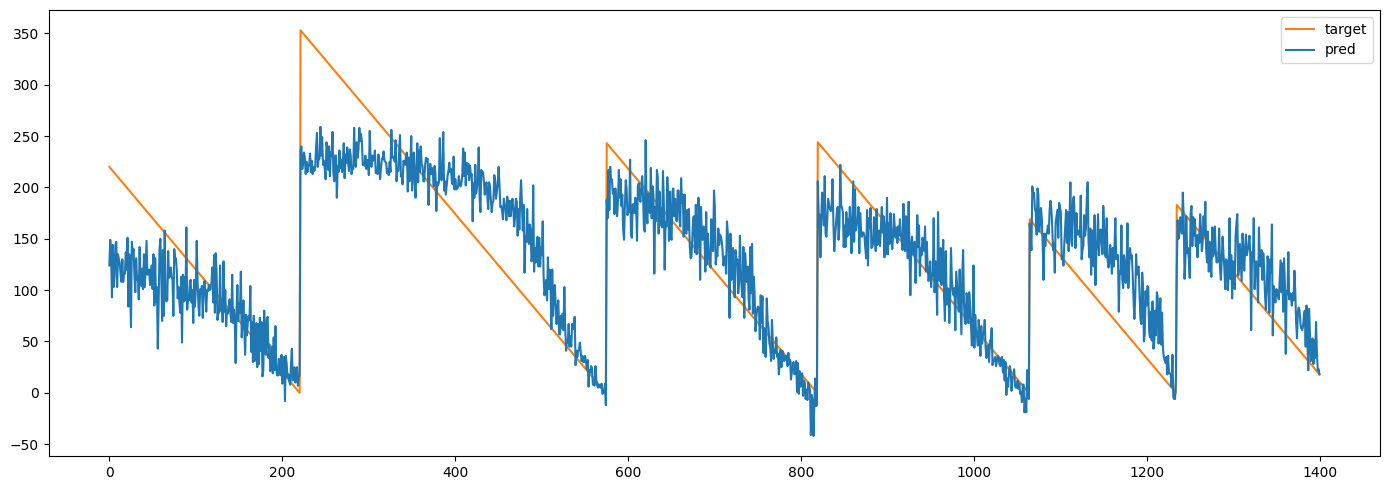

In [29]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [30]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0106
Standard Deviation of MSE: 0.0006


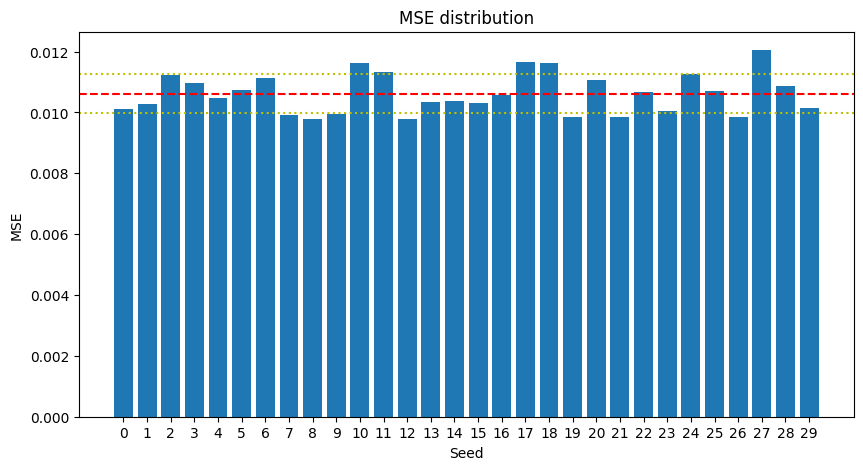

In [31]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

In [32]:
cst.save_results_to_excel("Task 5.1", mse_mean, mse_std, mse_seeds, excel_file_path)

In [33]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-5-1.xlsx')

In [34]:
pd.read_excel('./predictions/predictions-5-1.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0        124      78      45      42     105      95      81      87     108   
1        149     153     138     118     149     142     129     139     146   
2        139      93      61      64     114     106     100     102     126   
3         93      86     117     117      87     100     126      99      99   
4        144      97      71      71     123     108      96     104     131   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2743      17       4     -13       3      -7       6       1       2      23   
2744      -8      19       3      -8       9     -28      22       6       7   
2745       6       7       0     -22      -6       8       1      -4      11   
2746      -9      21       1       4       7     -30      26      10       8   
2747      13      25      -5      16      10       6      17      18      21   

      Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0         89  ...       86      106       79       70      118      105   
1        137  ...      148      155      151      136      136      145   
2        104  ...      106      120       95       80      133      116   
3         88  ...      114       65      118      107      141       87   
4        110  ...      112      130      104       86      142      132   
...      ...  ...      ...      ...      ...      ...      ...      ...   
2743      18  ...       10       18       18       14       15        4   
2744      25  ...       -7        4       17       -3        1        0   
2745       0  ...       11       -2       -8        5        7        5   
2746      28  ...      -10        7       18       -4        6        6   
2747      17  ...        1      -14       23       19       19        8   

      Seed_27  Seed_28  Seed_29  rul  
0         170      126       96  220  
1         156      135      117  219  
2         181      137      114  218  
3          94       68       76  217  
4         182      133      128  216  
...       ...      ...      ...  ...  
2743       36       19       20    4  
2744      -14        0      -23    3  
2745        7       -5        7    2  
2746      -17        8       -5    1  
2747        5       -9        2    0  

[2748 rows x 31 columns]

#### Task 5.2: Lagrangian model structure of task 4

In [20]:
history, predictions = train_task5(train_data=trsu_s, val_data=vs_s, test_data=ts_s, columns=dt_in, 
                             maxrul=trmaxrul, alpha=1, beta=0, gamma=4, logger_file = 'training-5-2.log')

Epoch 1/15
1264/1264 [==============================] - 11s 8ms/step - loss: 0.0245 - mse: 0.0194 - cst: 0.0051 - val_loss: 0.0190 - val_mse: 0.0174 - val_cst: 0.0019
Epoch 2/15
1264/1264 [==============================] - 10s 8ms/step - loss: 0.0155 - mse: 0.0139 - cst: 0.0024 - val_loss: 0.0153 - val_mse: 0.0146 - val_cst: 0.0025
Epoch 3/15
1264/1264 [==============================] - 10s 8ms/step - loss: 0.0131 - mse: 0.0129 - cst: 0.0036 - val_loss: 0.0150 - val_mse: 0.0150 - val_cst: 0.0070
Epoch 4/15
1264/1264 [==============================] - 11s 9ms/step - loss: 0.0127 - mse: 0.0126 - cst: 0.0041 - val_loss: 0.0153 - val_mse: 0.0153 - val_cst: 0.0030
Epoch 5/15
1264/1264 [==============================] - 11s 9ms/step - loss: 0.0126 - mse: 0.0125 - cst: 0.0046 - val_loss: 0.0138 - val_mse: 0.0138 - val_cst: 0.0053
Epoch 6/15
1264/1264 [==============================] - 11s 9ms/step - loss: 0.0123 - mse: 0.0123 - cst: 0.0041 - val_loss: 0.0170 - val_mse: 0.0170 - val_cst: 0.004

Train history visualization for the first seed

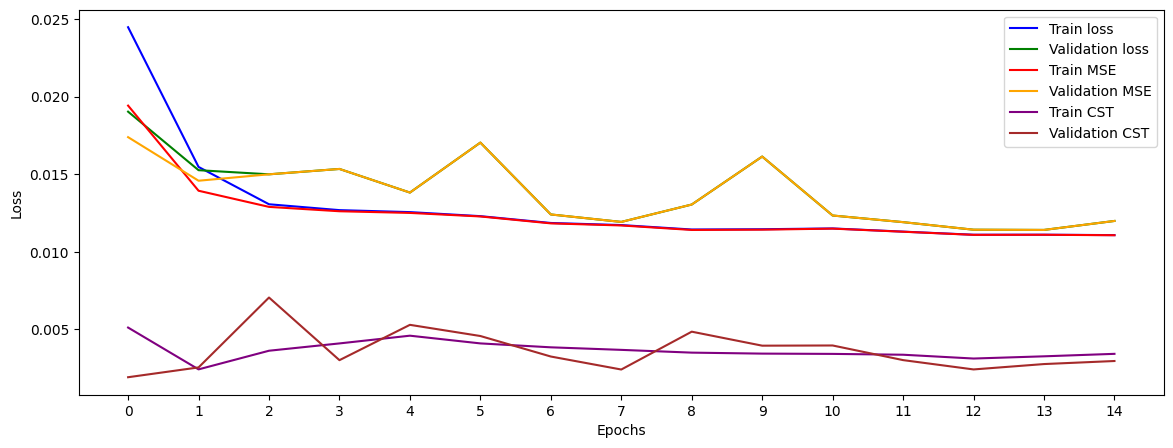

In [21]:
history = pd.read_csv('history/training-5-2.log')
cst.plot_losses_mixed(history, epochs)


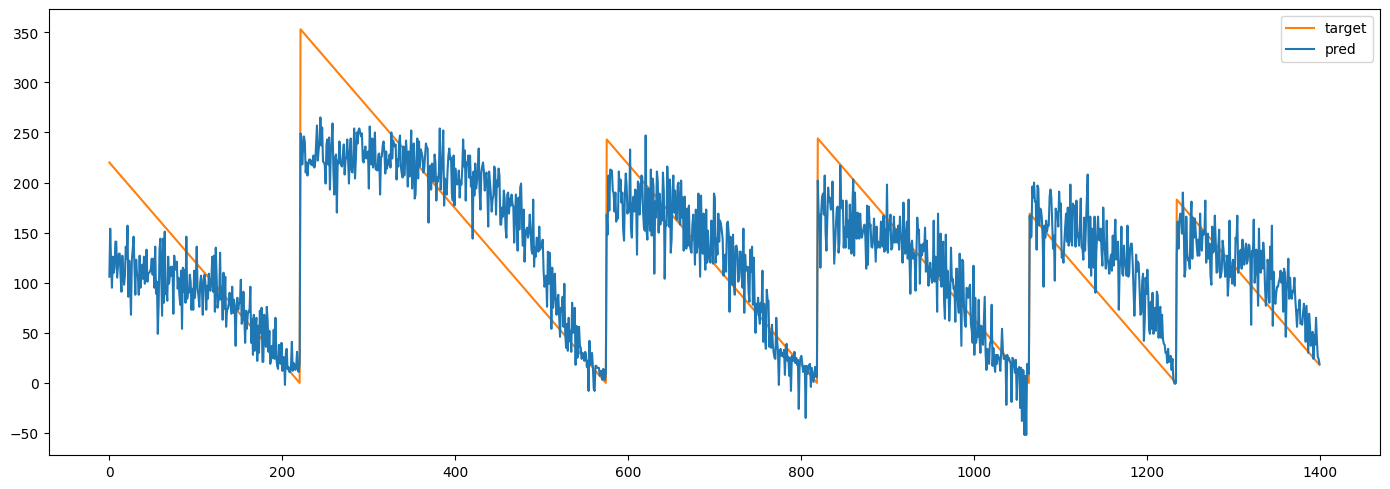

In [22]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [23]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0106
Standard Deviation of MSE: 0.0007


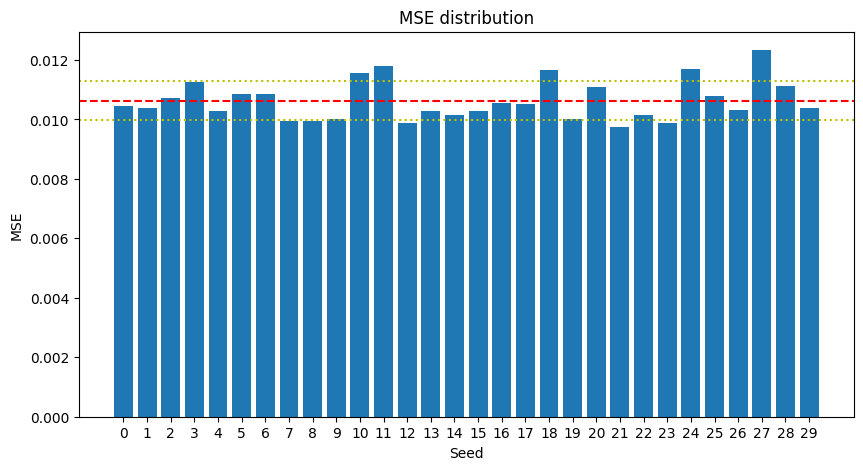

In [24]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

In [25]:
cst.save_results_to_excel("Task 5.2", mse_mean, mse_std, mse_seeds, excel_file_path)

In [26]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-5-2.xlsx')

In [37]:
pd.read_excel('./predictions/predictions-5-2.xlsx')

Seed_0  Seed_1  Seed_2  Seed_3  Seed_4  Seed_5  Seed_6  Seed_7  Seed_8  \
0        106      78      66      31      80     107      87      96     110   
1        154     154     134     113     146     142     123     155     153   
2        120      91      82      38      99     113     106     113     135   
3         95      92     115     122      91      98     137      94      98   
4        126      97      90      52     114     119     103     114     144   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2743      15      16       5       3       5      14       9       6      19   
2744     -21       5      13       7      -3     -18      20       7       2   
2745      15      20      12     -10      14      12      13       3       0   
2746     -18      10      14      16      -8     -25      23       7       4   
2747      23      19      13      16      17       7      17      14      26   

      Seed_9  ...  Seed_21  Seed_22  Seed_23  Seed_24  Seed_25  Seed_26  \
0         98  ...       92      100       82       69      117      106   
1        138  ...      153      144      147      127      142      149   
2        112  ...      113      113       99       81      132      120   
3         98  ...      113       80      123       81      142       99   
4        115  ...      116      123      106       91      142      135   
...      ...  ...      ...      ...      ...      ...      ...      ...   
2743      10  ...       15       13       18       13       14       -1   
2744      27  ...        5        4       25       -9        7      -38   
2745      16  ...        4        2        0        5       14        9   
2746      36  ...       -2        3       25        3       14      -41   
2747      16  ...        9       -7       14       16       18        5   

      Seed_27  Seed_28  Seed_29  rul  
0         172      129      113  220  
1         153      143      121  219  
2         179      137      125  218  
3          85       59       72  217  
4         180      134      137  216  
...       ...      ...      ...  ...  
2743       35       22       25    4  
2744       11        8      -16    3  
2745        5       16       12    2  
2746        5       12       -7    1  
2747        6        2      -12    0  

[2748 rows x 31 columns]

#### Results on Task 5

In [35]:
results_task5 = pd.read_excel('results.xlsx')

results_task5_1= results_task5[results_task5['Task'] == 'Task 5.1'].drop(columns=drop_columns)
results_task5_2= results_task5[results_task5['Task'] == 'Task 5.2'].drop(columns=drop_columns)
results_task5 = pd.concat([results_task5_1, results_task5_2])

print(tabulate(results_task5, headers='keys', showindex= False, tablefmt='psql'))

+----------+-----------+-------------+
| Task     |      Mean |         Std |
|----------+-----------+-------------|
| Task 5.1 | 0.0106186 | 0.00064258  |
| Task 5.2 | 0.0106311 | 0.000659321 |
+----------+-----------+-------------+


Diffrently from what we expected the results didn't show a large improvment in both Task 5.1 and 5.2.

- In the benchmark run we managed to sligthly improve the performance of the model, getting closer to the results obtained in the Task 4. 
- In the Task 5.2 however the results had lowered in comparison to the Task 4, which was used as baseline model for the lagrangian multiplier. This can be due to the fact that adding a dynamic weight to the loss created some conflict with the positivity regularizer, thus making it less important in the gradient computation and resulting in higher number of negative values for the *RUL*, as well as lower performances than the two model separated.
  
Finally, our expectation on the possibility of a conflict were comfirmed and this can be seen from the data showed in the table above.

### **Final observations and comments**

In [26]:
results = pd.read_excel('results.xlsx')
results.drop(columns=drop_columns)

print(tabulate(results, headers='keys', showindex= False, tablefmt='psql'))


+-----------+-----------+-------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+-----------+-----------+------------+-----------+-----------+-----------+-----------+-----------+-----------+------------+-----------+------------+-----------+------------+-----------+-----------+------------+------------+------------+------------+
| Task      |      Mean |         Std |    Seed_0 |    Seed_1 |    Seed_2 |    Seed_3 |     Seed_4 |    Seed_5 |    Seed_6 |     Seed_7 |     Seed_8 |     Seed_9 |   Seed_10 |   Seed_11 |    Seed_12 |   Seed_13 |   Seed_14 |   Seed_15 |   Seed_16 |   Seed_17 |   Seed_18 |    Seed_19 |   Seed_20 |    Seed_21 |   Seed_22 |    Seed_23 |   Seed_24 |   Seed_25 |    Seed_26 |    Seed_27 |    Seed_28 |    Seed_29 |
|-----------+-----------+-------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+-----------+-

By comparing the results obtained in this study, we can assert that the best performance is achieved by those models which handle both supervised and unsupervised data during training. As a matter of fact, using a mixed dataset enables the model to learn the monotonically decreasing trend thanks to unsupervised contribution, as well as the bound for the predictions for a given machine thanks to supervised data. This result indeed disproved our expectations, which were based on the assumption that the best model would have been the one trained on a fully supervised setting: this is not true as can be observed from the mean *mse* values in the table above.

Attempts to furtherly enhance the best model's performance by adding a positivity regularization term or a dynamic weight for the *cst* loss were not as effective as expected. In fact, we didn't obtain a consistent improvement in tasks 4 and 5 with respect to the mean *mse* value recorded for task 3.6. However, this doesn't prove those techniques to be useless: model 3.6 uses a considerable amount of both supervised and unsupervised data (100% and 75%, respectively), for which the tested approaches to improve may not be very suitable. To this extent, it could be interesting carrying out other experiments where there is a clear dominance of unsupervised data (either by using a mixed dataset where *unsupervised ratio* >> *supervised ratio* or even a fully supervised dataset) in order to be able to better assess the contribution of those approaches.

To conclude, our expectations were partially met: models trained on fully supervised and unsupervised behaved more or less as expected (even though we thought that models of task 2 would have performed worse), while models trained on mixed data showed a behavior that definitely challenged our assumptions by outperforming all the previous ones. Also positivity and dynamic regularization did not match our expectations of consistently enhancing the best model's performance, confirming model of task 3.6 as the most effective for our specific problem and dataset.